## ⚙️ Import Libraries

In [3]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data (no outlier)

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
data = np.load("/kaggle/input/cleean-data/cleaned_data.npz")

X_train = data["training_set_filtered"]

y_train = data["masks_filtered"]

X_test = data["test_set"]
print(y_train[0].shape)
print(f"Test X shape: {X_test.shape}")

# Perform train-validation split (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

(64, 128)
Test X shape: (10022, 64, 128)
Train set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


### Outliers removed

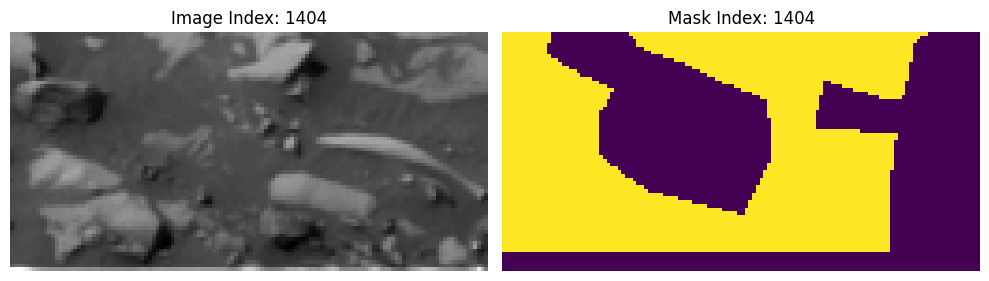

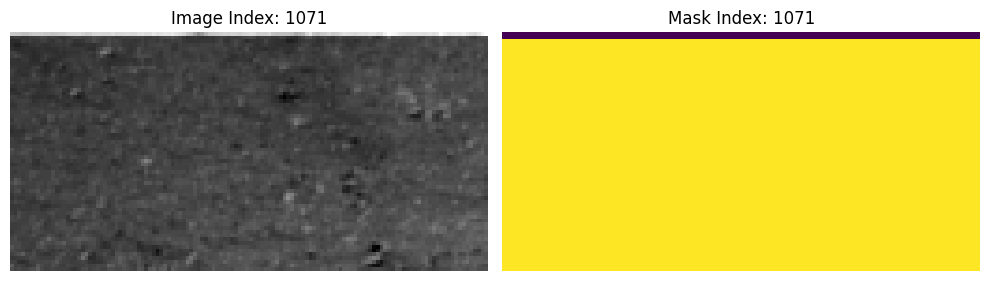

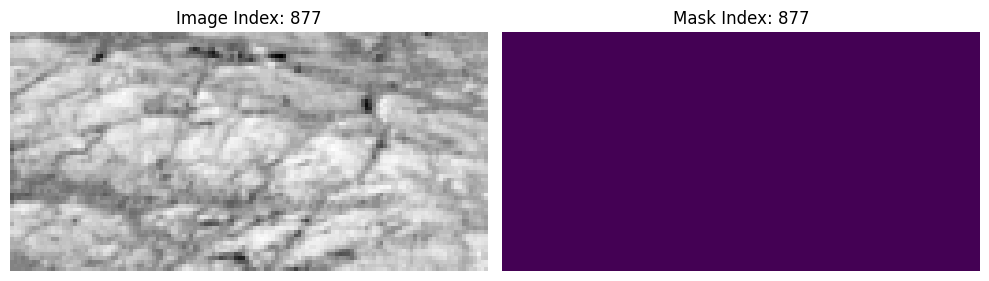

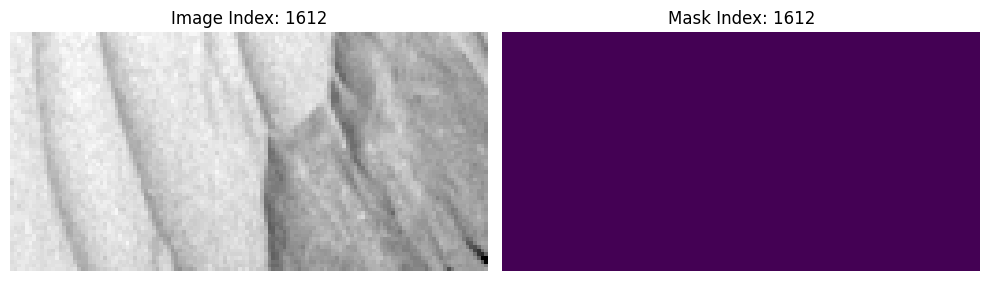

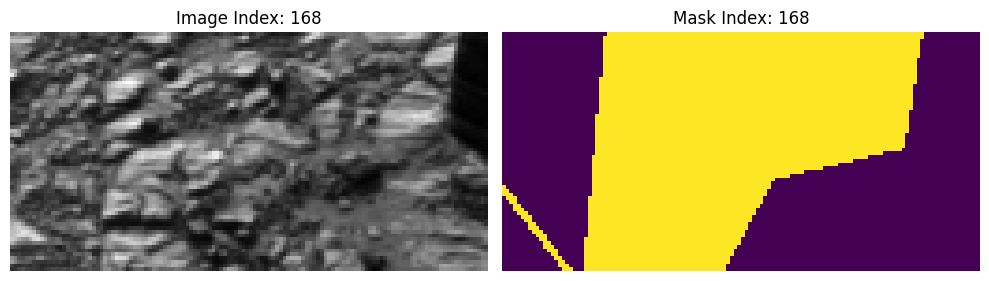

In [5]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

## LETS DO SOME AUGMENTATION!!

## invert image and noise

/tmp/ipykernel_23/1632159539.py:66: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(images), 6, i * 6 + 3)
/tmp/ipykernel_23/1632159539.py:88: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


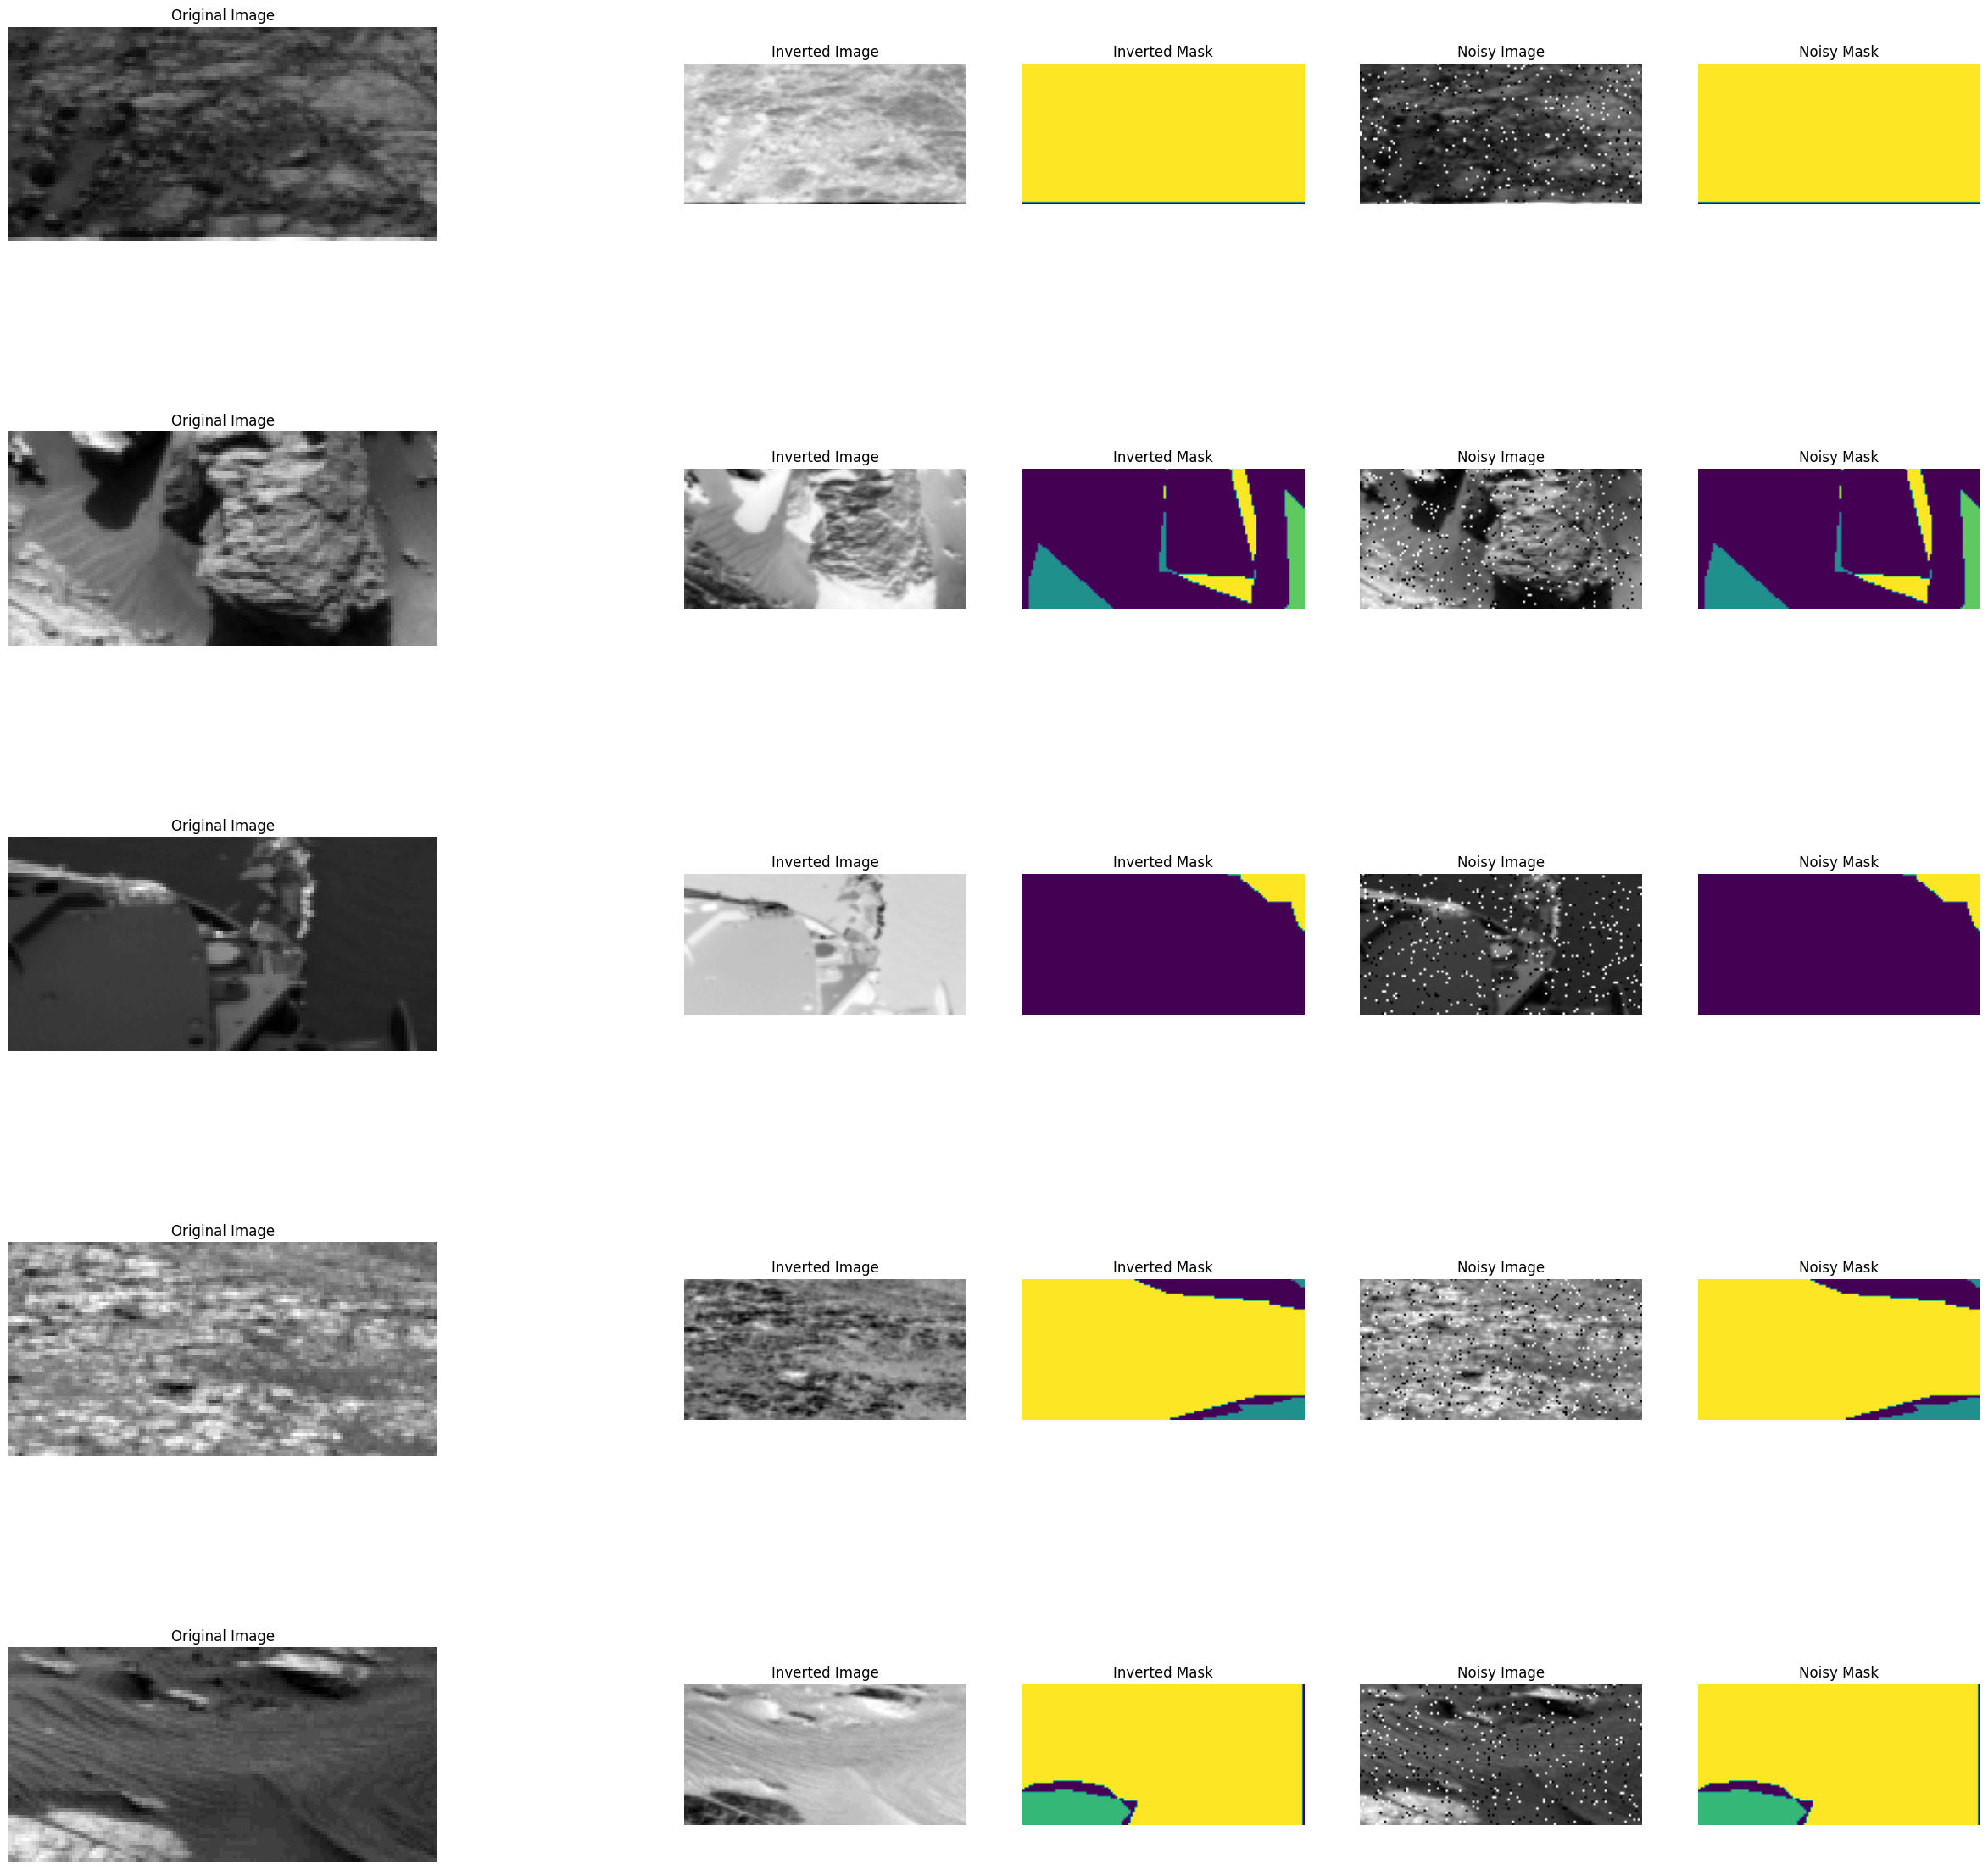

In [6]:


import numpy as np
from skimage.util import random_noise

# Define augmentation functions with mask handling
def invert_image(image, mask):
    return 255 - image, mask  # Mask remains unchanged

def add_salt_and_pepper_noise(image, mask, prob=0.03):
    """
    Add salt-and-pepper noise to an image while maintaining its original value range.

    Args:
        image (np.ndarray): Input image.
        mask (np.ndarray): Corresponding mask (unchanged).
        prob (float): Probability of noise per pixel.

    Returns:
        noisy_image (np.ndarray): Image with noise applied.
        mask (np.ndarray): Unchanged mask.
    """
    # Save the original range
    original_min = image.min()
    original_max = image.max()

    # Normalize the image to [0, 1]
    normalized_image = (image - original_min) / (original_max - original_min)

    # Generate random noise map
    random_map = np.random.random(image.shape)
    noisy_image = normalized_image.copy()
    noisy_image[random_map < prob] = 0  # Pepper
    noisy_image[random_map > (1 - prob)] = 1  # Salt

    # Rescale back to the original range
    noisy_image = noisy_image * (original_max - original_min) + original_min
    noisy_image = noisy_image.astype(image.dtype)  # Ensure the original data type is preserved

    return noisy_image, mask

"""def rotate_image(image, mask, angle):
    rotated_image = rotate(image, angle, reshape=False, mode='constant', cval=0)
    rotated_mask = rotate(mask, angle, reshape=False, mode='constant', order=0)
    return rotated_image, rotated_mask"""
"""
def adjust_brightness(image, mask, factor=1.2):
    brightened_image = np.clip(image * factor, 0, 255).astype(np.uint8)
    return brightened_image, mask  # Mask remains unchanged"""

# Visualize augmentations with masks
def visualize_all_augmentations(images, masks):
    plt.figure(figsize=(30, 30))
    for i, (image, mask) in enumerate(zip(images, masks)):
        # Original image and mask
        plt.subplot(len(images), 4, i * 4 + 1)
        plt.imshow(image, cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(len(images), 4, i * 4 + 2)
        plt.imshow(mask, cmap="viridis")
        plt.title("Original Mask")
        plt.axis("off")

        # Inversion
        inverted_image, inverted_mask = invert_image(image, mask)
        plt.subplot(len(images), 6, i * 6 + 3)
        plt.imshow(inverted_image, cmap="gray")
        plt.title("Inverted Image")
        plt.axis("off")

        plt.subplot(len(images), 6, i * 6 + 4)
        plt.imshow(inverted_mask, cmap="viridis")
        plt.title("Inverted Mask")
        plt.axis("off")

        # Noise
        noisy_image, noisy_mask = add_salt_and_pepper_noise(image, mask)
        plt.subplot(len(images), 6, i * 6 + 5)
        plt.imshow(noisy_image, cmap="gray")
        plt.title("Noisy Image")
        plt.axis("off")

        plt.subplot(len(images), 6, i * 6 + 6)
        plt.imshow(noisy_mask, cmap="viridis")
        plt.title("Noisy Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Randomly select 5 samples from the dataset
random_indices = np.random.choice(len(X_train), size=5, replace=False)
sample_images = X_train[random_indices]
sample_masks = y_train[random_indices]

# Visualize augmentations
visualize_all_augmentations(sample_images, sample_masks)


### rotation

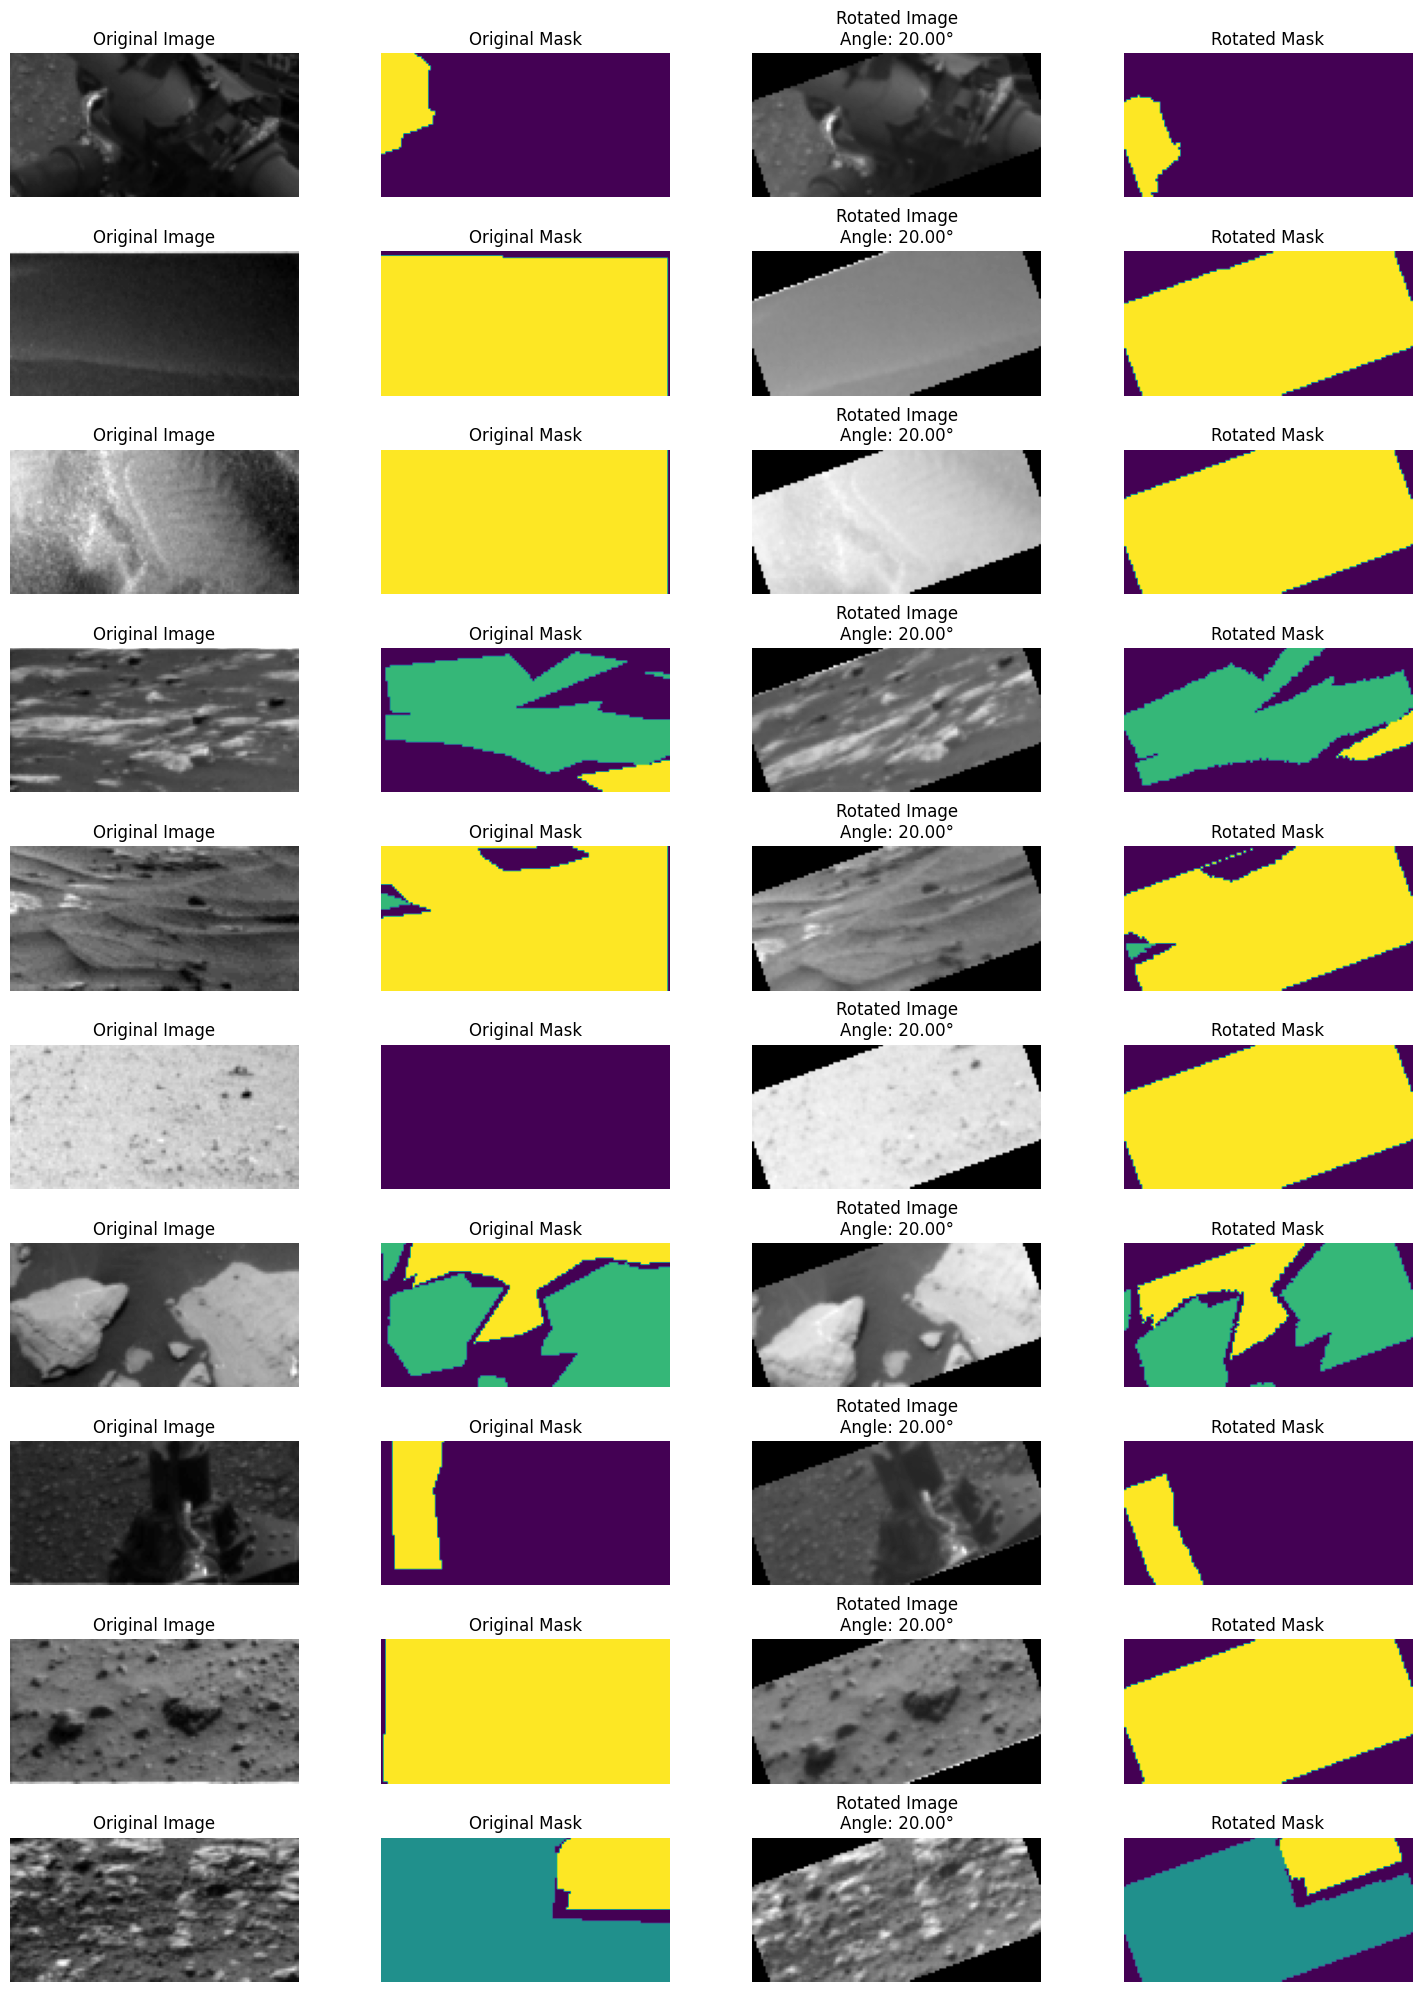

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# Define the rotation function using scipy
def rotate_image_and_mask(image, mask, angle):
    """
    Rotate a grayscale image and its corresponding mask by a given angle.
    """
    # Rotate the grayscale image (bilinear interpolation)
    rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

    # Rotate the mask (nearest-neighbor interpolation)
    rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

    return rotated_image, rotated_mask

# Randomly select 10 images
random_indices = np.random.choice(len(X_train), size=10, replace=False)
selected_images = X_train[random_indices]
selected_masks = y_train[random_indices]

# Apply random rotation and visualize
plt.figure(figsize=(15, 20))
for i, (image, mask) in enumerate(zip(selected_images, selected_masks)):
    # Generate a random angle for rotation
    angle = np.random.uniform(20, 20)  # Random angle between -30° and 30°

    # Rotate the image and mask
    rotated_image, rotated_mask = rotate_image_and_mask(image, mask, angle)

    # Plot original and rotated images/masks
    plt.subplot(10, 4, i * 4 + 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 2)
    plt.imshow(mask, cmap="viridis")
    plt.title("Original Mask")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 3)
    plt.imshow(rotated_image, cmap="gray")
    plt.title(f"Rotated Image\nAngle: {angle:.2f}°")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 4)
    plt.imshow(rotated_mask, cmap="viridis")
    plt.title("Rotated Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


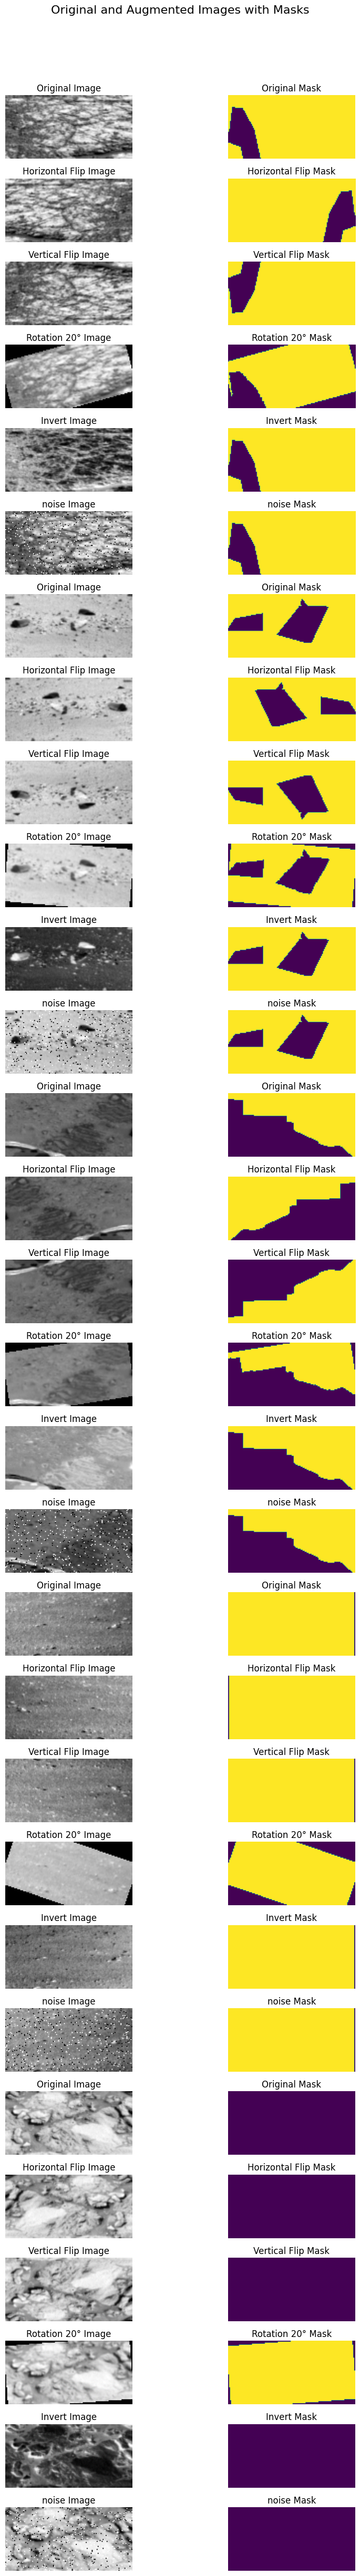

In [8]:
# Helper functions for applying augmentations
def augment_image_and_mask(image, mask, augment_type):
    if augment_type == "Horizontal Flip":
        return np.fliplr(image), np.fliplr(mask)
    elif augment_type == "Vertical Flip":
        return np.flipud(image), np.flipud(mask)
    elif augment_type == "Rotation 20°":
        angle = np.random.uniform(-20, 20)
        # Rotate the grayscale image (bilinear interpolation)
        rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

        # Rotate the mask (nearest-neighbor interpolation)
        rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

        return rotated_image, rotated_mask
    elif augment_type=="Invert":
        inverted_image, inverted_mask = invert_image(image, mask)
        return inverted_image,inverted_mask
    elif augment_type=="noise":
        noisy_image, noisy_mask = add_salt_and_pepper_noise(image, mask)
        return noisy_image,noisy_mask
        
    """elif augment_type == "Zoom (0.8-1.2)":
        zoom_factor = random.uniform(0.8, 1.2)
        zoom_image = np.clip(image * zoom_factor, 0, 255)
        return zoom_image, mask
    elif augment_type == "Shift (Width and Height)":
        shift_x, shift_y = random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1)
        return shift(image, [shift_x * image.shape[0], shift_y * image.shape[1]]), shift(mask, [shift_x * mask.shape[0], shift_y * mask.shape[1]], order=0)"""
    return image, mask

# Define augmentations
data_augmentations = {
    "Horizontal Flip": "Horizontal Flip",
    "Vertical Flip": "Vertical Flip",
    "Rotation 20°": "Rotation 20°",
    "Invert":"Invert",
    "noise":"noise"
    #"Zoom (0.8-1.2)": "Zoom (0.8-1.2)",
    #"Shift (Width and Height)": "Shift (Width and Height)",
}

# Visualize 5 random images and masks with augmentations
random_indices = np.random.choice(len(X_train), size=5, replace=False)
# Adjusting to display original image/mask with augmentations below each
fig, axes = plt.subplots(len(random_indices) * (1 + len(data_augmentations)), 2, figsize=(10, 50))
fig.suptitle("Original and Augmented Images with Masks", fontsize=16)

for idx, random_idx in enumerate(random_indices):
    original_image = X_train[random_idx]
    original_mask = y_train[random_idx]

    # Plot original image and mask
    row = idx * (1 + len(data_augmentations))  # Calculate starting row for each original image
    axes[row, 0].imshow(original_image, cmap='gray')
    axes[row, 0].set_title("Original Image")
    axes[row, 0].axis('off')

    axes[row, 1].imshow(original_mask)
    axes[row, 1].set_title("Original Mask")
    axes[row, 1].axis('off')

    # Apply augmentations and plot augmented images and masks
    for aug_idx, (augmentation_name, augment_type) in enumerate(data_augmentations.items()):
        augmented_image, augmented_mask = augment_image_and_mask(original_image, original_mask, augment_type)

        axes[row + aug_idx + 1, 0].imshow(augmented_image , cmap='gray' )
        axes[row + aug_idx + 1, 0].set_title(f"{augmentation_name} Image")
        axes[row + aug_idx + 1, 0].axis('off')

        axes[row + aug_idx + 1, 1].imshow(augmented_mask)
        axes[row + aug_idx + 1, 1].set_title(f"{augmentation_name} Mask")
        axes[row + aug_idx + 1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [9]:
import os
import matplotlib.pyplot as plt

# Directory where augmented files are stored
output_dir = "augmented_data"
os.makedirs(output_dir, exist_ok=True)

# Re-save augmented datasets to the directory with structured filenames
for augmentation_name, augment_type in data_augmentations.items():
    augmented_images = []
    augmented_masks = []

    for image, mask in zip(X_train, y_train):
        aug_image, aug_mask = augment_image_and_mask(image, mask, augment_type)
        augmented_images.append(aug_image)
        augmented_masks.append(aug_mask)

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    # Save to npz file
    output_path = os.path.join(output_dir, f"{augmentation_name.replace(' ', '_').lower()}.npz")
    np.savez_compressed(output_path, augmented_images=augmented_images, augmented_masks=augmented_masks)


File: vertical_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


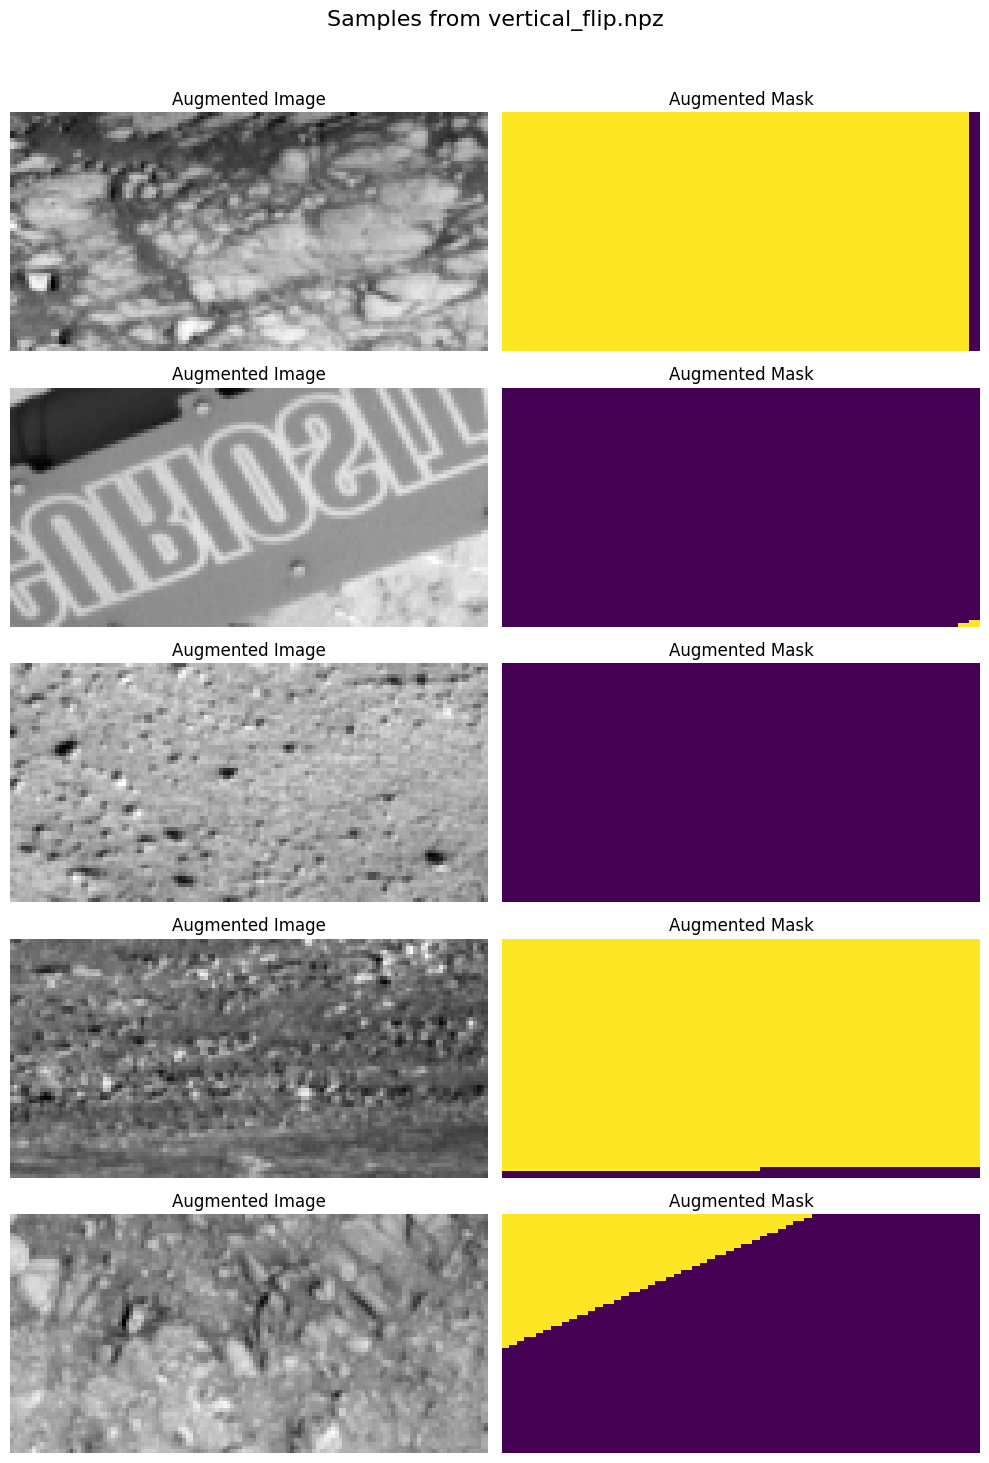

File: noise.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


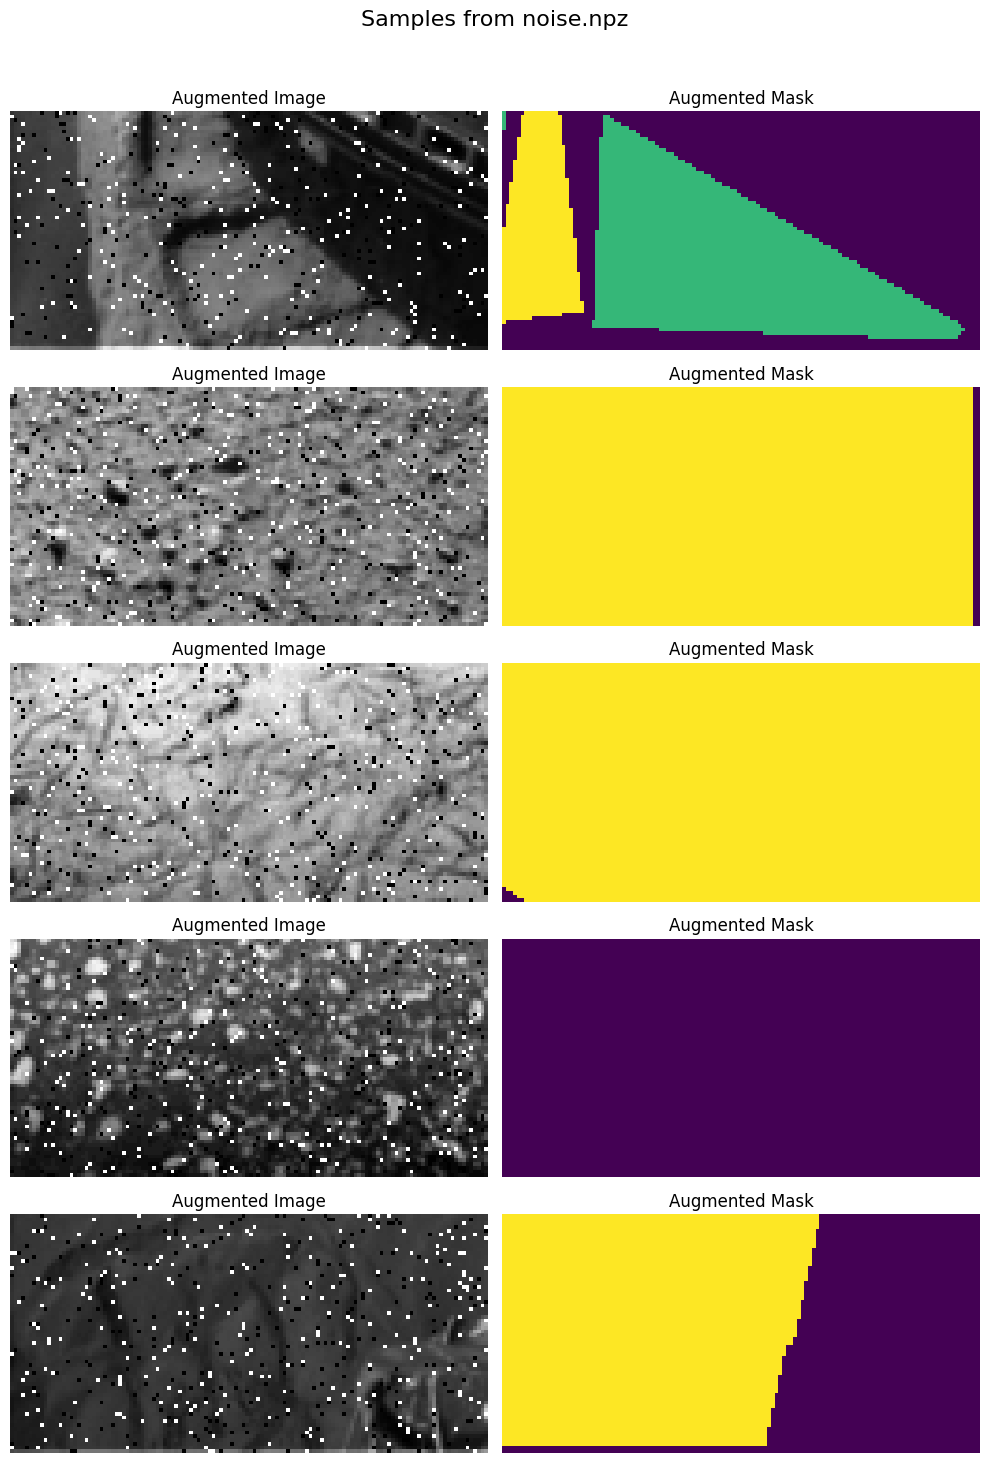

File: horizontal_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


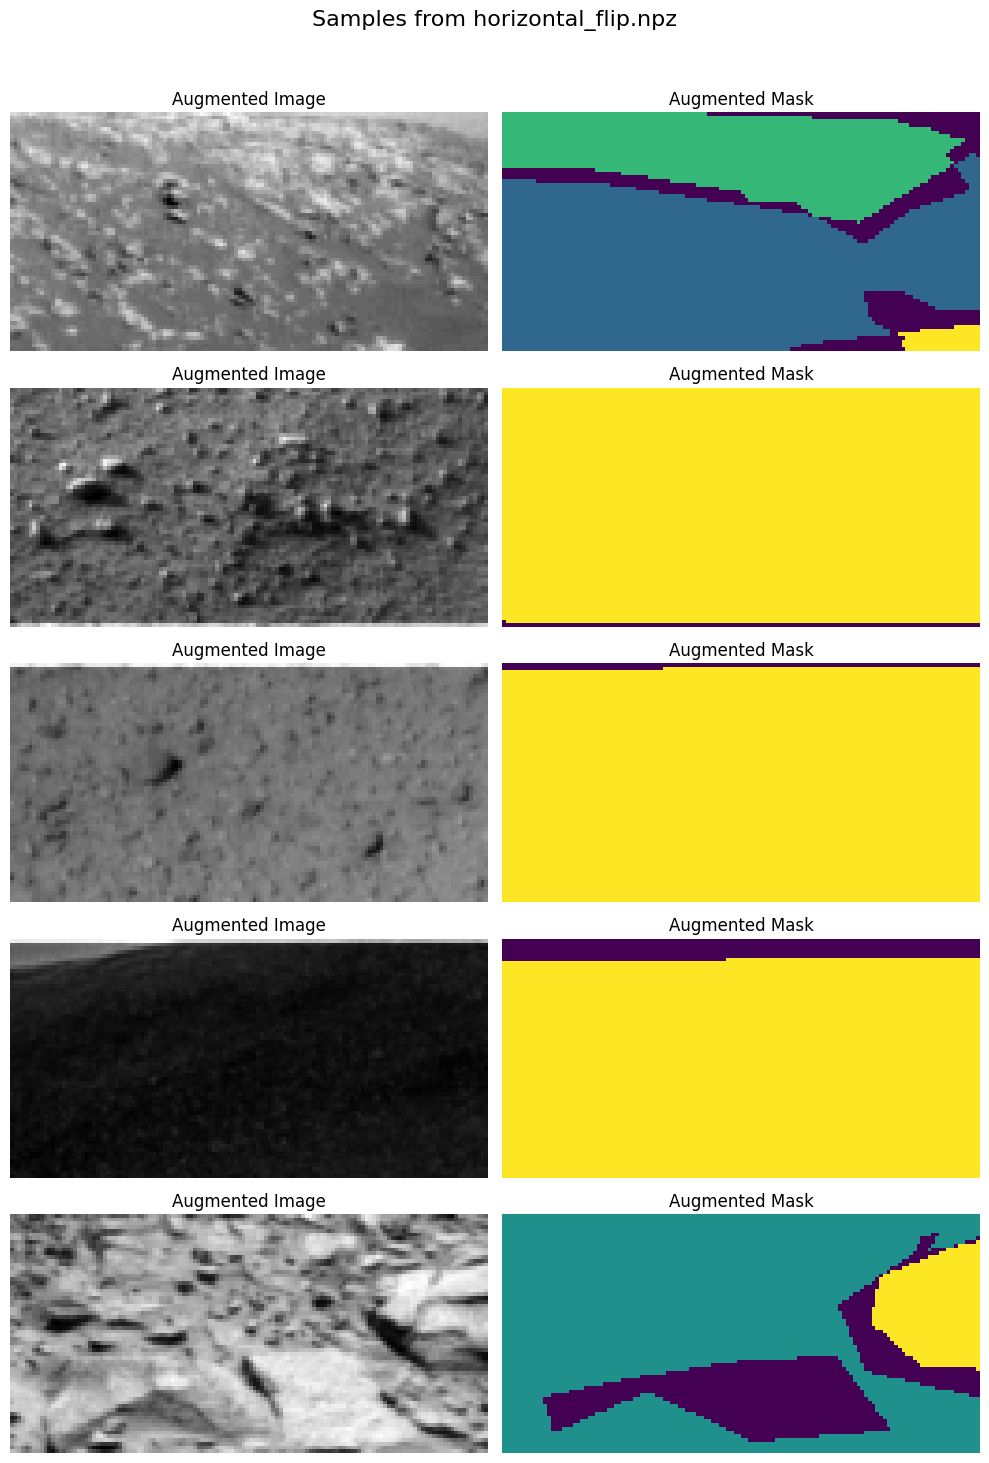

File: invert.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


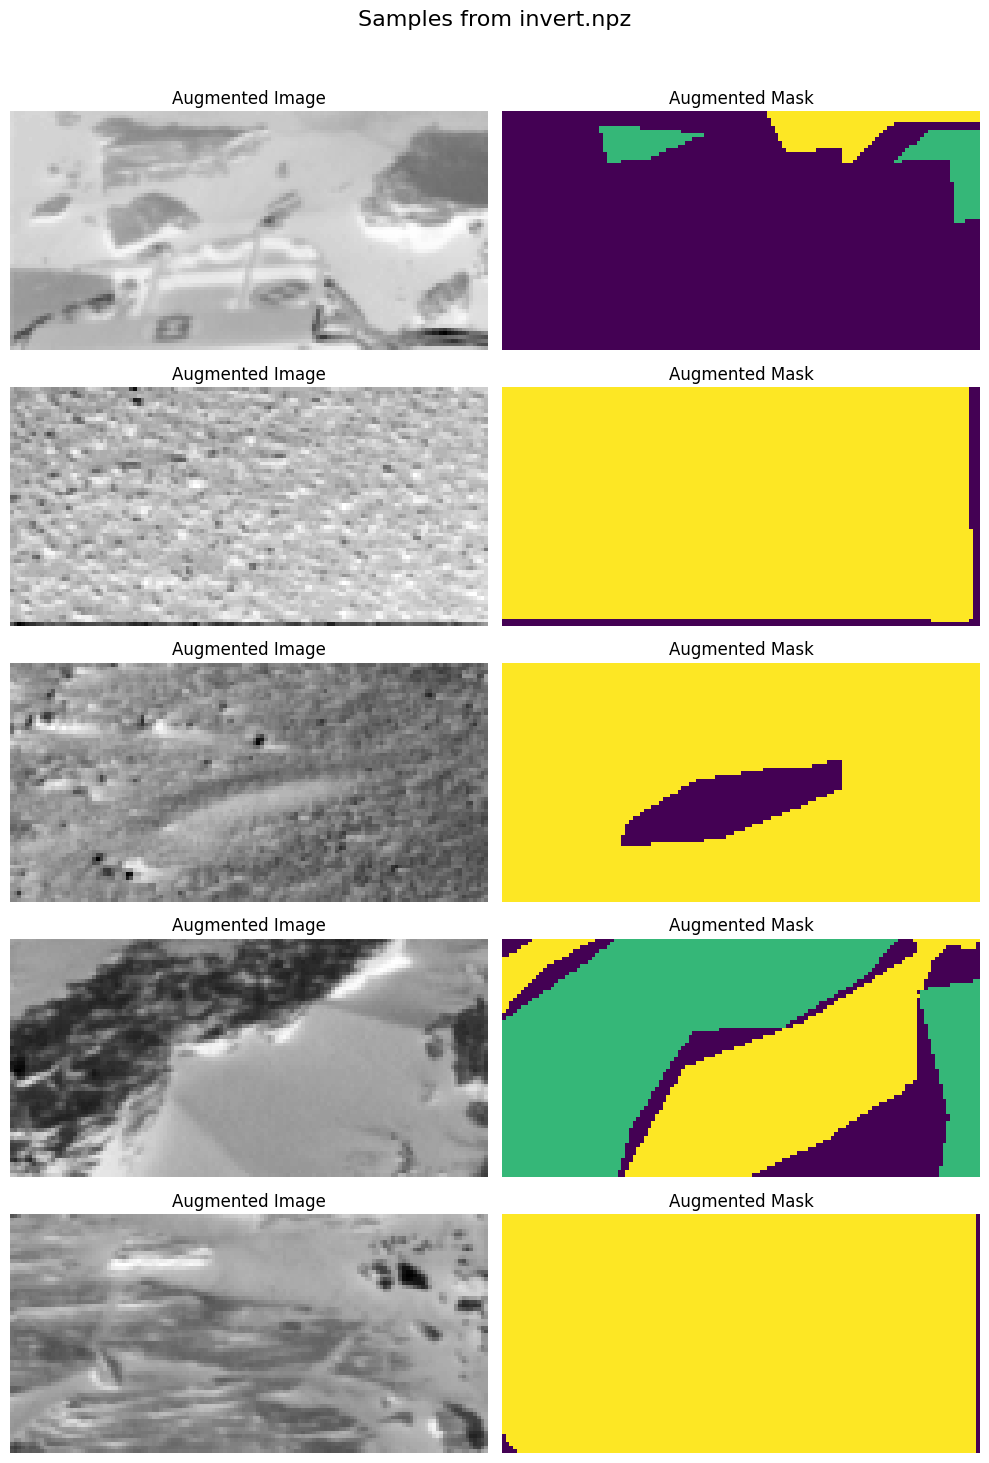

File: rotation_20°.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


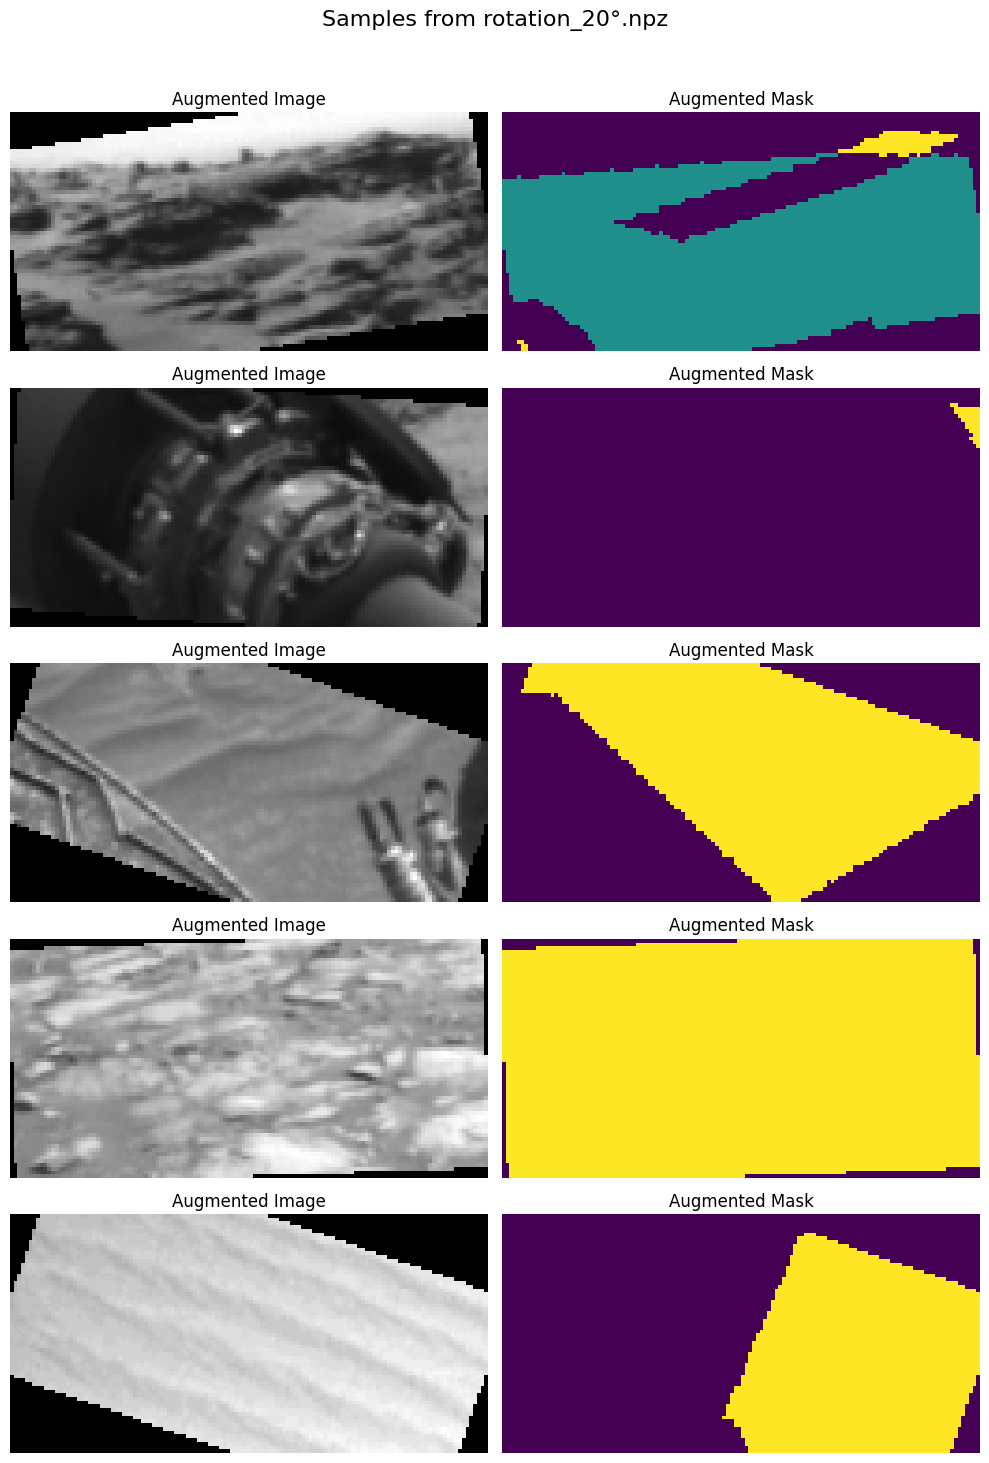

In [10]:
# Read the saved files and display details
output_dir="/kaggle/working/augmented_data"
for file_name in os.listdir(output_dir):
    if file_name.endswith(".npz"):
        file_path = os.path.join(output_dir, file_name)
        data = np.load(file_path)

        # Display keys and their shapes
        print(f"File: {file_name}")
        for key in data.keys():
            print(f"  Key: {key}, Shape: {data[key].shape}")

        # Plot 5 random images and masks
        fig, axes = plt.subplots(5, 2, figsize=(10, 15))
        fig.suptitle(f"Samples from {file_name}", fontsize=16)
        for i in range(5):
            random_idx = np.random.randint(data["augmented_images"].shape[0])
            axes[i, 0].imshow(data["augmented_images"][random_idx], cmap="gray")
            axes[i, 0].set_title("Augmented Image")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(data["augmented_masks"][random_idx])
            axes[i, 1].set_title("Augmented Mask")
            axes[i, 1].axis("off")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

## 🛠️ Train and Save the Model

In [11]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/horizontal_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (4008, 64, 128)
New y_train shape: (4008, 64, 128)


In [12]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/vertical_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (6012, 64, 128)
New y_train shape: (6012, 64, 128)


In [13]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/rotation_20°.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (8016, 64, 128)
New y_train shape: (8016, 64, 128)


In [14]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/invert.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (10020, 64, 128)
New y_train shape: (10020, 64, 128)


In [15]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/noise.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (12024, 64, 128)
New y_train shape: (12024, 64, 128)


In [16]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [17]:
X_val = X_val[..., np.newaxis] / 255.0

In [18]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (12024, 64, 128, 1)
X_val shape: (501, 64, 128, 1)
y_train shape: (12024, 64, 128)


In [19]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis")
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis")
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

## Adding advanced tecnics

In [20]:
# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove any singleton dimensions
y_train = np.squeeze(y_train)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

if y_train.ndim == 3:  # Ensure y_train has the correct shape
    y_train = y_train[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

Shape of X_train after reshaping: (12024, 64, 128, 1)
Shape of y_train after reshaping: (12024, 64, 128, 1)


In [21]:
# Ensure the input shape for both images and masks is correct
X_val = np.squeeze(X_val)  # Remove any singleton dimensions
y_val= np.squeeze(y_val)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_val.ndim == 3:  # If missing the channel dimension, add it
    X_val = X_val[..., np.newaxis]

if y_val.ndim == 3:  # Ensure y_train has the correct shape
    y_val = y_val[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_val.shape}")
print(f"Shape of y_train after reshaping: {y_val.shape}")

Shape of X_train after reshaping: (501, 64, 128, 1)
Shape of y_train after reshaping: (501, 64, 128, 1)


In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove singleton dimensions
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

y_train = np.squeeze(y_train)  # Ensure that y_train has the correct shape

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

# Convert y_train to integers for class count
y_train_int = y_train.astype(np.int32)

# Calculate class weights based on pixel proportions
class_pixel_counts = np.bincount(y_train_int.flatten(), minlength=num_classes)  # Count pixels for each class
total_pixels = np.sum(class_pixel_counts)  # Total number of pixels
class_weights = total_pixels / (class_pixel_counts + 1e-6)  # Inverse frequency
class_weights /= np.sum(class_weights)  # Normalize to sum to 1

print(f"Class pixel counts: {class_pixel_counts}")
print(f"Calculated class weights: {class_weights}")

# Updated EarlyStopping with min_delta to ignore minimal improvements
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor loss instead of validation loss
    patience=30,
    restore_best_weights=True,
    min_delta=1e-4  # Minimum change to qualify as an improvement
)


model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",  # Monitor loss instead of validation loss
    save_best_only=True,
    mode="min",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor loss instead of validation loss
    factor=0.5,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-6
)

# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_val, y_val, num_images=2)




Shape of X_train after reshaping: (12024, 64, 128, 1)
Shape of y_train after reshaping: (12024, 64, 128)
Class pixel counts: [25080450 32652638 23178115 17464095   125310]
Calculated class weights: [0.00489157 0.00375721 0.00529304 0.00702485 0.97903334]


In [23]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [24]:
from tensorflow.keras.callbacks import Callback
class SaveBestMeanIoU(Callback):
    def __init__(self, filepath, monitor="val_mean_io_u", mode="max", verbose=1):
        super(SaveBestMeanIoU, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose
        self.best = -float("inf") if mode == "max" else float("inf")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Debug: Print available keys in logs
        print(f"Available log keys: {logs.keys()}")
        
        # Use the correct log key
        current = logs.get(self.monitor)
        if current is None:
            if self.verbose > 0:
                print(f"Warning: Monitor '{self.monitor}' is not available in logs.")
            return

        if (self.mode == "max" and current > self.best) or (self.mode == "min" and current < self.best):
            self.best = current
            if self.verbose > 0:
                print(f"Epoch {epoch + 1}: {self.monitor} improved to {current:.4f}, saving model.")
            self.model.save(self.filepath)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 128,   │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │        128 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 128,   │          0 │ conv2d_1[0][0],   │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 64,    │    147,584 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 64,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 64,    │          0 │ conv2d_4[0][0],   │
│                     │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 32,    │          0 │ add_1[0][0]       │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 32,    │     33,024 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 16, 32,    │          0 │ conv2d_7[0][0],   │
│                     │ 256)              │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 16,     │          0 │ add_2[0][0]       │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 16,     │  1,180,160 │ max_pooling2d_2[

 Total params: 8,041,989 (30.68 MB)

 Trainable params: 8,041,989 (30.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


I0000 00:00:1733499719.750910      94 service.cc:145] XLA service 0x7e1a100248d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733499719.750959      94 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733499719.750963      94 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1733499722.679444      94 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1733499750.351045      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/376 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.3571 - loss: 1.3851 - mean_io_u: 0.0860 - mean_iou: 0.0860

W0000 00:00:1733499818.058017      95 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-12-06 15:44:02.255357: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=2} for conv (f32[256,512,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,512,16,32]{3,2,1,0}, f32[24,256,16,32]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-06 15:44:02.384991: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.1298139s
Trying algorithm eng18{k11=2} for conv (f32[256,512,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,512,16,32]{3,2,1,0}, f32[24,256,16,32]{

376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.3572 - loss: 1.3850 - mean_io_u: 0.0860 - mean_iou: 0.0860

W0000 00:00:1733499852.800762      95 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733499856.517405      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 1: val_mean_iou improved to 0.2257, saving model.

Epoch 1: val_loss improved from inf to 1.20608, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


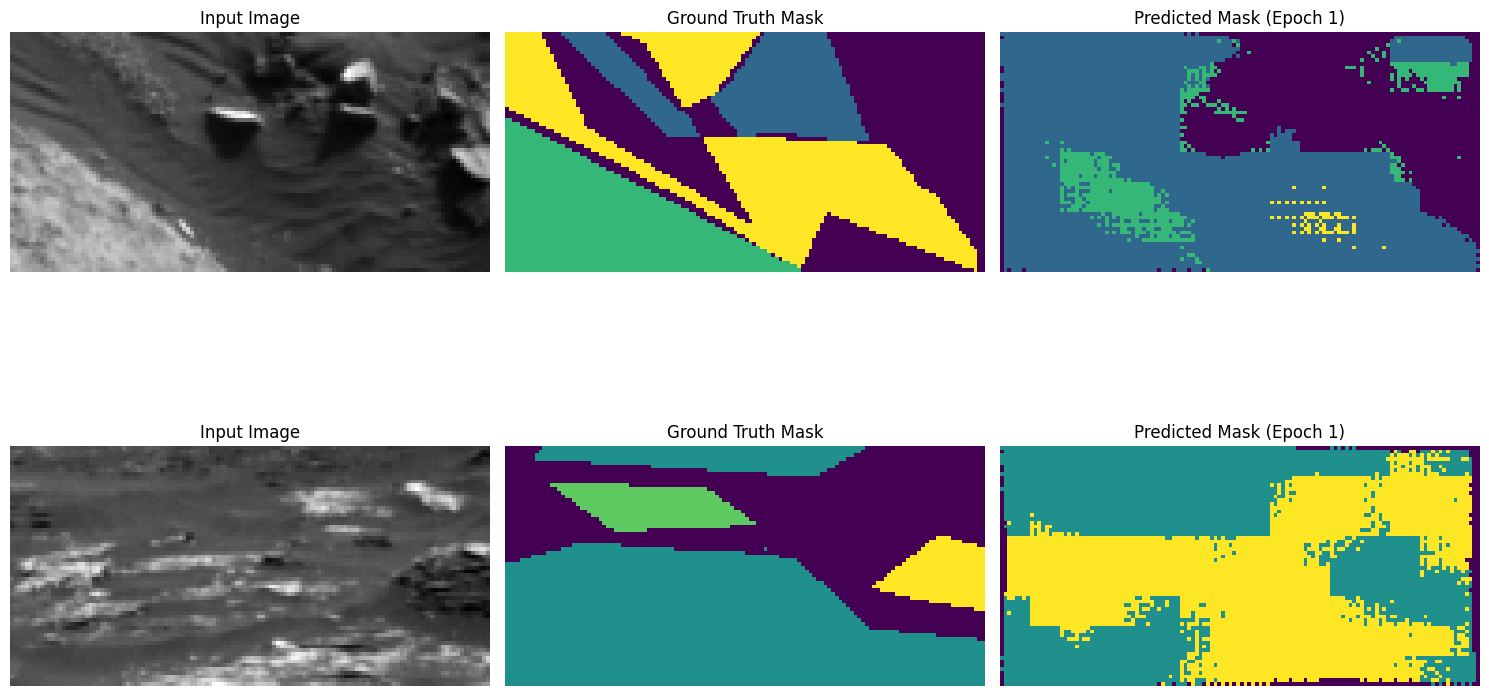

376/376 ━━━━━━━━━━━━━━━━━━━━ 156s 318ms/step - accuracy: 0.3572 - loss: 1.3848 - mean_io_u: 0.0860 - mean_iou: 0.0860 - val_accuracy: 0.4607 - val_loss: 1.2061 - val_mean_io_u: 0.2257 - val_mean_iou: 0.2257 - learning_rate: 1.0000e-04
Epoch 2/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.4424 - loss: 1.2219 - mean_io_u: 0.1849 - mean_iou: 0.1849Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 2: val_mean_iou improved to 0.3100, saving model.

Epoch 2: val_loss improved from 1.20608 to 1.00559, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


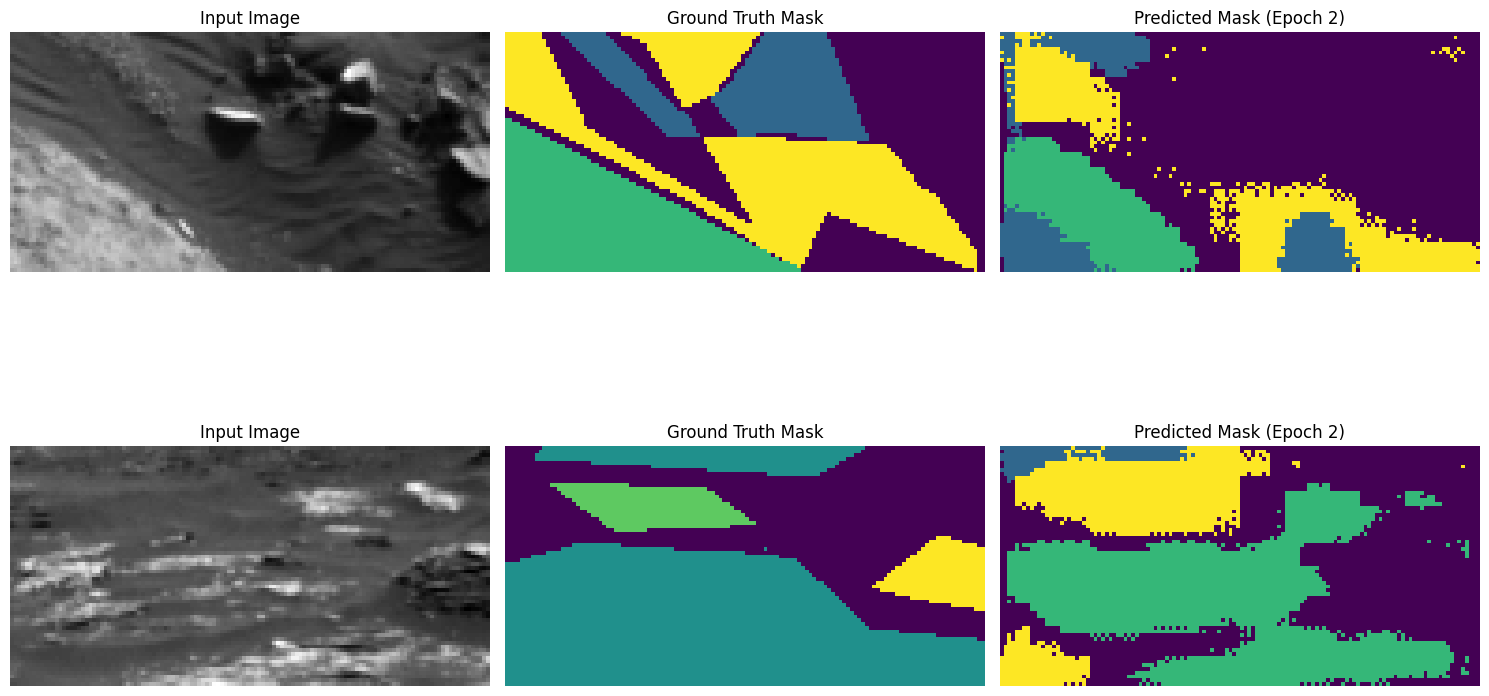

376/376 ━━━━━━━━━━━━━━━━━━━━ 84s 222ms/step - accuracy: 0.4425 - loss: 1.2217 - mean_io_u: 0.1849 - mean_iou: 0.1849 - val_accuracy: 0.5994 - val_loss: 1.0056 - val_mean_io_u: 0.3100 - val_mean_iou: 0.3100 - learning_rate: 1.0000e-04
Epoch 3/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5433 - loss: 1.0762 - mean_io_u: 0.2652 - mean_iou: 0.2652Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 3: val_mean_iou improved to 0.3624, saving model.

Epoch 3: val_loss improved from 1.00559 to 0.91067, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


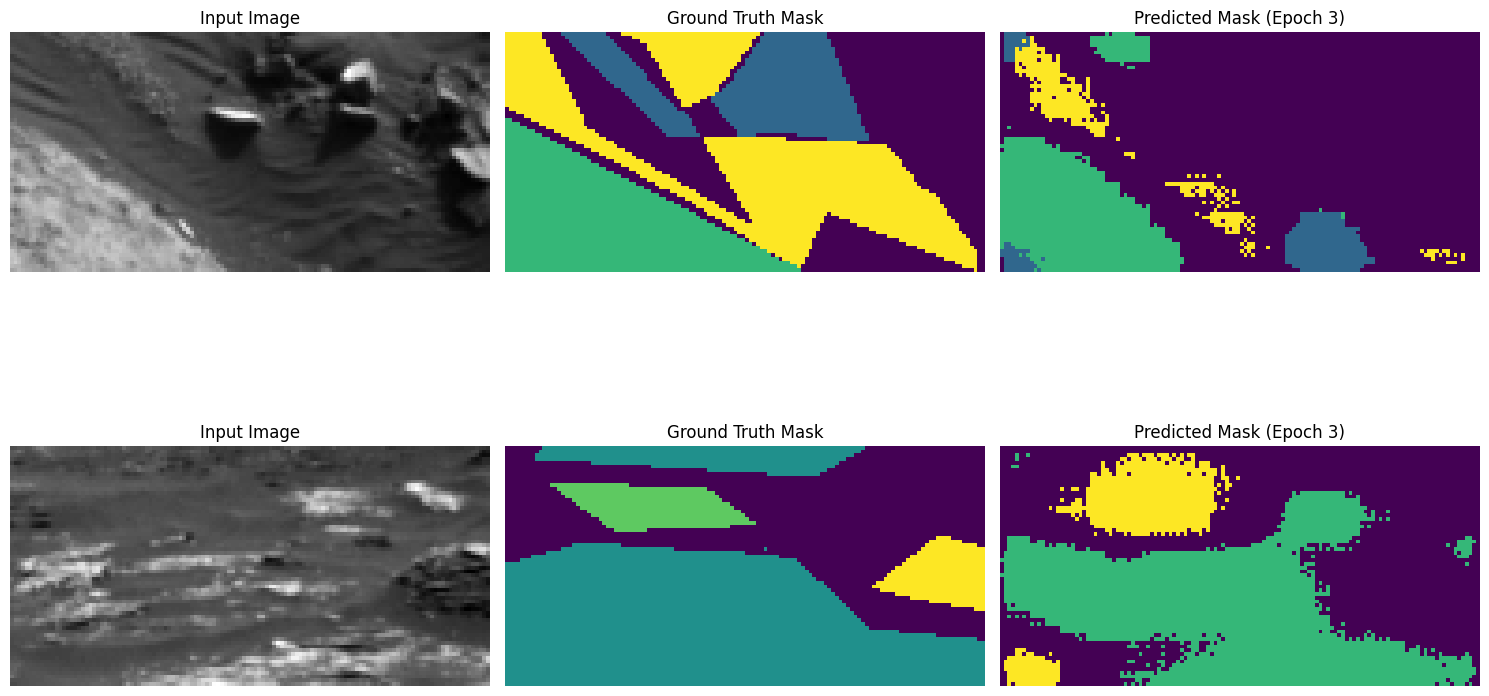

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 221ms/step - accuracy: 0.5434 - loss: 1.0761 - mean_io_u: 0.2652 - mean_iou: 0.2652 - val_accuracy: 0.6503 - val_loss: 0.9107 - val_mean_io_u: 0.3624 - val_mean_iou: 0.3624 - learning_rate: 1.0000e-04
Epoch 4/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5883 - loss: 0.9953 - mean_io_u: 0.2993 - mean_iou: 0.2993Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 4: val_mean_iou improved to 0.3711, saving model.

Epoch 4: val_loss improved from 0.91067 to 0.87471, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


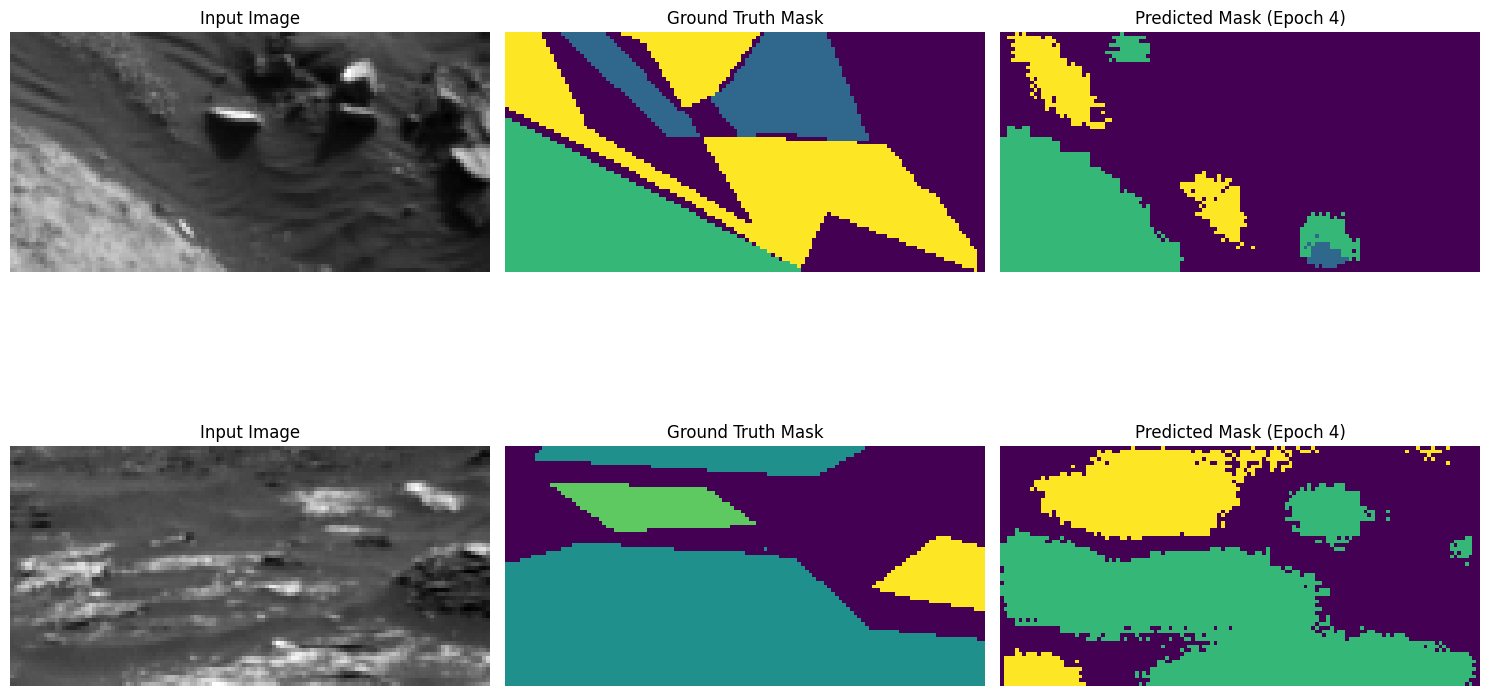

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - accuracy: 0.5883 - loss: 0.9952 - mean_io_u: 0.2993 - mean_iou: 0.2993 - val_accuracy: 0.6622 - val_loss: 0.8747 - val_mean_io_u: 0.3711 - val_mean_iou: 0.3711 - learning_rate: 1.0000e-04
Epoch 5/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6236 - loss: 0.9322 - mean_io_u: 0.3275 - mean_iou: 0.3275Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 5: val_mean_iou improved to 0.3932, saving model.

Epoch 5: val_loss improved from 0.87471 to 0.81536, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


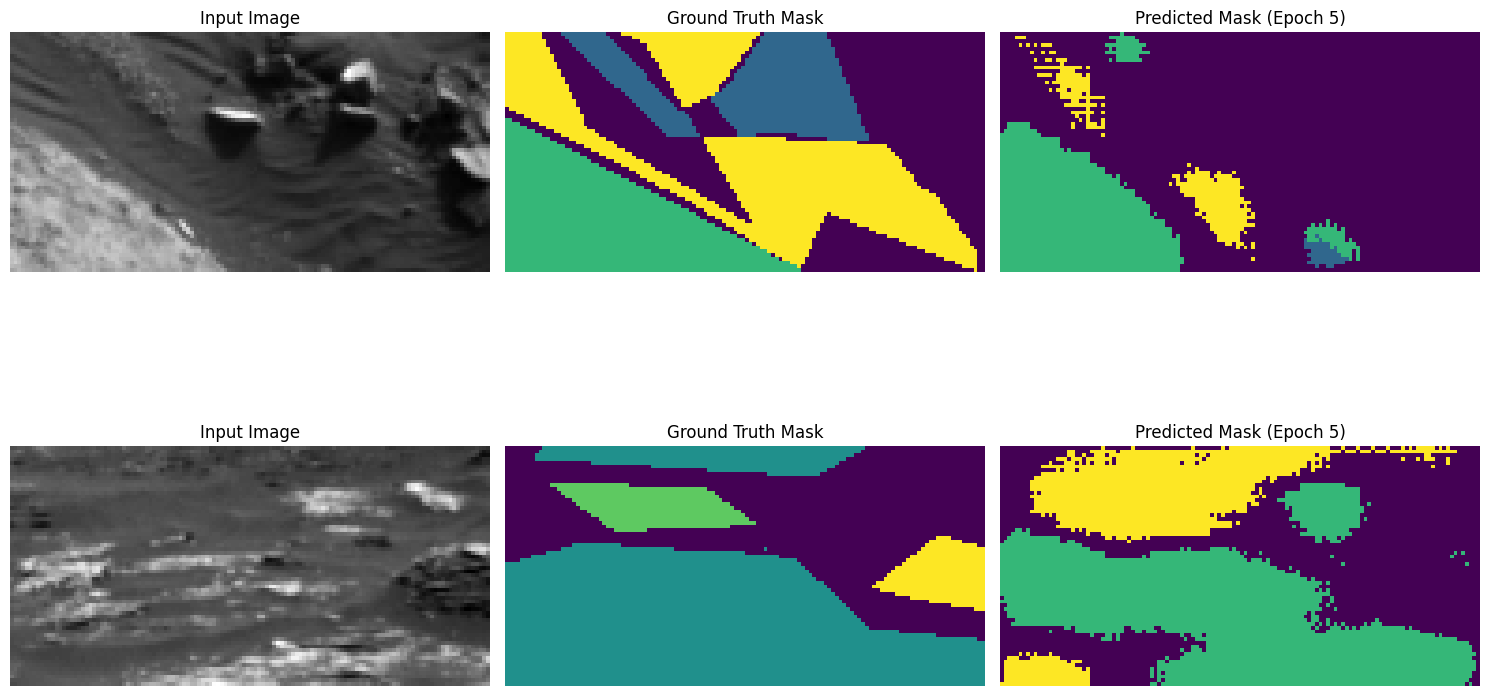

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.6237 - loss: 0.9321 - mean_io_u: 0.3275 - mean_iou: 0.3275 - val_accuracy: 0.6905 - val_loss: 0.8154 - val_mean_io_u: 0.3932 - val_mean_iou: 0.3932 - learning_rate: 1.0000e-04
Epoch 6/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6476 - loss: 0.8810 - mean_io_u: 0.3457 - mean_iou: 0.3457Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 6: val_mean_iou improved to 0.3989, saving model.

Epoch 6: val_loss improved from 0.81536 to 0.79466, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


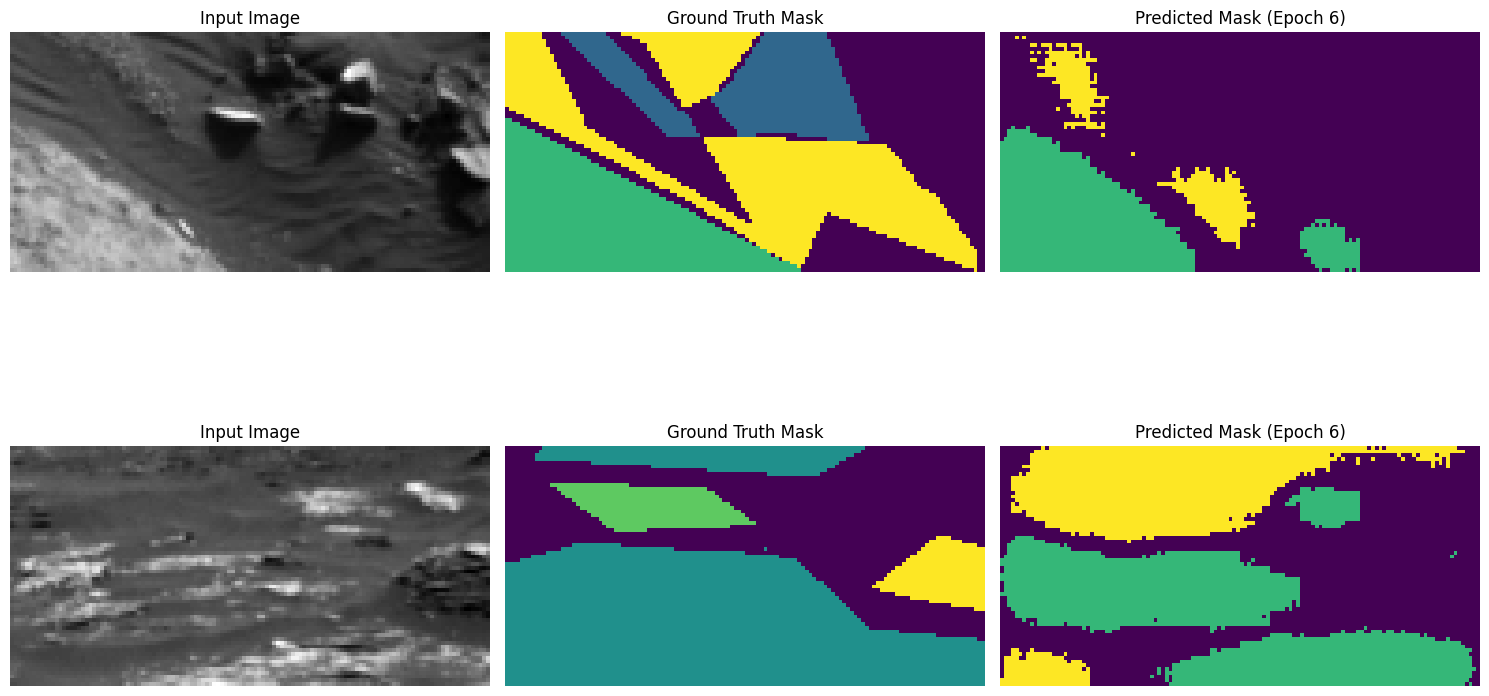

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 222ms/step - accuracy: 0.6476 - loss: 0.8809 - mean_io_u: 0.3457 - mean_iou: 0.3457 - val_accuracy: 0.6991 - val_loss: 0.7947 - val_mean_io_u: 0.3989 - val_mean_iou: 0.3989 - learning_rate: 1.0000e-04
Epoch 7/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6691 - loss: 0.8328 - mean_io_u: 0.3636 - mean_iou: 0.3636Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 7: val_mean_iou improved to 0.4110, saving model.

Epoch 7: val_loss improved from 0.79466 to 0.76354, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


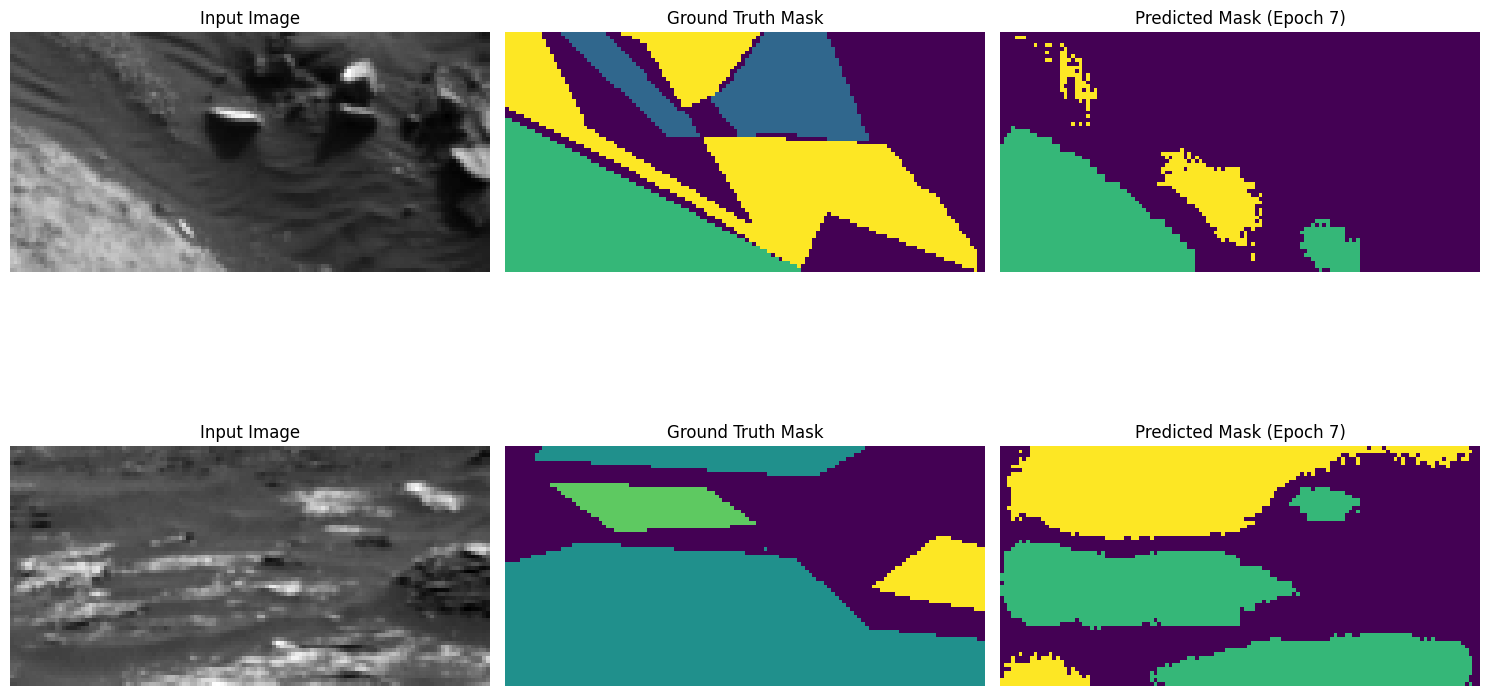

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.6691 - loss: 0.8327 - mean_io_u: 0.3636 - mean_iou: 0.3636 - val_accuracy: 0.7143 - val_loss: 0.7635 - val_mean_io_u: 0.4110 - val_mean_iou: 0.4110 - learning_rate: 1.0000e-04
Epoch 8/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6805 - loss: 0.8027 - mean_io_u: 0.3725 - mean_iou: 0.3725Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 8: val_mean_iou improved to 0.4202, saving model.

Epoch 8: val_loss improved from 0.76354 to 0.74263, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


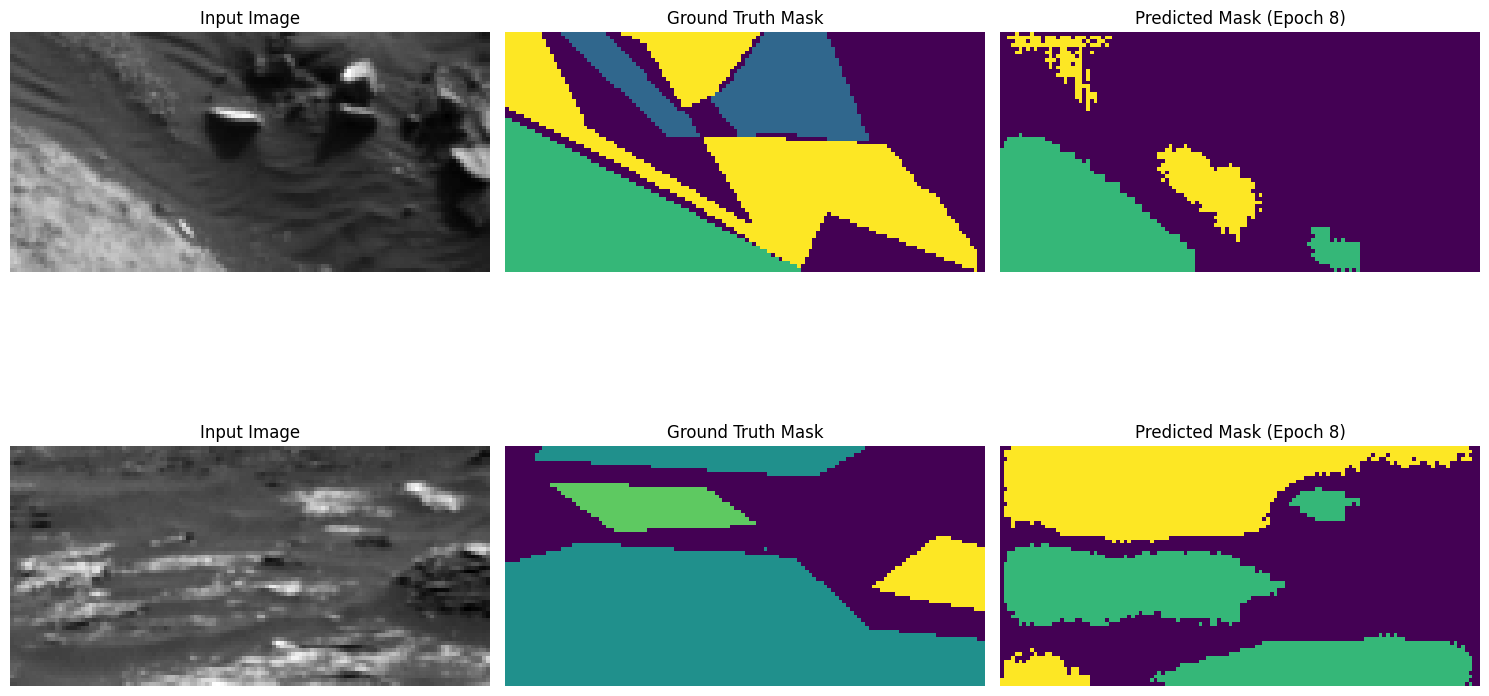

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 222ms/step - accuracy: 0.6805 - loss: 0.8026 - mean_io_u: 0.3725 - mean_iou: 0.3725 - val_accuracy: 0.7226 - val_loss: 0.7426 - val_mean_io_u: 0.4202 - val_mean_iou: 0.4202 - learning_rate: 1.0000e-04
Epoch 9/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6970 - loss: 0.7650 - mean_io_u: 0.3889 - mean_iou: 0.3889Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 9: val_mean_iou improved to 0.4282, saving model.

Epoch 9: val_loss improved from 0.74263 to 0.72961, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


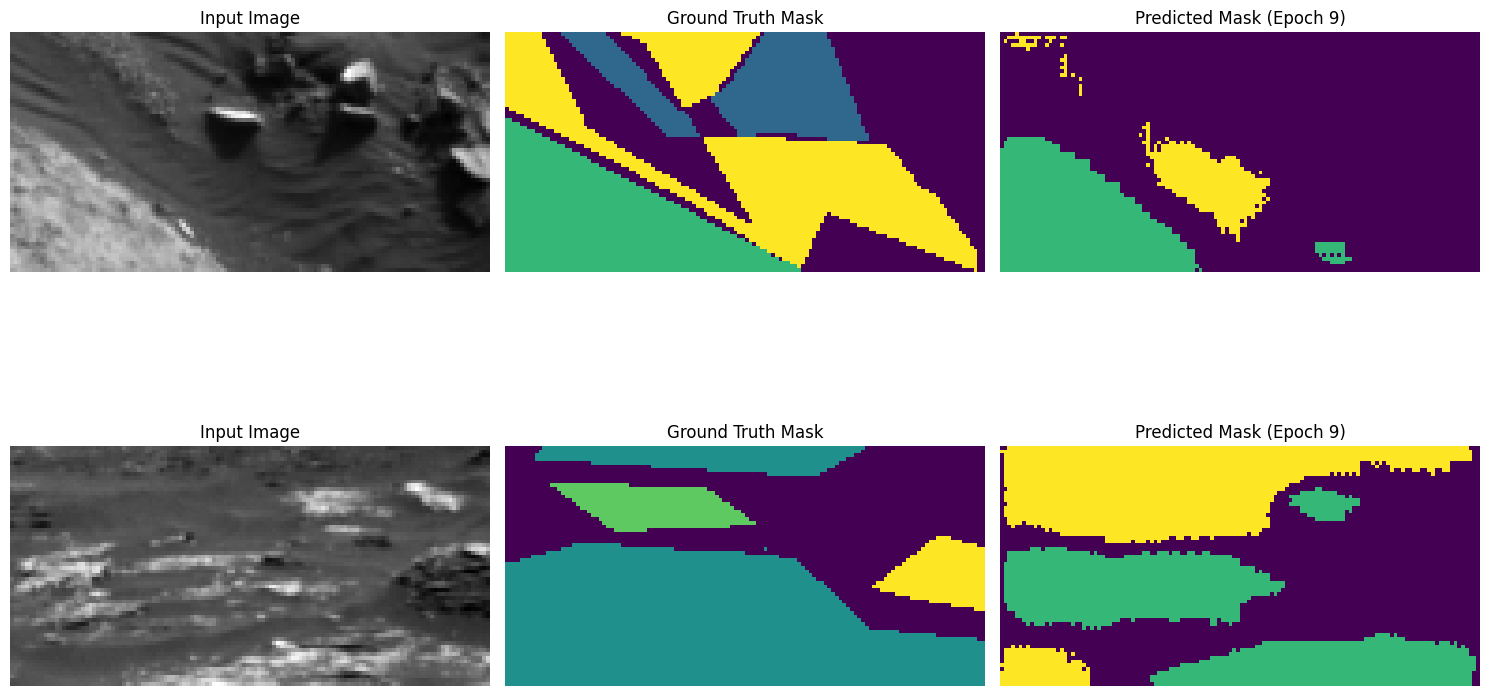

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.6970 - loss: 0.7649 - mean_io_u: 0.3888 - mean_iou: 0.3888 - val_accuracy: 0.7290 - val_loss: 0.7296 - val_mean_io_u: 0.4282 - val_mean_iou: 0.4282 - learning_rate: 1.0000e-04
Epoch 10/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7082 - loss: 0.7375 - mean_io_u: 0.3993 - mean_iou: 0.3993Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 10: val_mean_iou improved to 0.4292, saving model.

Epoch 10: val_loss improved from 0.72961 to 0.70752, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


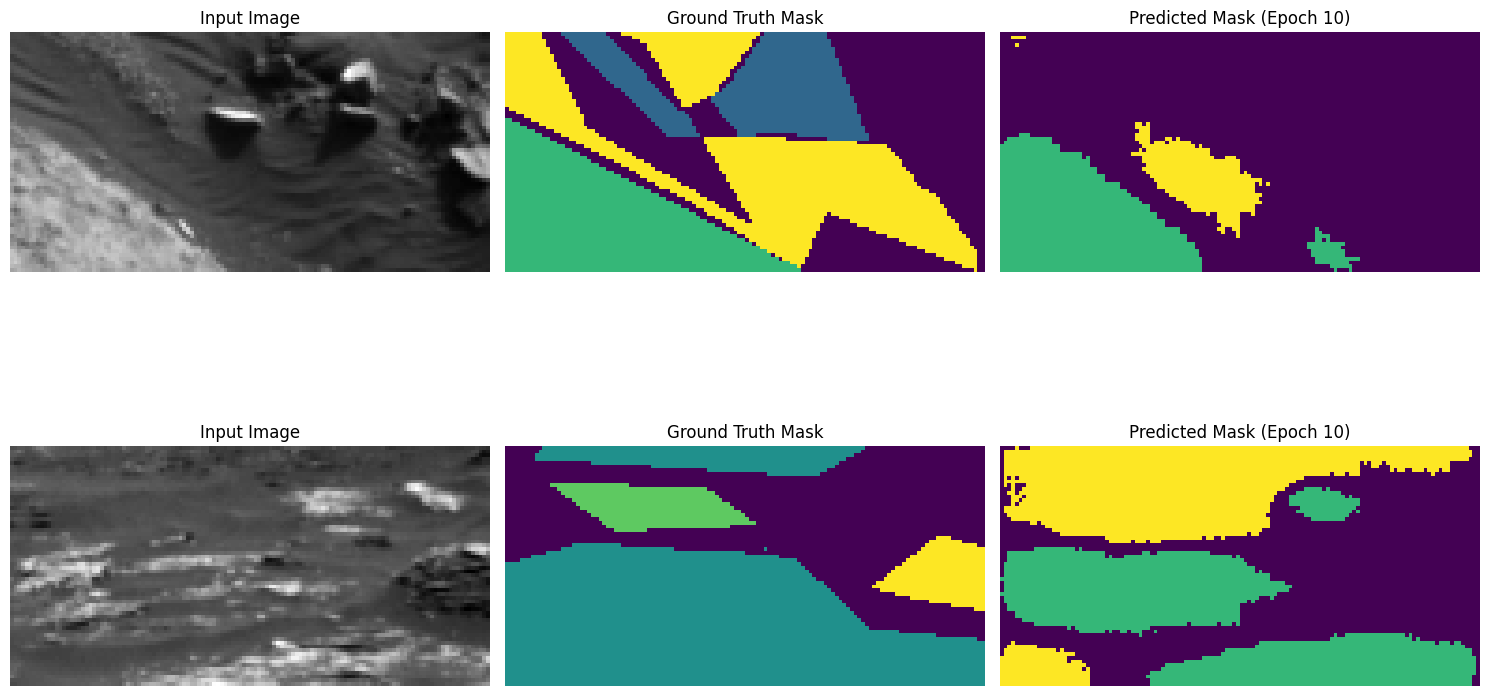

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 221ms/step - accuracy: 0.7082 - loss: 0.7375 - mean_io_u: 0.3993 - mean_iou: 0.3993 - val_accuracy: 0.7322 - val_loss: 0.7075 - val_mean_io_u: 0.4292 - val_mean_iou: 0.4292 - learning_rate: 1.0000e-04
Epoch 11/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7181 - loss: 0.7112 - mean_io_u: 0.4088 - mean_iou: 0.4088Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 11: val_mean_iou improved to 0.4304, saving model.

Epoch 11: val_loss improved from 0.70752 to 0.69516, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


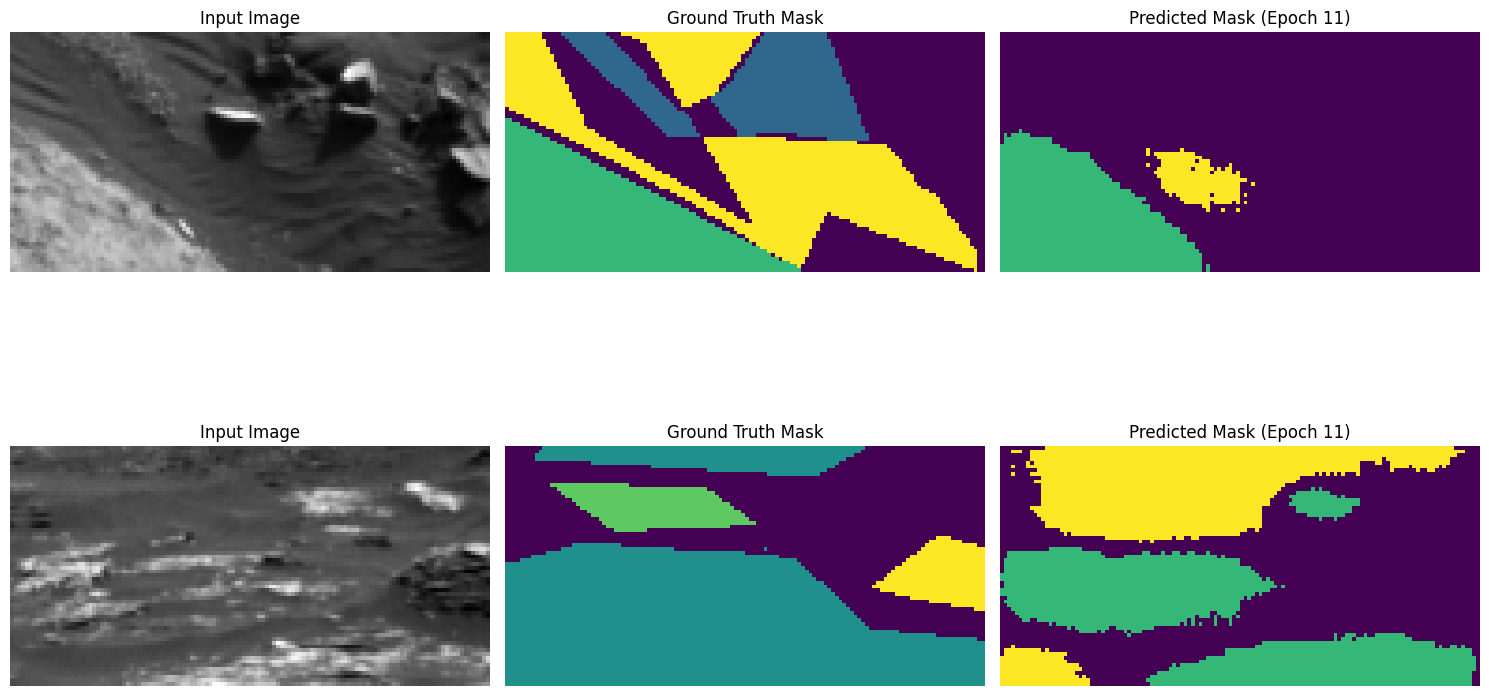

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.7181 - loss: 0.7111 - mean_io_u: 0.4088 - mean_iou: 0.4088 - val_accuracy: 0.7368 - val_loss: 0.6952 - val_mean_io_u: 0.4304 - val_mean_iou: 0.4304 - learning_rate: 1.0000e-04
Epoch 12/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7258 - loss: 0.6942 - mean_io_u: 0.4160 - mean_iou: 0.4160Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 12: val_mean_iou improved to 0.4386, saving model.

Epoch 12: val_loss improved from 0.69516 to 0.67311, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


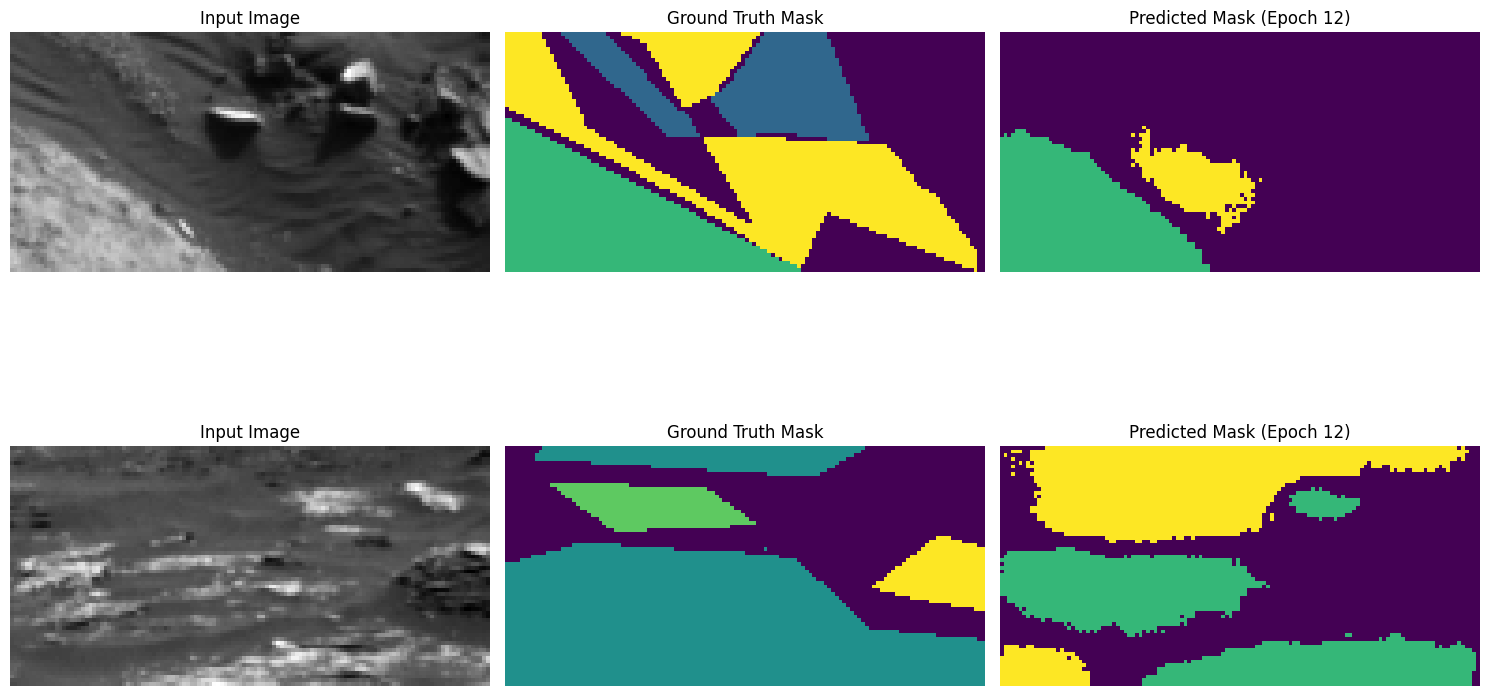

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.7259 - loss: 0.6941 - mean_io_u: 0.4160 - mean_iou: 0.4160 - val_accuracy: 0.7446 - val_loss: 0.6731 - val_mean_io_u: 0.4386 - val_mean_iou: 0.4386 - learning_rate: 1.0000e-04
Epoch 13/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7345 - loss: 0.6737 - mean_io_u: 0.4242 - mean_iou: 0.4242Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 13: val_mean_iou improved to 0.4441, saving model.

Epoch 13: val_loss improved from 0.67311 to 0.66021, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


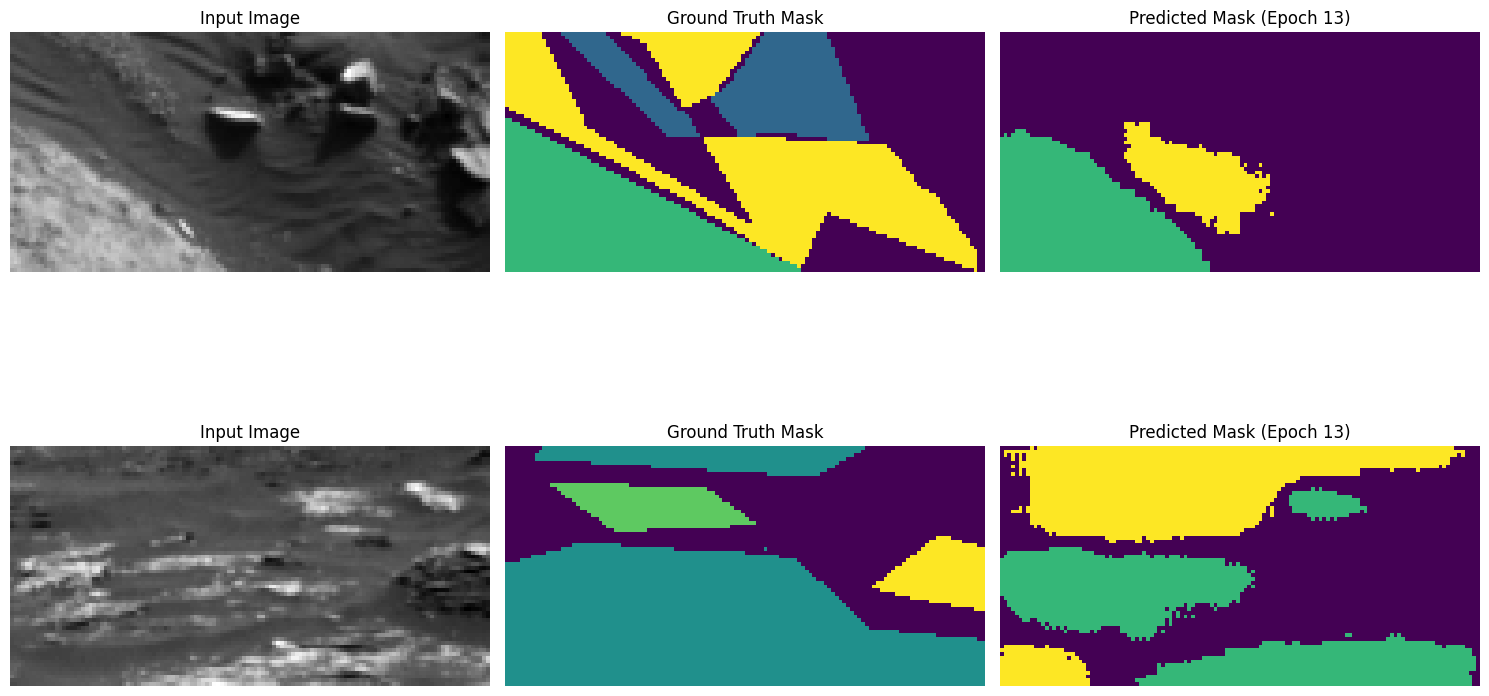

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 221ms/step - accuracy: 0.7346 - loss: 0.6737 - mean_io_u: 0.4242 - mean_iou: 0.4242 - val_accuracy: 0.7497 - val_loss: 0.6602 - val_mean_io_u: 0.4441 - val_mean_iou: 0.4441 - learning_rate: 1.0000e-04
Epoch 14/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7433 - loss: 0.6525 - mean_io_u: 0.4313 - mean_iou: 0.4313Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 14: val_loss did not improve from 0.66021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


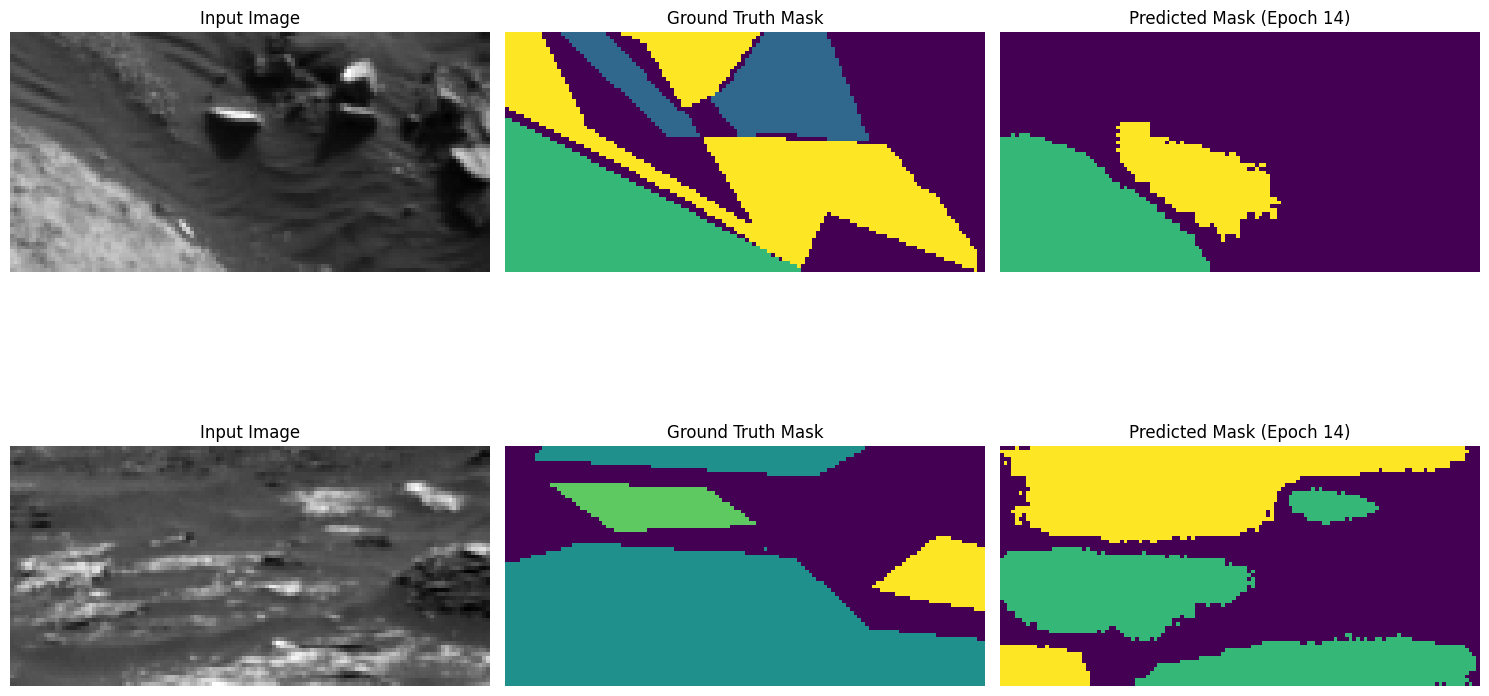

376/376 ━━━━━━━━━━━━━━━━━━━━ 81s 216ms/step - accuracy: 0.7433 - loss: 0.6525 - mean_io_u: 0.4312 - mean_iou: 0.4312 - val_accuracy: 0.7506 - val_loss: 0.6614 - val_mean_io_u: 0.4440 - val_mean_iou: 0.4440 - learning_rate: 1.0000e-04
Epoch 15/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7509 - loss: 0.6342 - mean_io_u: 0.4394 - mean_iou: 0.4394Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 15: val_mean_iou improved to 0.4443, saving model.

Epoch 15: val_loss improved from 0.66021 to 0.65345, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


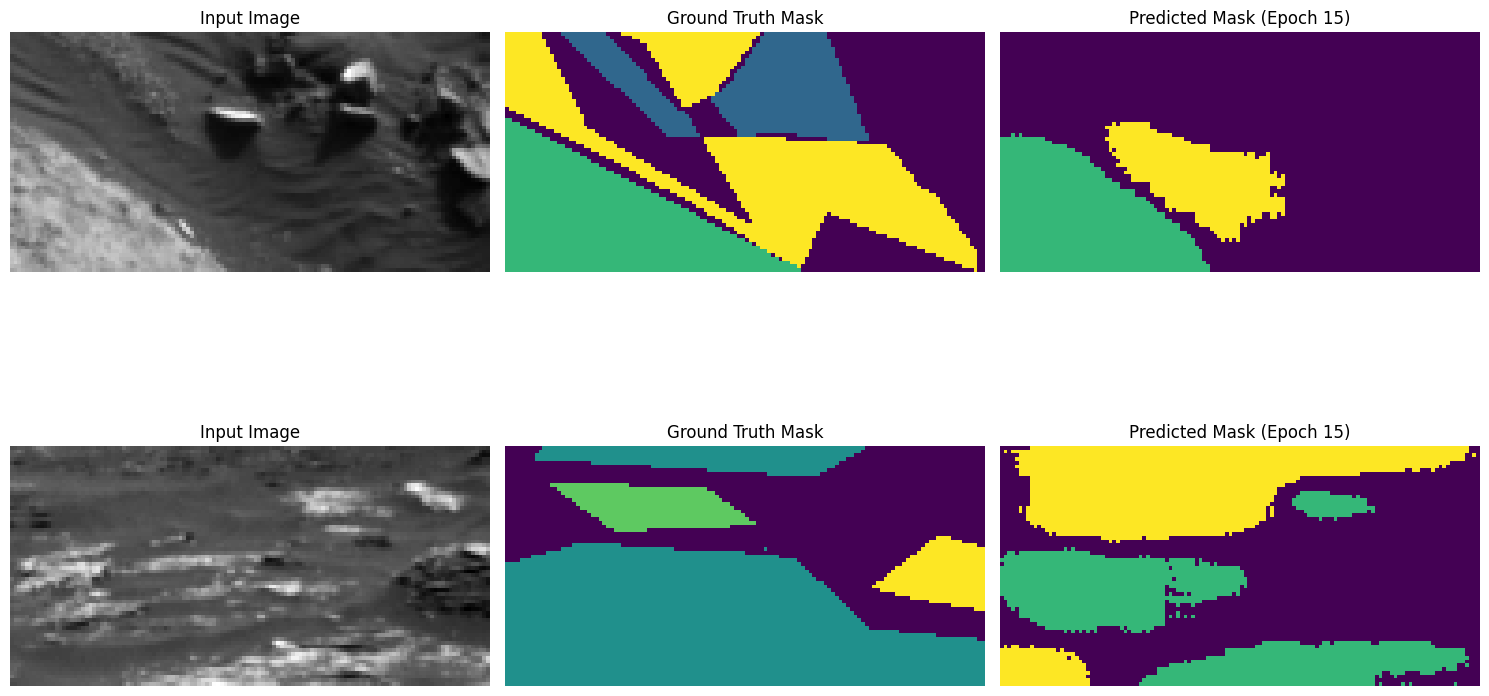

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.7509 - loss: 0.6342 - mean_io_u: 0.4394 - mean_iou: 0.4394 - val_accuracy: 0.7524 - val_loss: 0.6534 - val_mean_io_u: 0.4443 - val_mean_iou: 0.4443 - learning_rate: 1.0000e-04
Epoch 16/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7601 - loss: 0.6134 - mean_io_u: 0.4494 - mean_iou: 0.4494Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 16: val_mean_iou improved to 0.4451, saving model.

Epoch 16: val_loss improved from 0.65345 to 0.65024, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


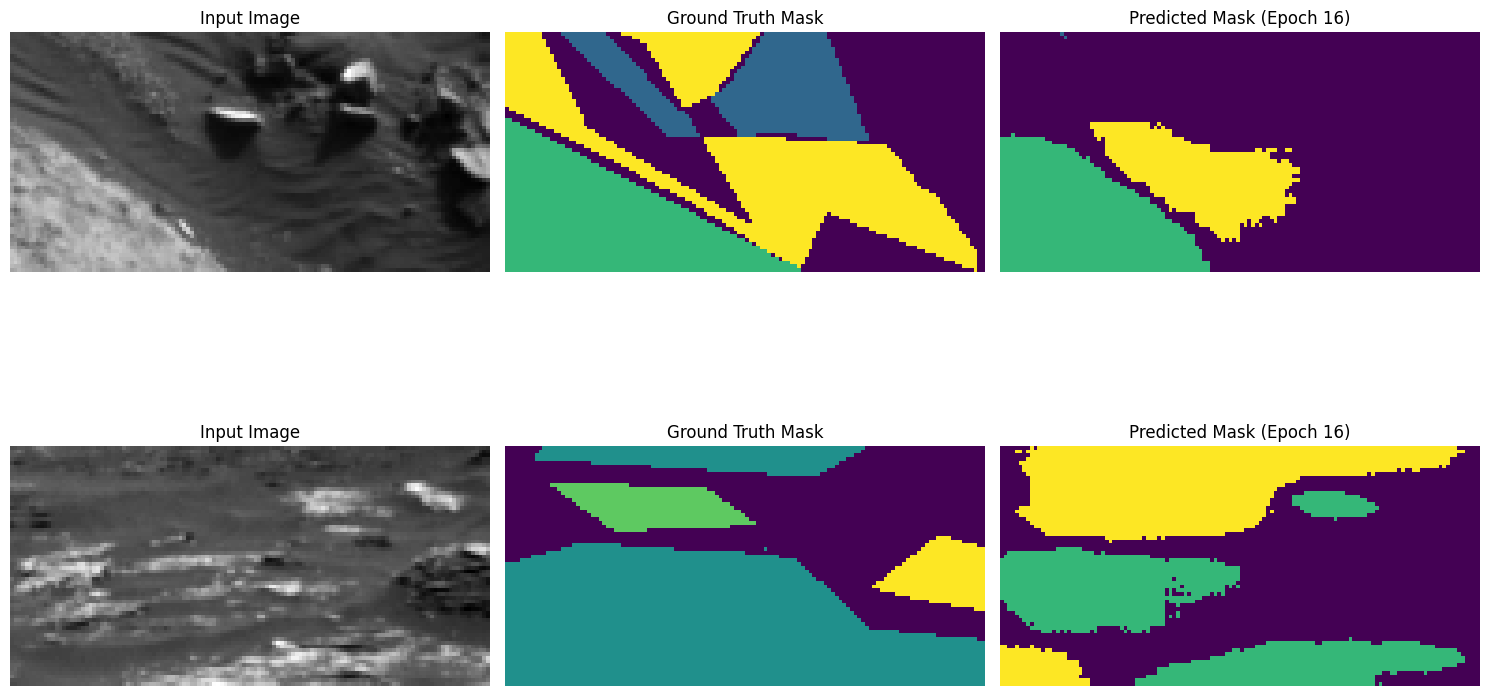

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.7602 - loss: 0.6133 - mean_io_u: 0.4494 - mean_iou: 0.4494 - val_accuracy: 0.7546 - val_loss: 0.6502 - val_mean_io_u: 0.4451 - val_mean_iou: 0.4451 - learning_rate: 1.0000e-04
Epoch 17/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7664 - loss: 0.5971 - mean_io_u: 0.4563 - mean_iou: 0.4563Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 17: val_loss did not improve from 0.65024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


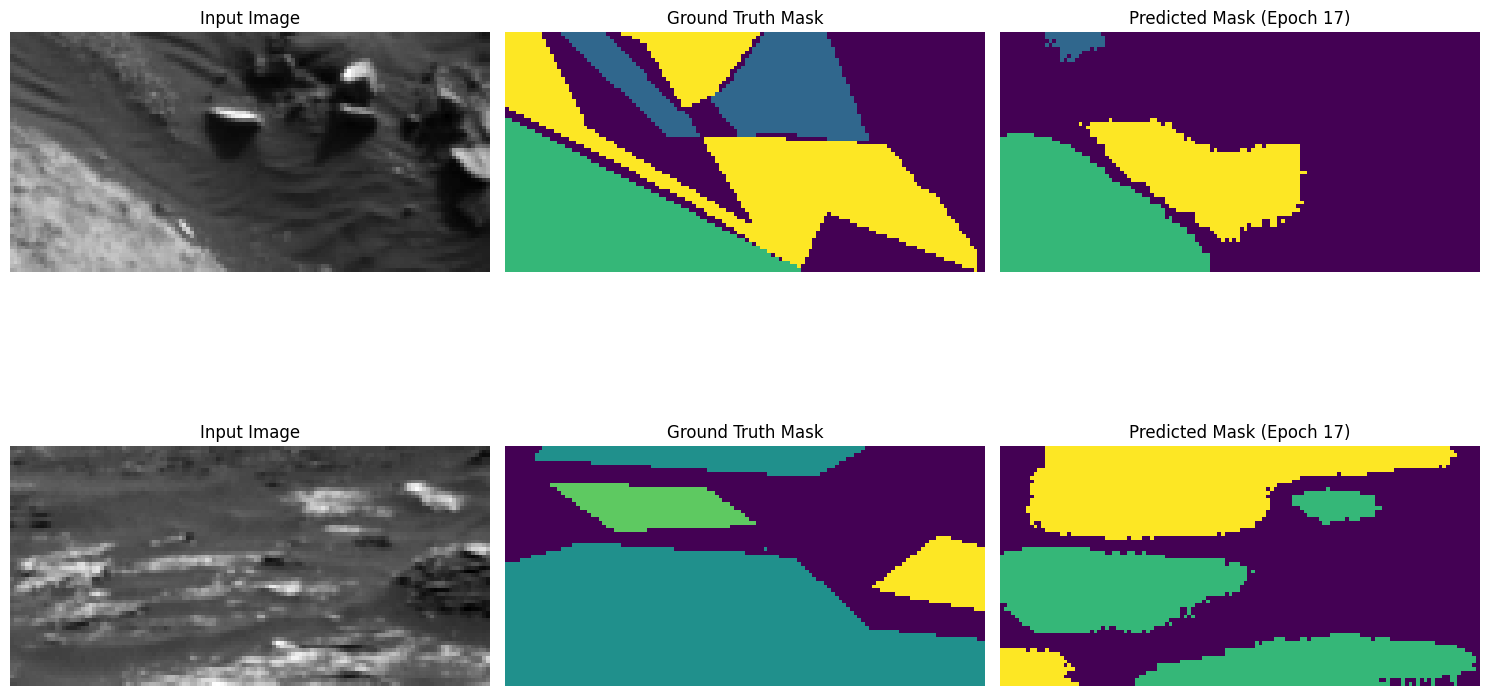

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.7664 - loss: 0.5971 - mean_io_u: 0.4562 - mean_iou: 0.4562 - val_accuracy: 0.7528 - val_loss: 0.6630 - val_mean_io_u: 0.4417 - val_mean_iou: 0.4417 - learning_rate: 1.0000e-04
Epoch 18/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7709 - loss: 0.5855 - mean_io_u: 0.4609 - mean_iou: 0.4609Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 18: val_mean_iou improved to 0.4469, saving model.

Epoch 18: val_loss did not improve from 0.65024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


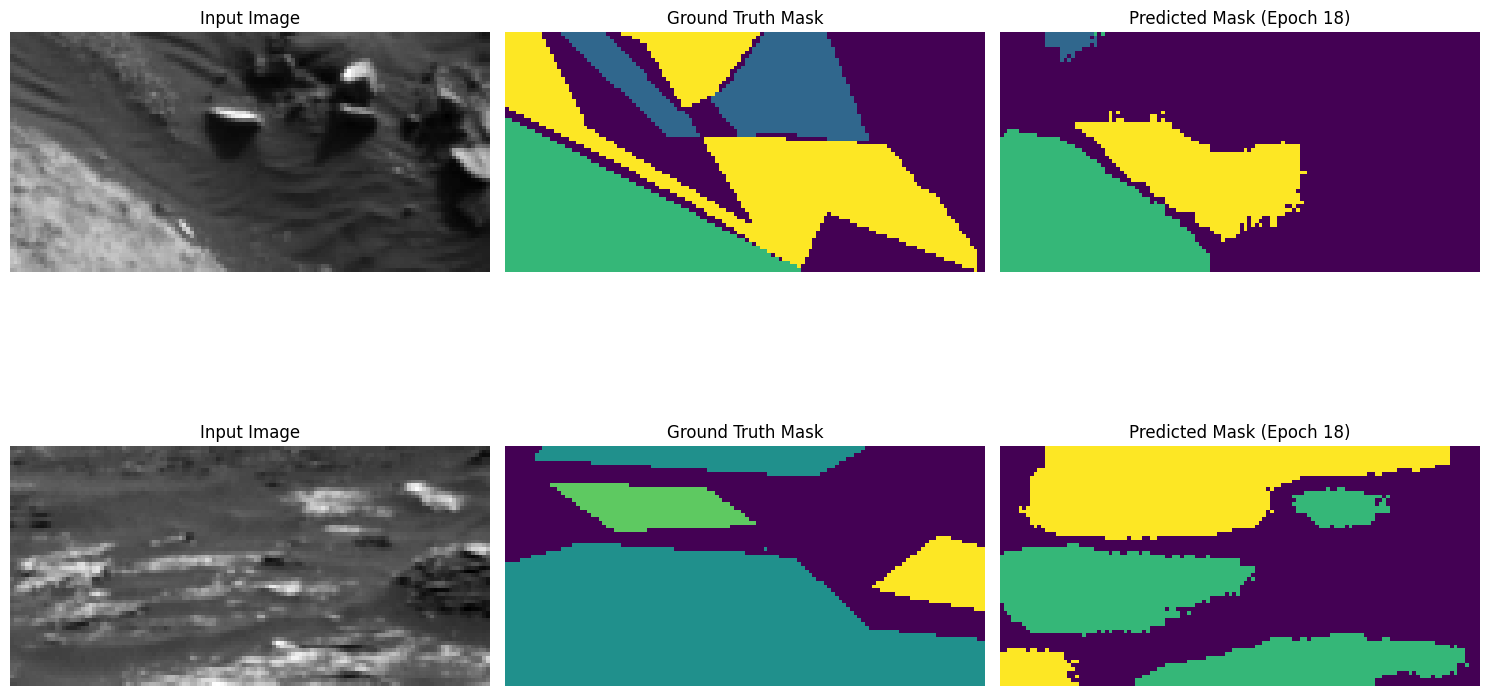

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 217ms/step - accuracy: 0.7709 - loss: 0.5855 - mean_io_u: 0.4609 - mean_iou: 0.4609 - val_accuracy: 0.7569 - val_loss: 0.6539 - val_mean_io_u: 0.4469 - val_mean_iou: 0.4469 - learning_rate: 1.0000e-04
Epoch 19/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7797 - loss: 0.5640 - mean_io_u: 0.4710 - mean_iou: 0.4710Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 19: val_mean_iou improved to 0.4495, saving model.

Epoch 19: val_loss improved from 0.65024 to 0.64995, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


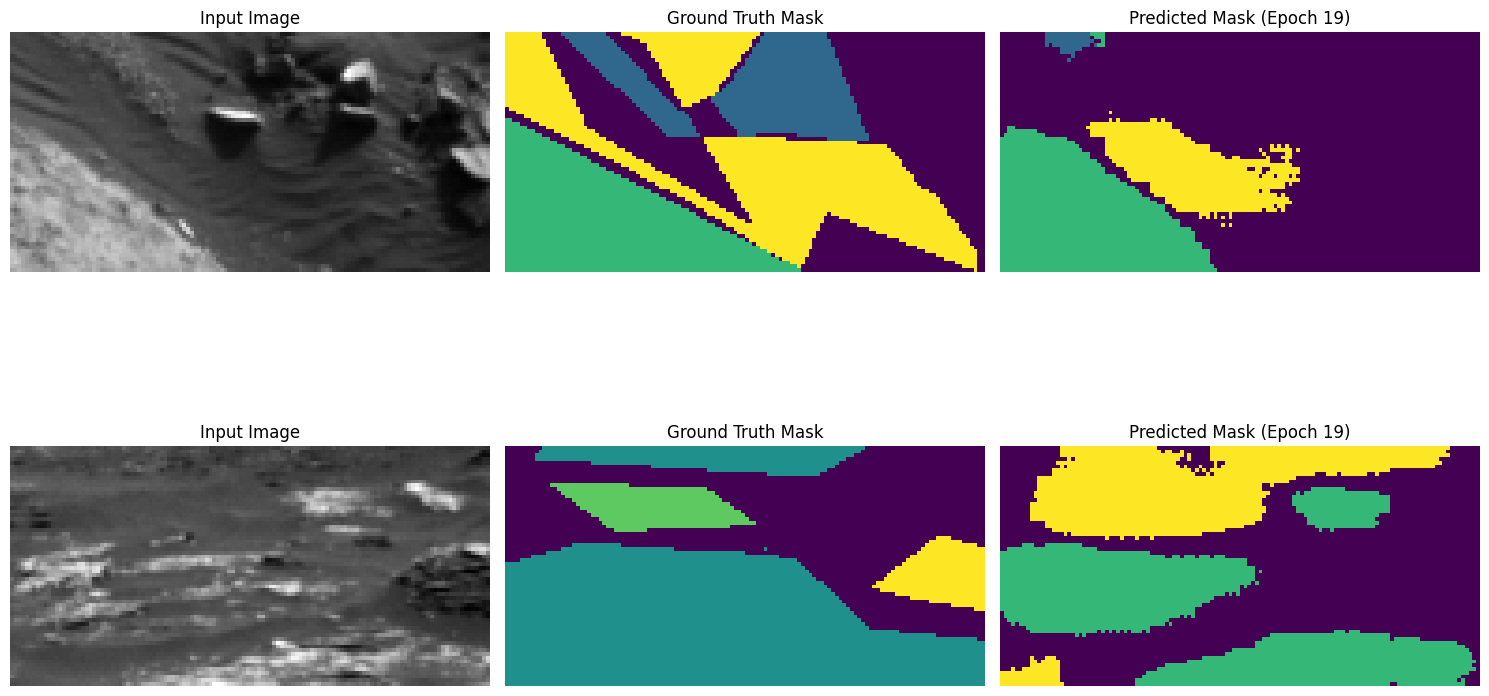

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.7797 - loss: 0.5639 - mean_io_u: 0.4710 - mean_iou: 0.4710 - val_accuracy: 0.7597 - val_loss: 0.6499 - val_mean_io_u: 0.4495 - val_mean_iou: 0.4495 - learning_rate: 1.0000e-04
Epoch 20/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7884 - loss: 0.5434 - mean_io_u: 0.4822 - mean_iou: 0.4822Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 20: val_loss did not improve from 0.64995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


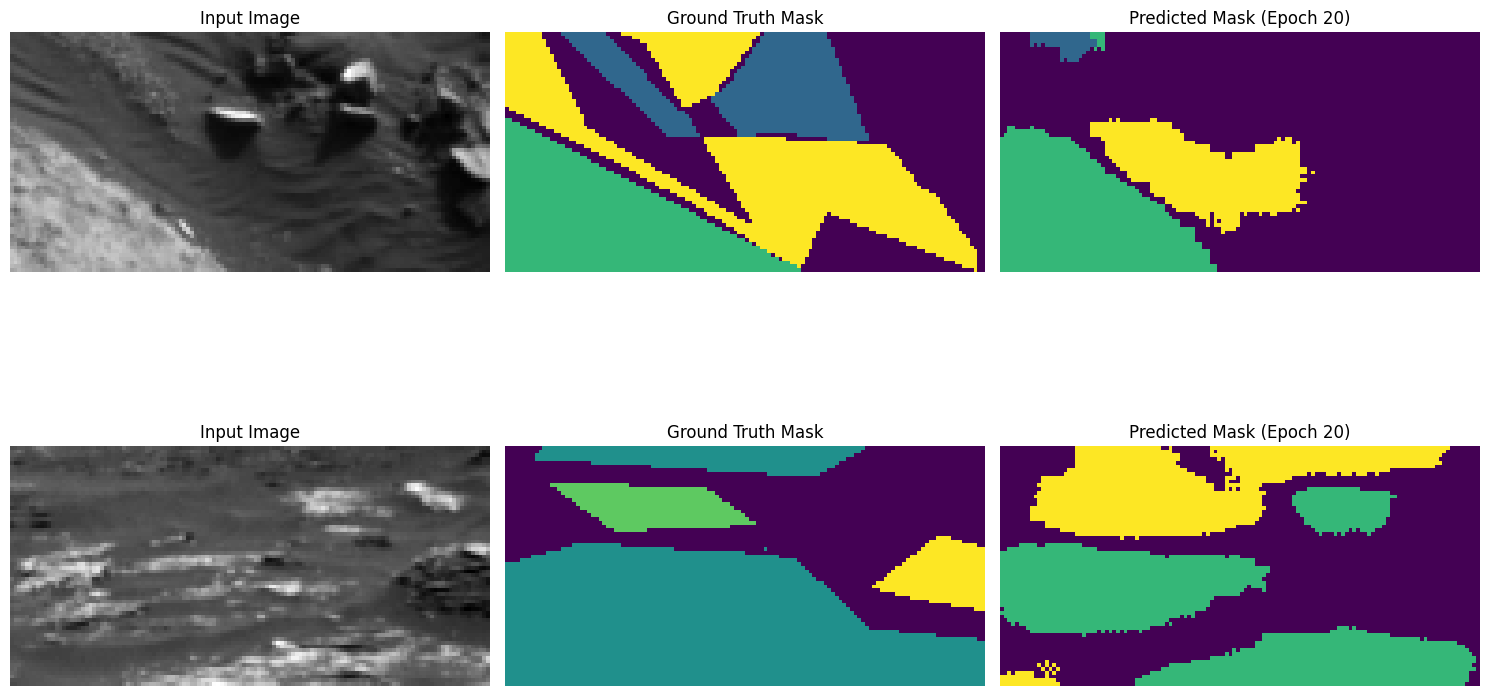

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.7884 - loss: 0.5434 - mean_io_u: 0.4821 - mean_iou: 0.4821 - val_accuracy: 0.7601 - val_loss: 0.6633 - val_mean_io_u: 0.4490 - val_mean_iou: 0.4490 - learning_rate: 1.0000e-04
Epoch 21/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7950 - loss: 0.5264 - mean_io_u: 0.4893 - mean_iou: 0.4893Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 21: val_mean_iou improved to 0.4552, saving model.

Epoch 21: val_loss improved from 0.64995 to 0.64227, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


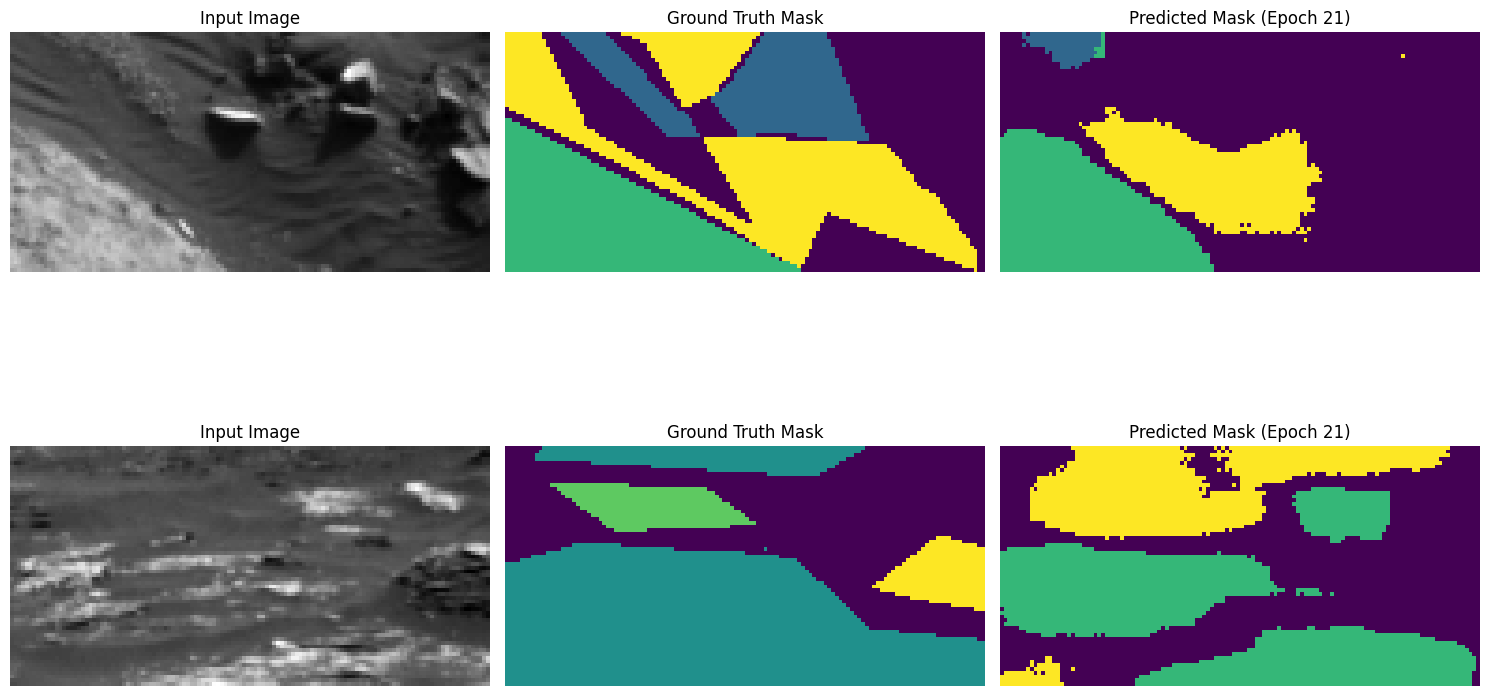

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.7950 - loss: 0.5263 - mean_io_u: 0.4893 - mean_iou: 0.4893 - val_accuracy: 0.7630 - val_loss: 0.6423 - val_mean_io_u: 0.4552 - val_mean_iou: 0.4552 - learning_rate: 1.0000e-04
Epoch 22/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7999 - loss: 0.5129 - mean_io_u: 0.4935 - mean_iou: 0.4935Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 22: val_mean_iou improved to 0.4573, saving model.

Epoch 22: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


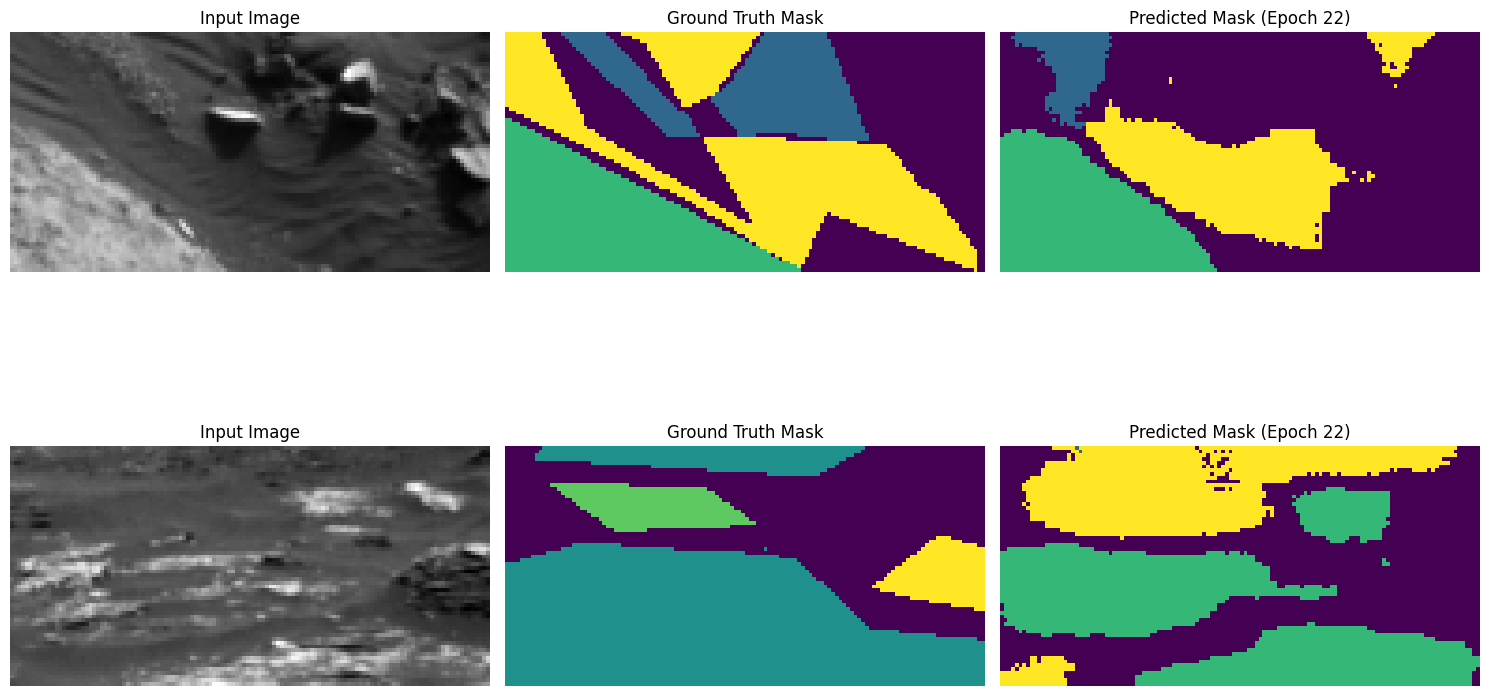

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.8000 - loss: 0.5128 - mean_io_u: 0.4935 - mean_iou: 0.4935 - val_accuracy: 0.7619 - val_loss: 0.6624 - val_mean_io_u: 0.4573 - val_mean_iou: 0.4573 - learning_rate: 1.0000e-04
Epoch 23/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8035 - loss: 0.5053 - mean_io_u: 0.4993 - mean_iou: 0.4993Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 23: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


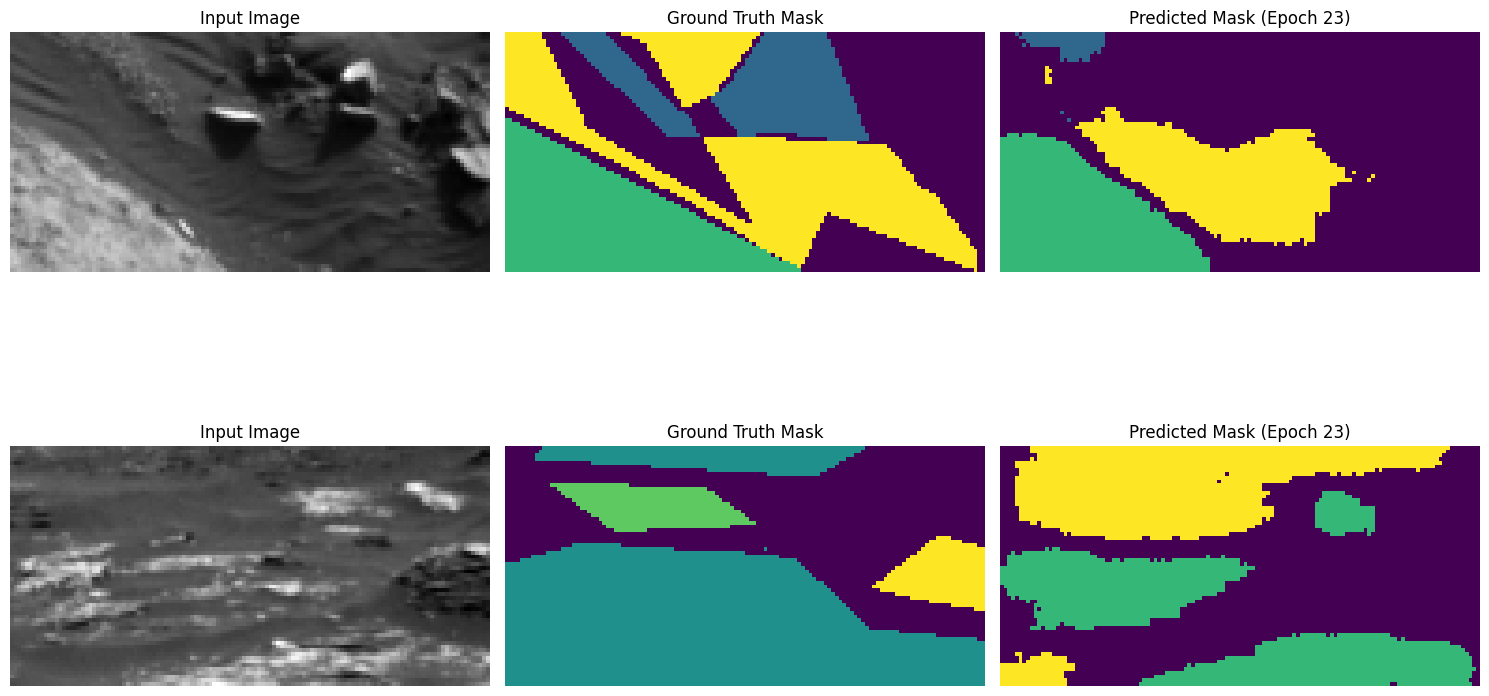

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.8035 - loss: 0.5052 - mean_io_u: 0.4993 - mean_iou: 0.4993 - val_accuracy: 0.7485 - val_loss: 0.6865 - val_mean_io_u: 0.4369 - val_mean_iou: 0.4369 - learning_rate: 1.0000e-04
Epoch 24/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8116 - loss: 0.4843 - mean_io_u: 0.5084 - mean_iou: 0.5084Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 24: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


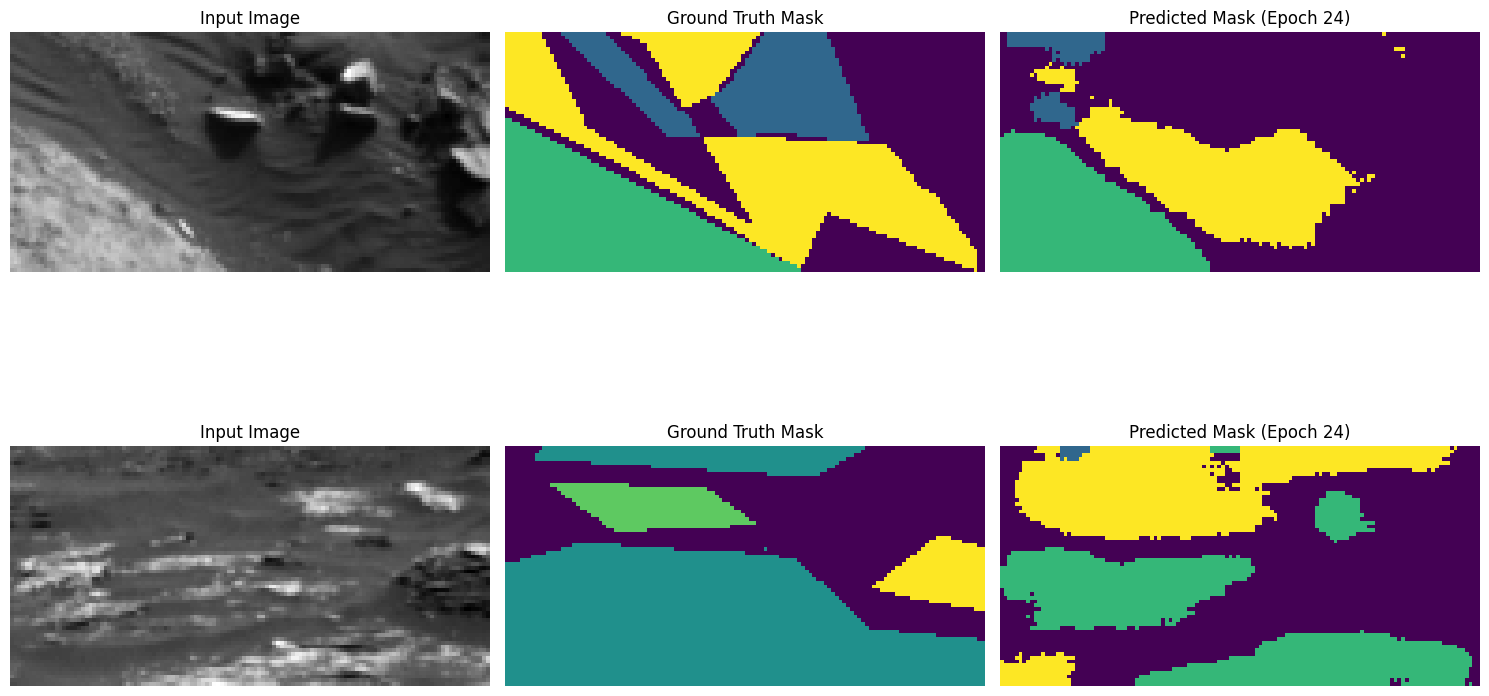

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - accuracy: 0.8117 - loss: 0.4842 - mean_io_u: 0.5084 - mean_iou: 0.5084 - val_accuracy: 0.7362 - val_loss: 0.7295 - val_mean_io_u: 0.4242 - val_mean_iou: 0.4242 - learning_rate: 1.0000e-04
Epoch 25/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8161 - loss: 0.4733 - mean_io_u: 0.5147 - mean_iou: 0.5147Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 25: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


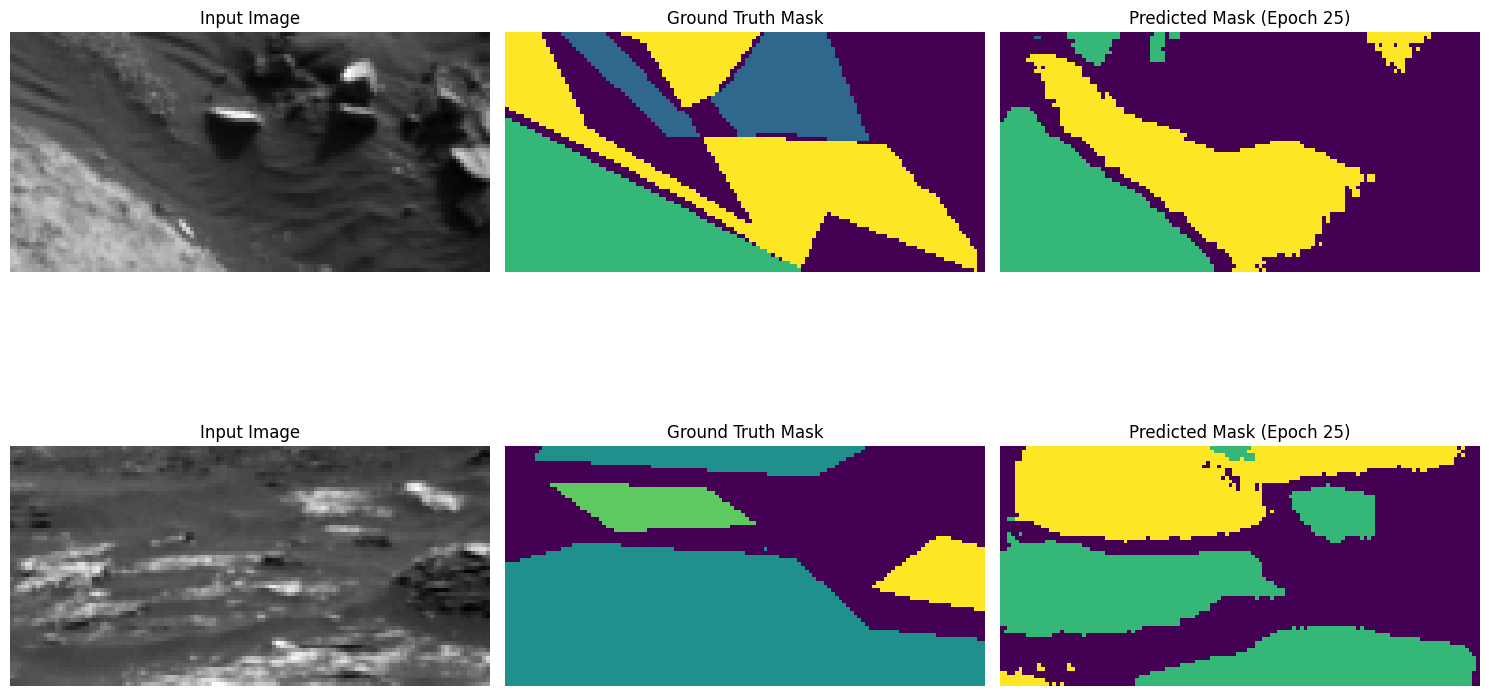

376/376 ━━━━━━━━━━━━━━━━━━━━ 81s 216ms/step - accuracy: 0.8161 - loss: 0.4733 - mean_io_u: 0.5147 - mean_iou: 0.5147 - val_accuracy: 0.7572 - val_loss: 0.6721 - val_mean_io_u: 0.4549 - val_mean_iou: 0.4549 - learning_rate: 1.0000e-04
Epoch 26/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8246 - loss: 0.4511 - mean_io_u: 0.5238 - mean_iou: 0.5238Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 26: val_loss did not improve from 0.64227

Epoch 26: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


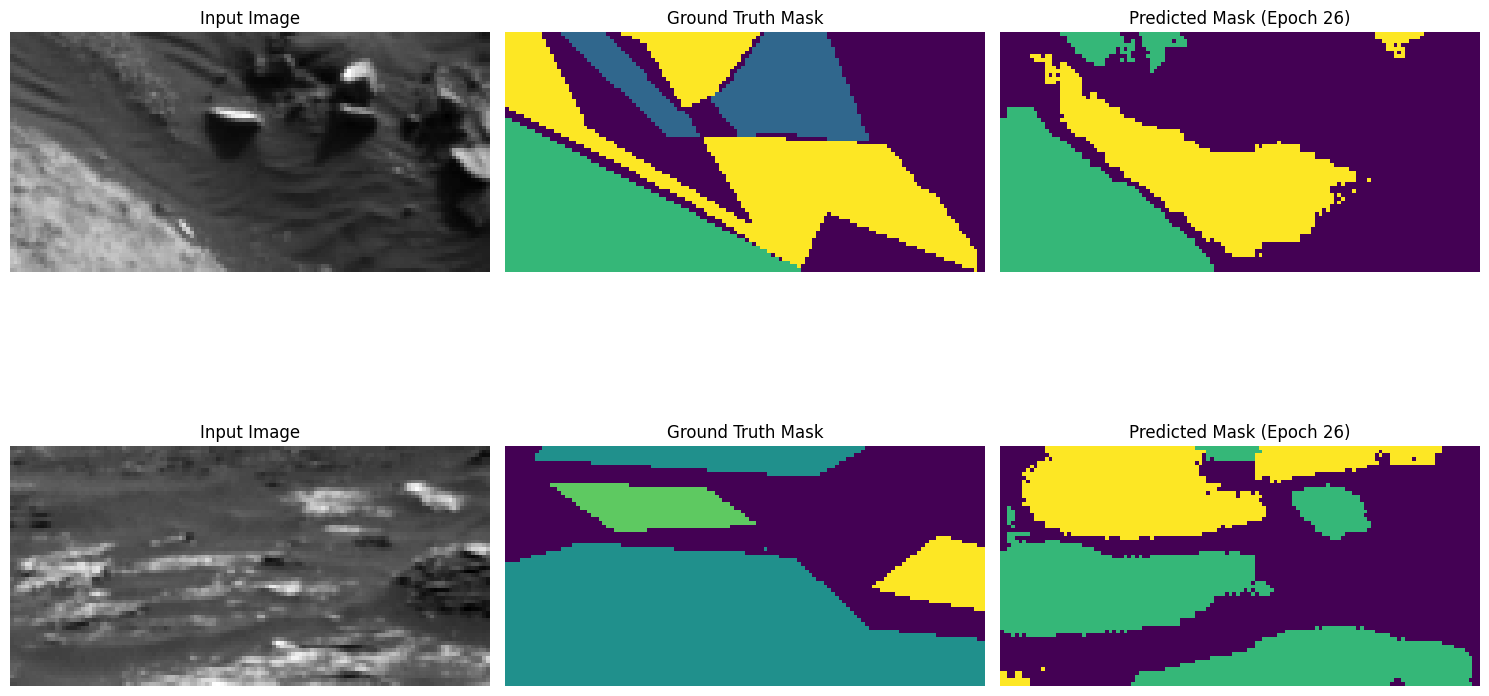

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - accuracy: 0.8246 - loss: 0.4511 - mean_io_u: 0.5237 - mean_iou: 0.5237 - val_accuracy: 0.7559 - val_loss: 0.6955 - val_mean_io_u: 0.4522 - val_mean_iou: 0.4522 - learning_rate: 1.0000e-04
Epoch 27/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8383 - loss: 0.4172 - mean_io_u: 0.5417 - mean_iou: 0.5417Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 27: val_mean_iou improved to 0.4638, saving model.

Epoch 27: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


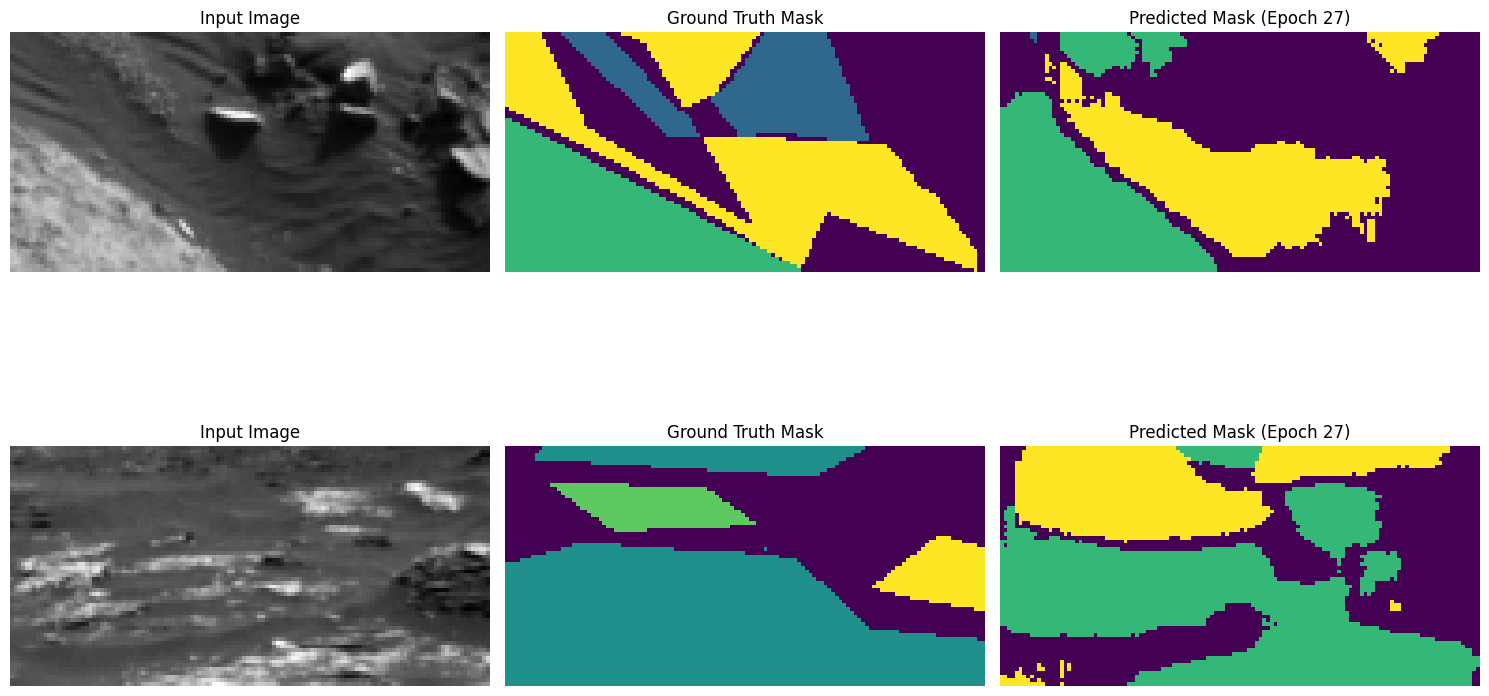

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 221ms/step - accuracy: 0.8384 - loss: 0.4172 - mean_io_u: 0.5417 - mean_iou: 0.5417 - val_accuracy: 0.7688 - val_loss: 0.6718 - val_mean_io_u: 0.4638 - val_mean_iou: 0.4638 - learning_rate: 5.0000e-05
Epoch 28/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8496 - loss: 0.3877 - mean_io_u: 0.5521 - mean_iou: 0.5521Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 28: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


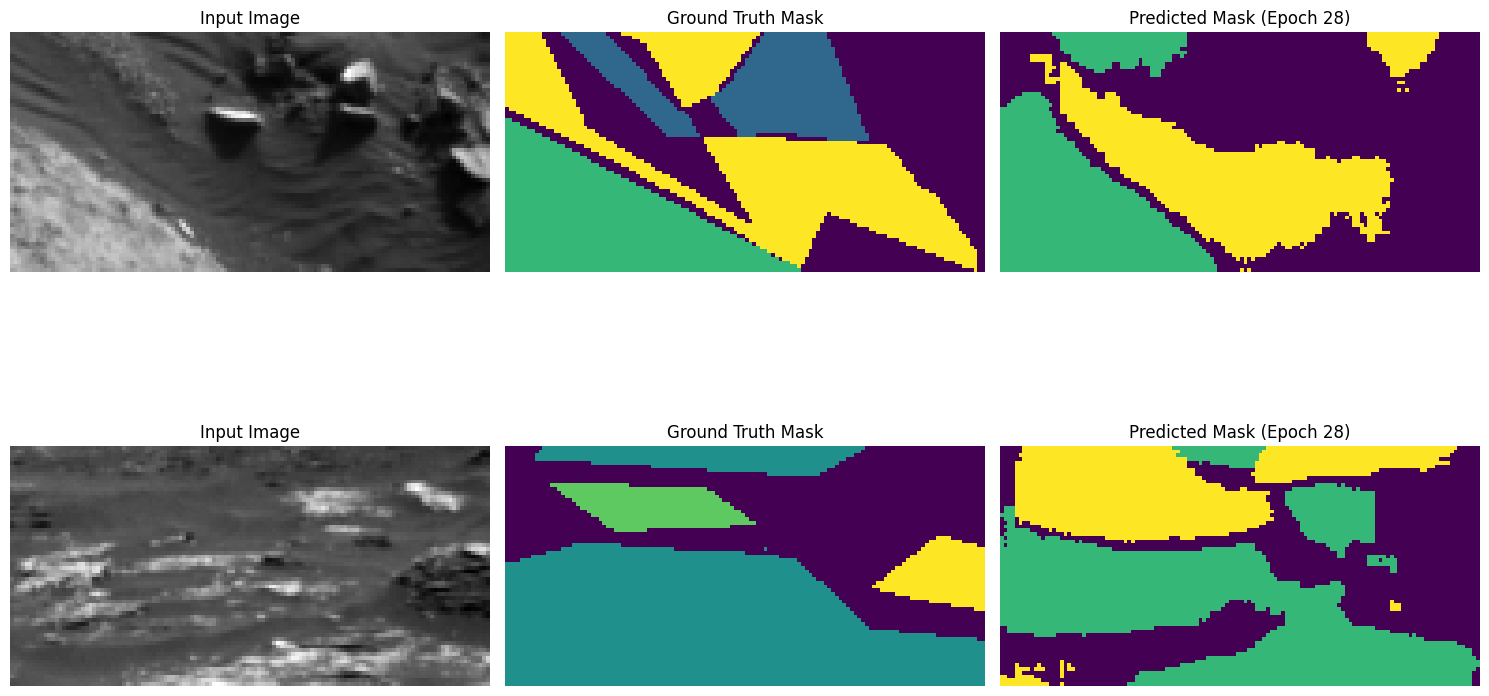

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - accuracy: 0.8496 - loss: 0.3877 - mean_io_u: 0.5521 - mean_iou: 0.5521 - val_accuracy: 0.7667 - val_loss: 0.6943 - val_mean_io_u: 0.4617 - val_mean_iou: 0.4617 - learning_rate: 5.0000e-05
Epoch 29/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8575 - loss: 0.3680 - mean_io_u: 0.5602 - mean_iou: 0.5602Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 29: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


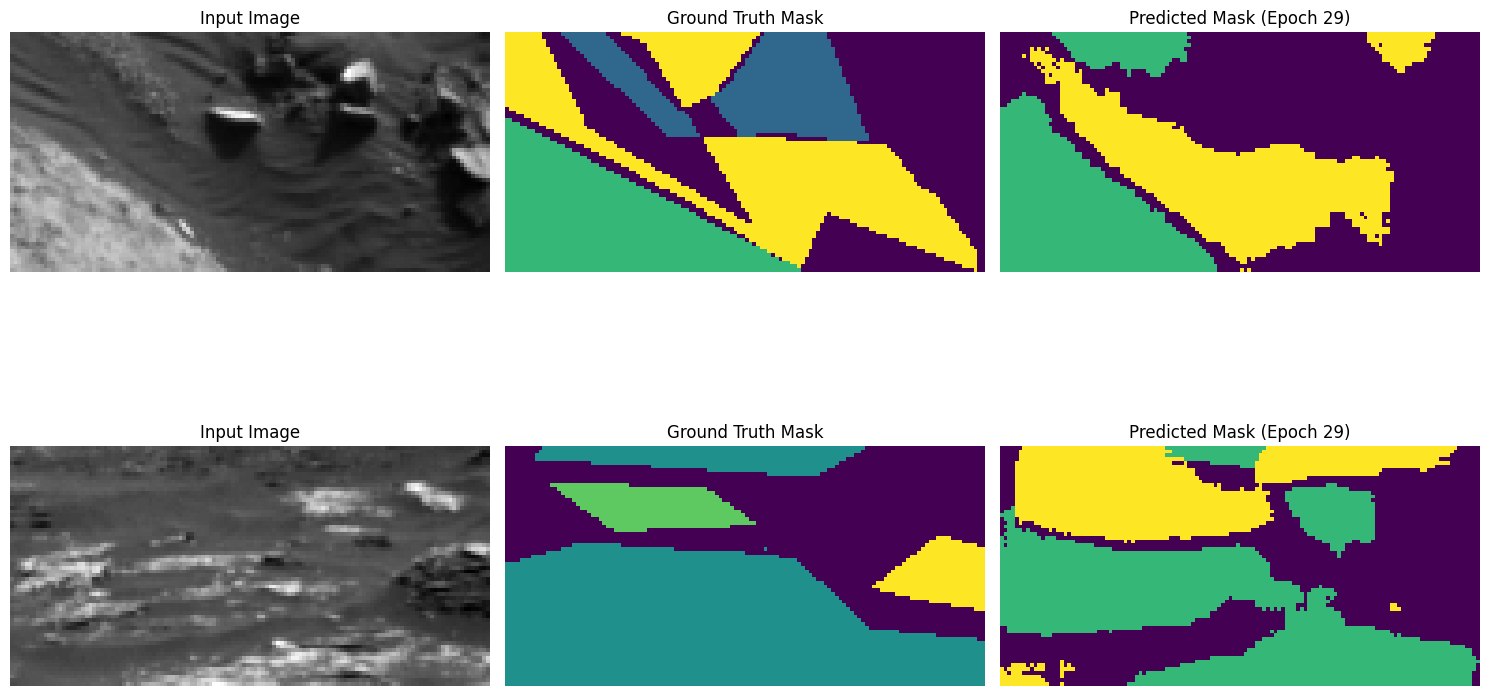

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.8576 - loss: 0.3680 - mean_io_u: 0.5601 - mean_iou: 0.5601 - val_accuracy: 0.7635 - val_loss: 0.7210 - val_mean_io_u: 0.4583 - val_mean_iou: 0.4583 - learning_rate: 5.0000e-05
Epoch 30/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8652 - loss: 0.3490 - mean_io_u: 0.5676 - mean_iou: 0.5676Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 30: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


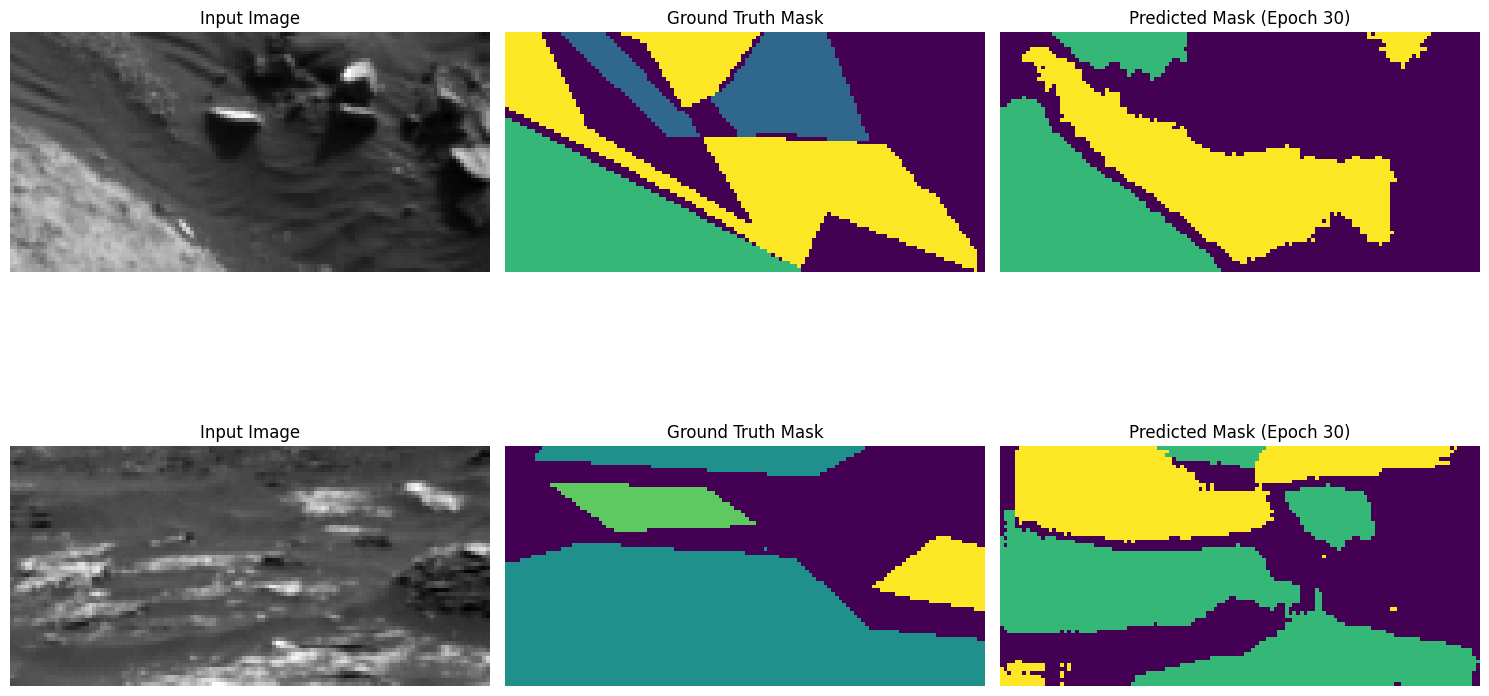

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.8653 - loss: 0.3490 - mean_io_u: 0.5676 - mean_iou: 0.5676 - val_accuracy: 0.7595 - val_loss: 0.7501 - val_mean_io_u: 0.4541 - val_mean_iou: 0.4541 - learning_rate: 5.0000e-05
Epoch 31/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8724 - loss: 0.3313 - mean_io_u: 0.5745 - mean_iou: 0.5745Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 31: val_loss did not improve from 0.64227

Epoch 31: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


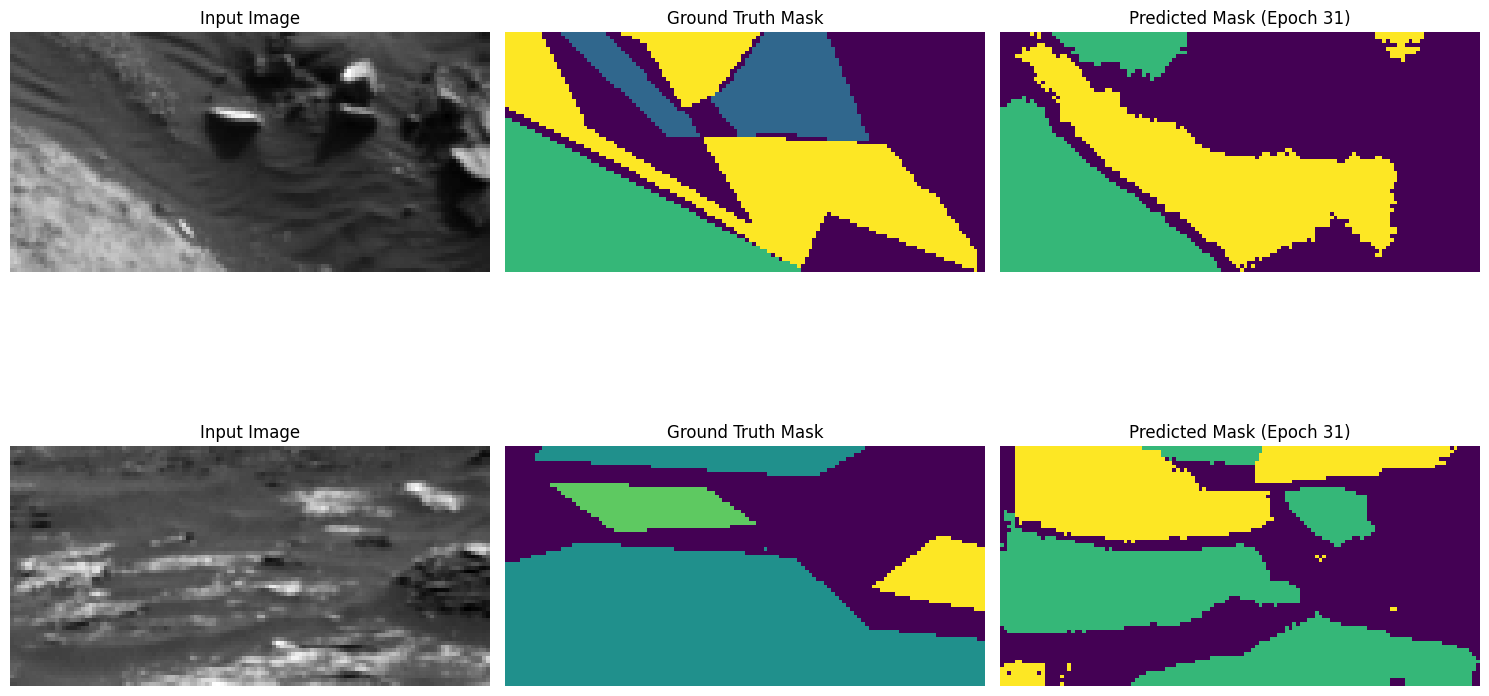

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.8724 - loss: 0.3313 - mean_io_u: 0.5745 - mean_iou: 0.5745 - val_accuracy: 0.7559 - val_loss: 0.7821 - val_mean_io_u: 0.4497 - val_mean_iou: 0.4497 - learning_rate: 5.0000e-05
Epoch 32/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8756 - loss: 0.3228 - mean_io_u: 0.5775 - mean_iou: 0.5775Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 32: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


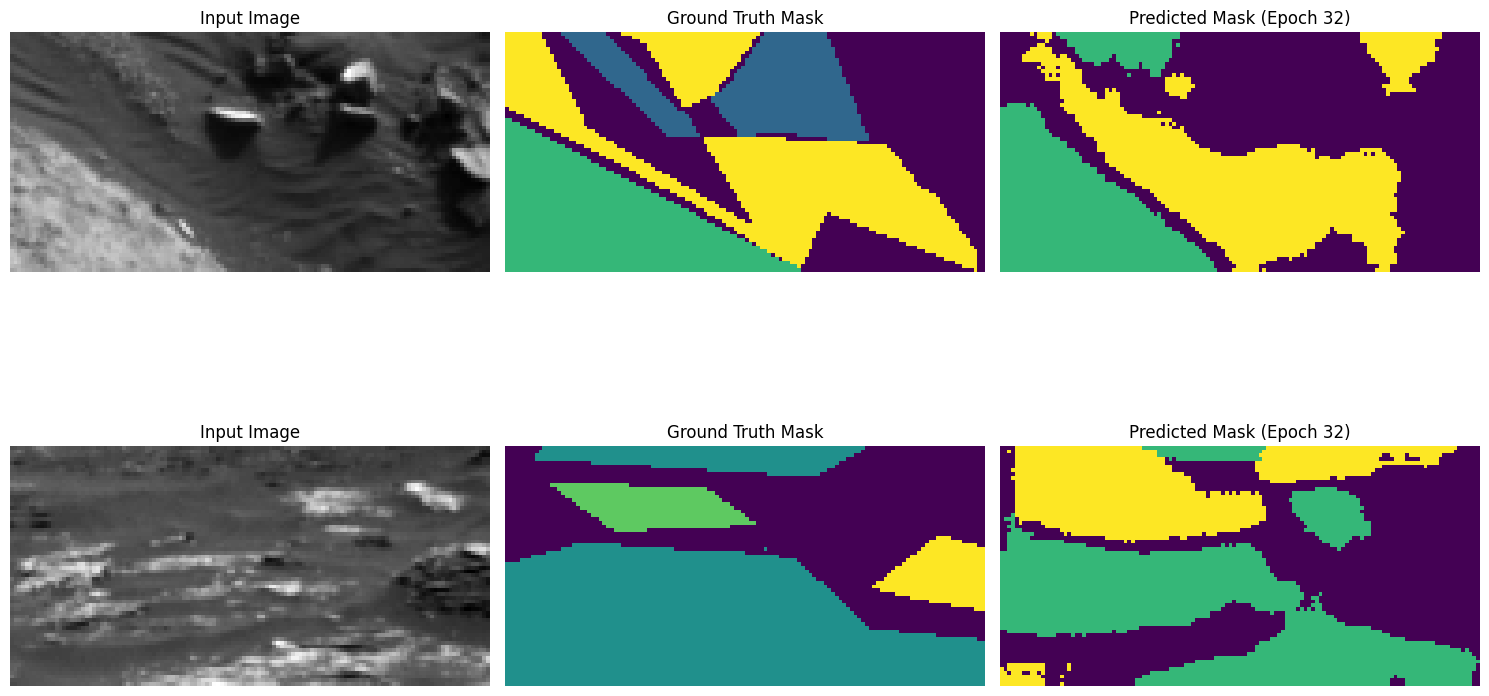

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.8756 - loss: 0.3228 - mean_io_u: 0.5774 - mean_iou: 0.5774 - val_accuracy: 0.7633 - val_loss: 0.7581 - val_mean_io_u: 0.4595 - val_mean_iou: 0.4595 - learning_rate: 2.5000e-05
Epoch 33/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8820 - loss: 0.3067 - mean_io_u: 0.5824 - mean_iou: 0.5824Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 33: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


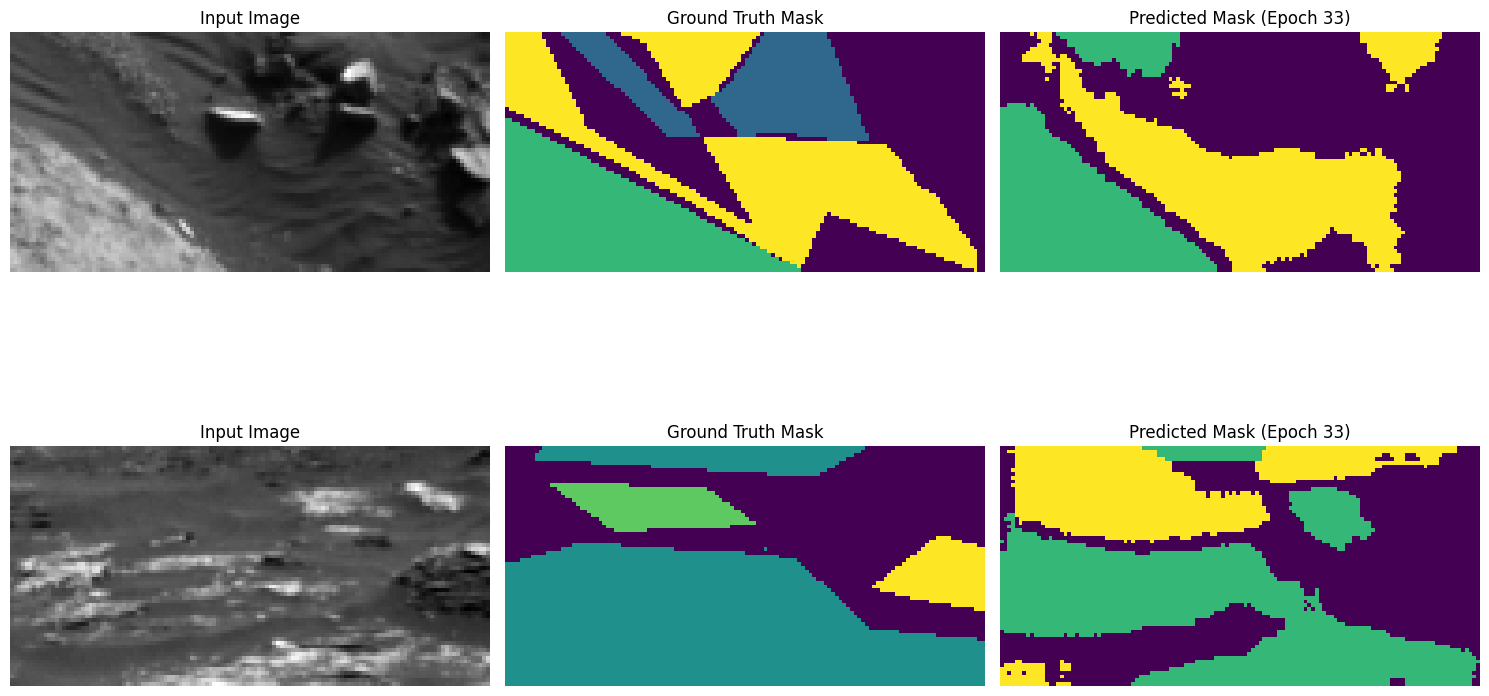

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 221ms/step - accuracy: 0.8820 - loss: 0.3067 - mean_io_u: 0.5824 - mean_iou: 0.5824 - val_accuracy: 0.7635 - val_loss: 0.7785 - val_mean_io_u: 0.4612 - val_mean_iou: 0.4612 - learning_rate: 2.5000e-05
Epoch 34/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8870 - loss: 0.2943 - mean_io_u: 0.5874 - mean_iou: 0.5874Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 34: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


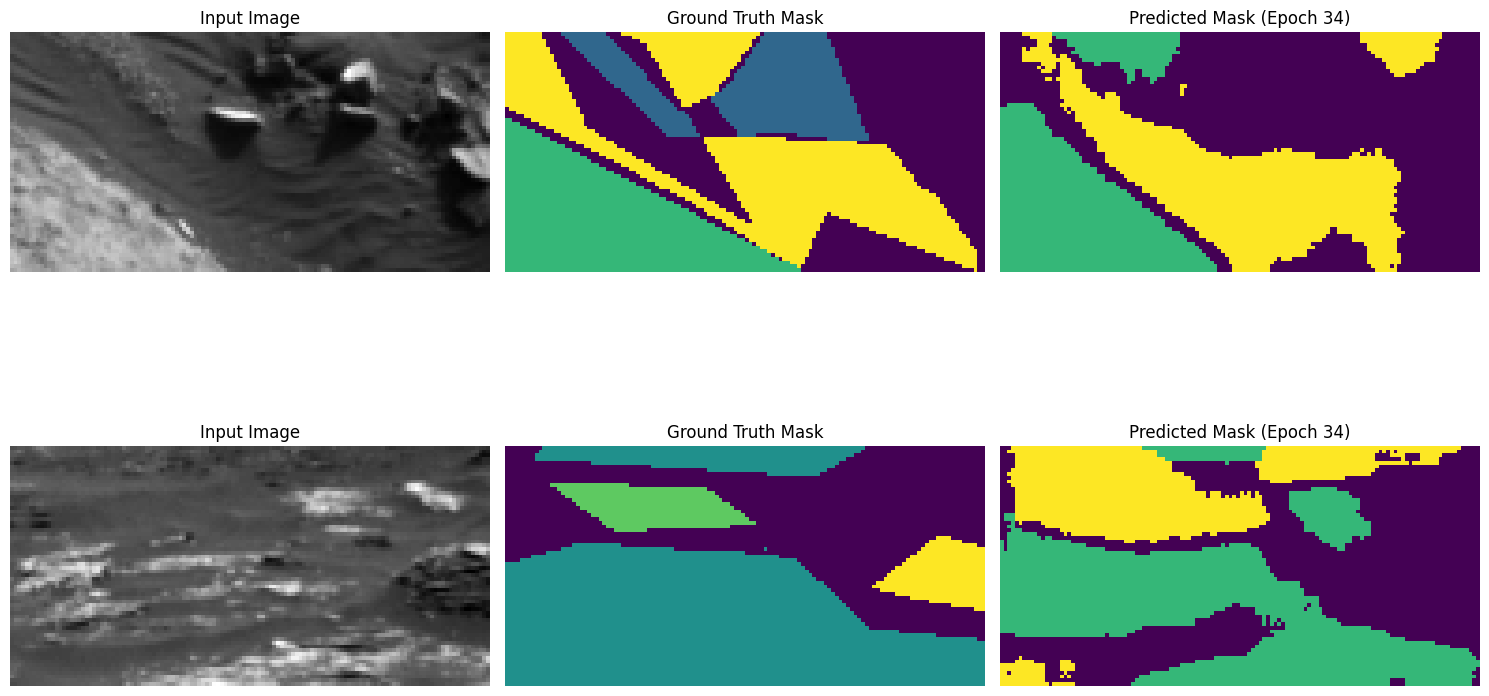

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 221ms/step - accuracy: 0.8870 - loss: 0.2943 - mean_io_u: 0.5874 - mean_iou: 0.5874 - val_accuracy: 0.7628 - val_loss: 0.7998 - val_mean_io_u: 0.4610 - val_mean_iou: 0.4610 - learning_rate: 2.5000e-05
Epoch 35/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8914 - loss: 0.2835 - mean_io_u: 0.5916 - mean_iou: 0.5916Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 35: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


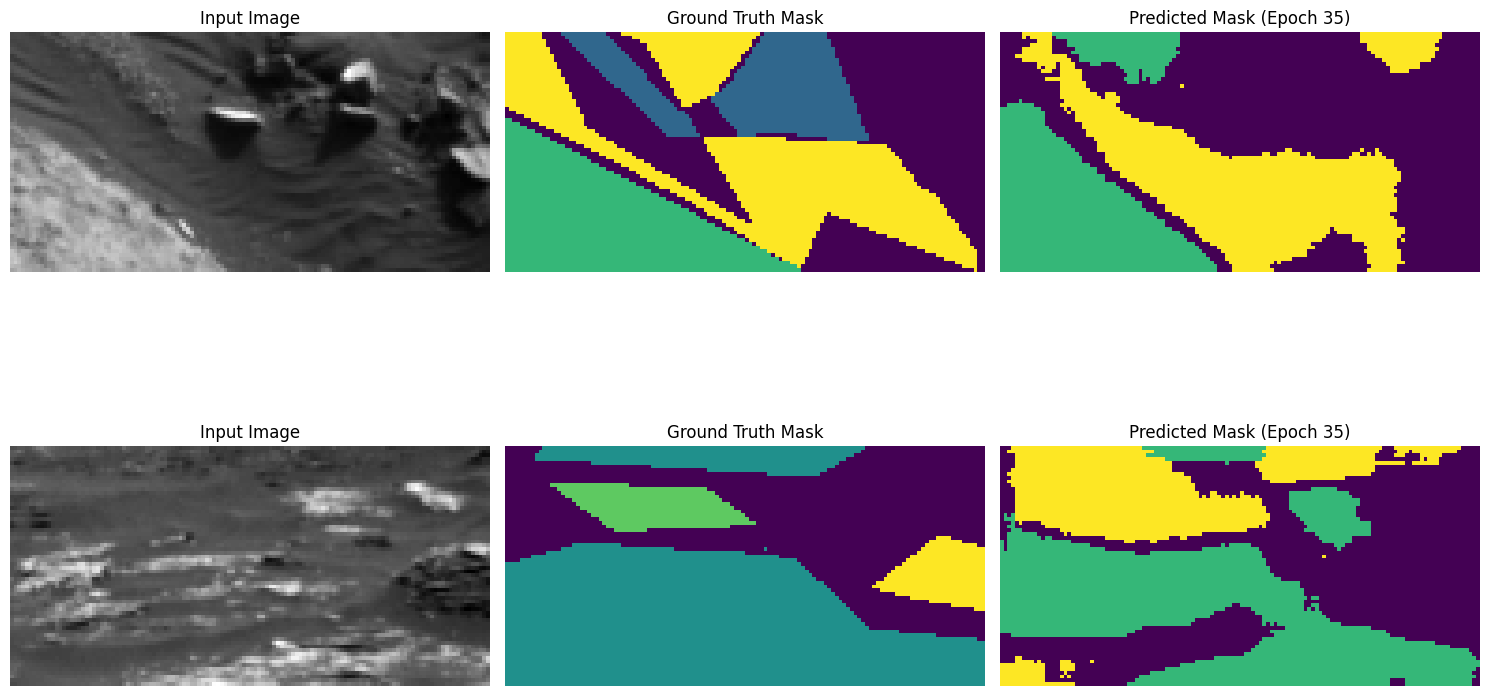

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.8914 - loss: 0.2835 - mean_io_u: 0.5916 - mean_iou: 0.5916 - val_accuracy: 0.7621 - val_loss: 0.8220 - val_mean_io_u: 0.4607 - val_mean_iou: 0.4607 - learning_rate: 2.5000e-05
Epoch 36/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8956 - loss: 0.2733 - mean_io_u: 0.5955 - mean_iou: 0.5955Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 36: val_loss did not improve from 0.64227

Epoch 36: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


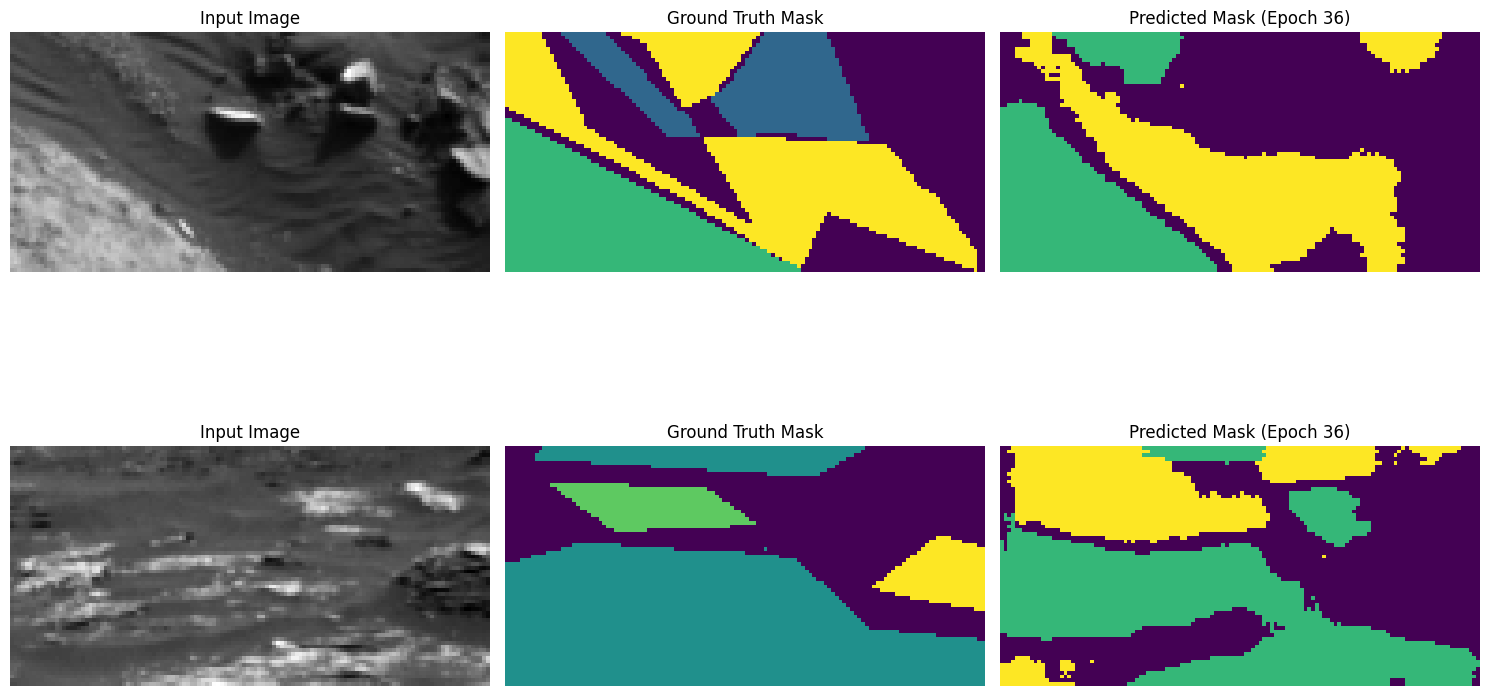

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - accuracy: 0.8956 - loss: 0.2733 - mean_io_u: 0.5955 - mean_iou: 0.5955 - val_accuracy: 0.7615 - val_loss: 0.8444 - val_mean_io_u: 0.4602 - val_mean_iou: 0.4602 - learning_rate: 2.5000e-05
Epoch 37/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8960 - loss: 0.2704 - mean_io_u: 0.5982 - mean_iou: 0.5982Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 37: val_mean_iou improved to 0.4655, saving model.

Epoch 37: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


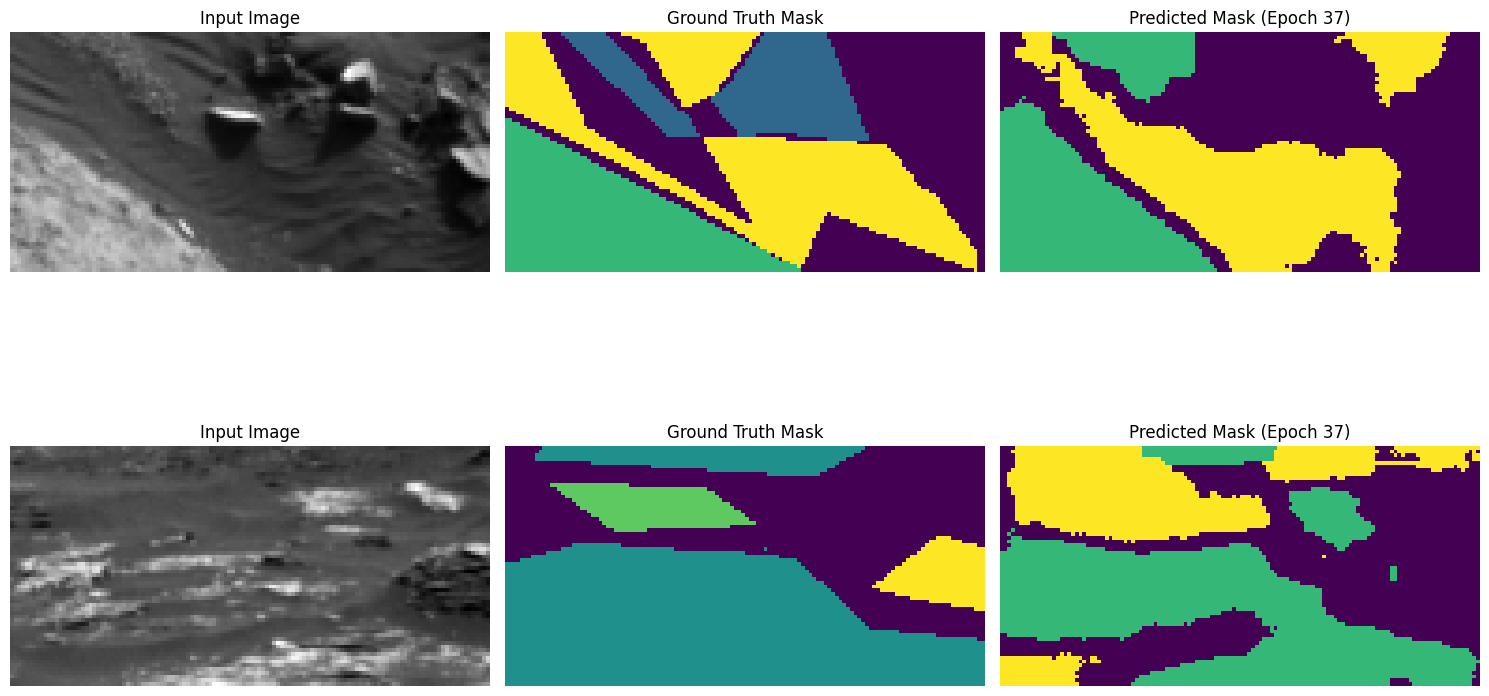

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.8960 - loss: 0.2704 - mean_io_u: 0.5982 - mean_iou: 0.5982 - val_accuracy: 0.7660 - val_loss: 0.8172 - val_mean_io_u: 0.4655 - val_mean_iou: 0.4655 - learning_rate: 1.2500e-05
Epoch 38/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8991 - loss: 0.2625 - mean_io_u: 0.6001 - mean_iou: 0.6001Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 38: val_mean_iou improved to 0.4655, saving model.

Epoch 38: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


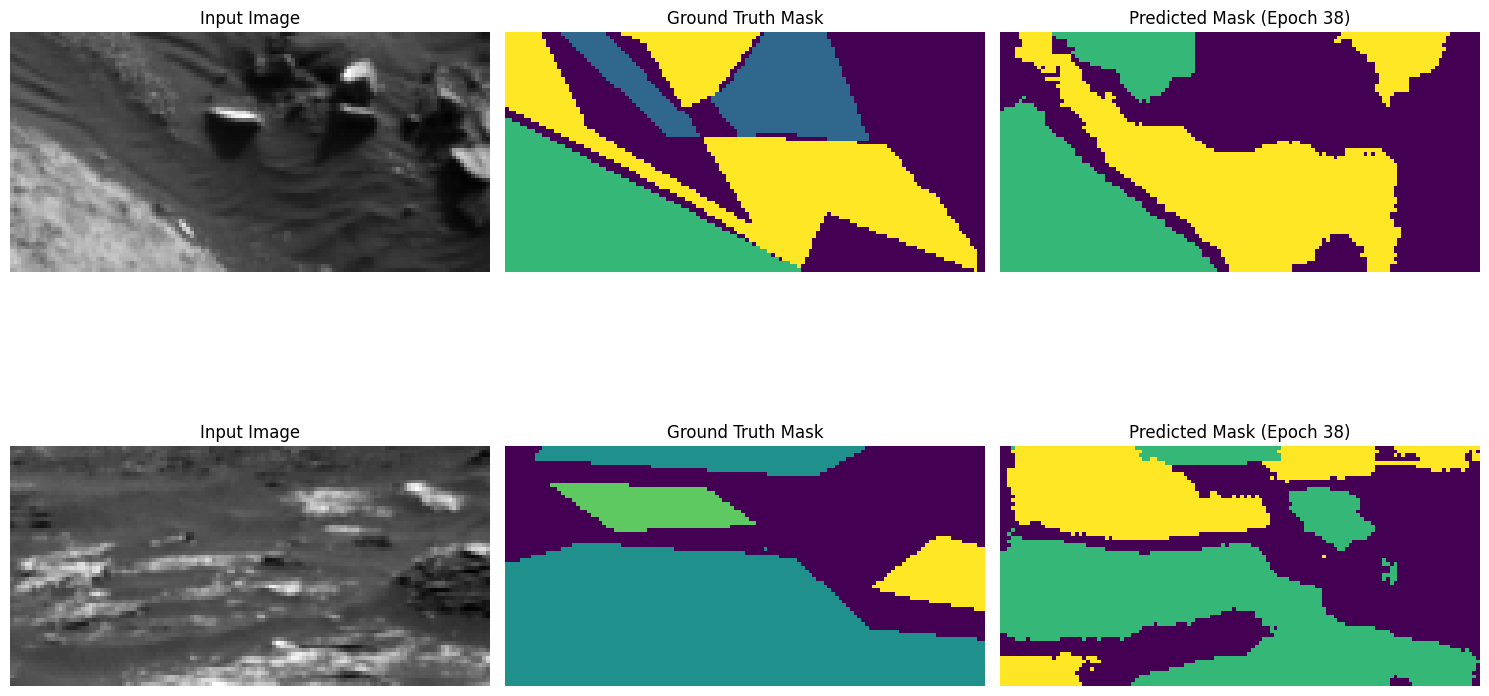

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.8991 - loss: 0.2625 - mean_io_u: 0.6001 - mean_iou: 0.6001 - val_accuracy: 0.7656 - val_loss: 0.8311 - val_mean_io_u: 0.4655 - val_mean_iou: 0.4655 - learning_rate: 1.2500e-05
Epoch 39/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9020 - loss: 0.2556 - mean_io_u: 0.6028 - mean_iou: 0.6028Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 39: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


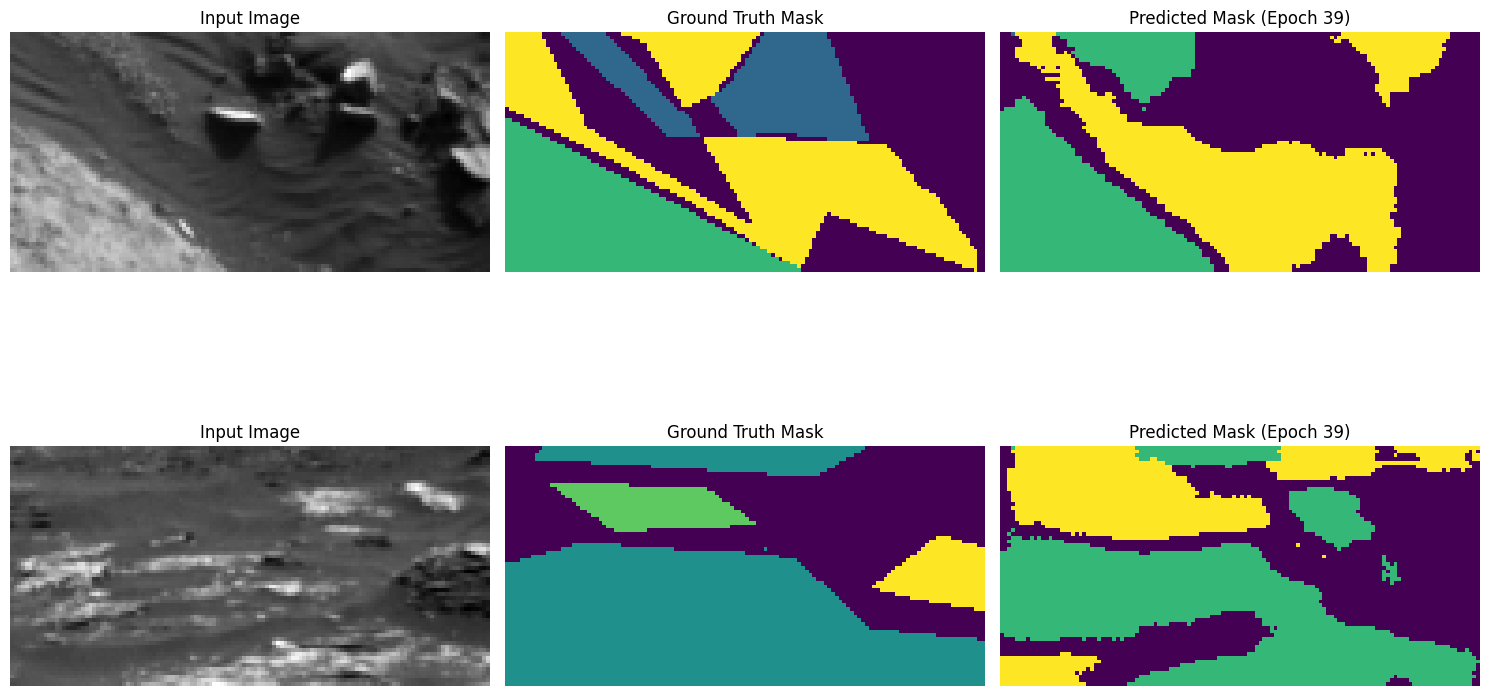

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.9020 - loss: 0.2556 - mean_io_u: 0.6028 - mean_iou: 0.6028 - val_accuracy: 0.7653 - val_loss: 0.8450 - val_mean_io_u: 0.4655 - val_mean_iou: 0.4655 - learning_rate: 1.2500e-05
Epoch 40/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9046 - loss: 0.2496 - mean_io_u: 0.6051 - mean_iou: 0.6051Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 40: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


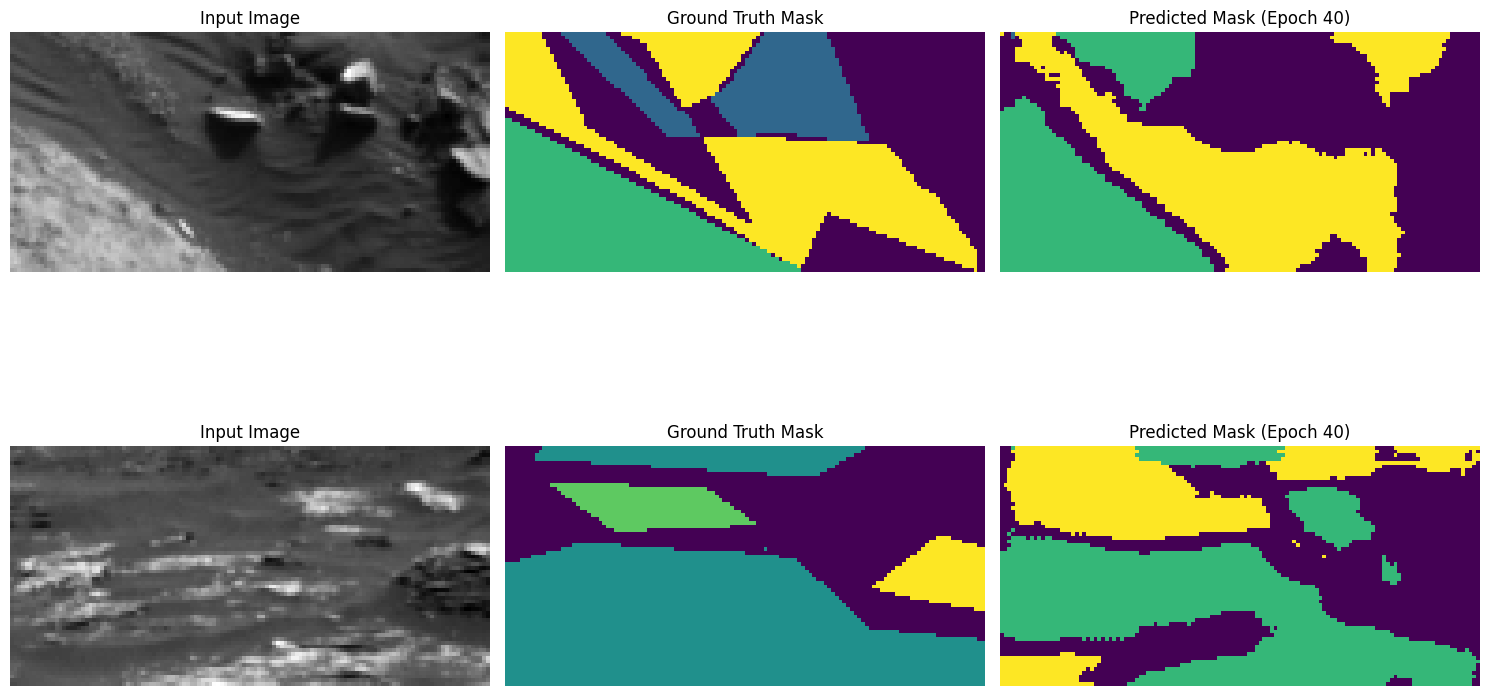

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 217ms/step - accuracy: 0.9046 - loss: 0.2496 - mean_io_u: 0.6051 - mean_iou: 0.6051 - val_accuracy: 0.7649 - val_loss: 0.8582 - val_mean_io_u: 0.4654 - val_mean_iou: 0.4654 - learning_rate: 1.2500e-05
Epoch 41/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9069 - loss: 0.2440 - mean_io_u: 0.6073 - mean_iou: 0.6073Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 41: val_loss did not improve from 0.64227

Epoch 41: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


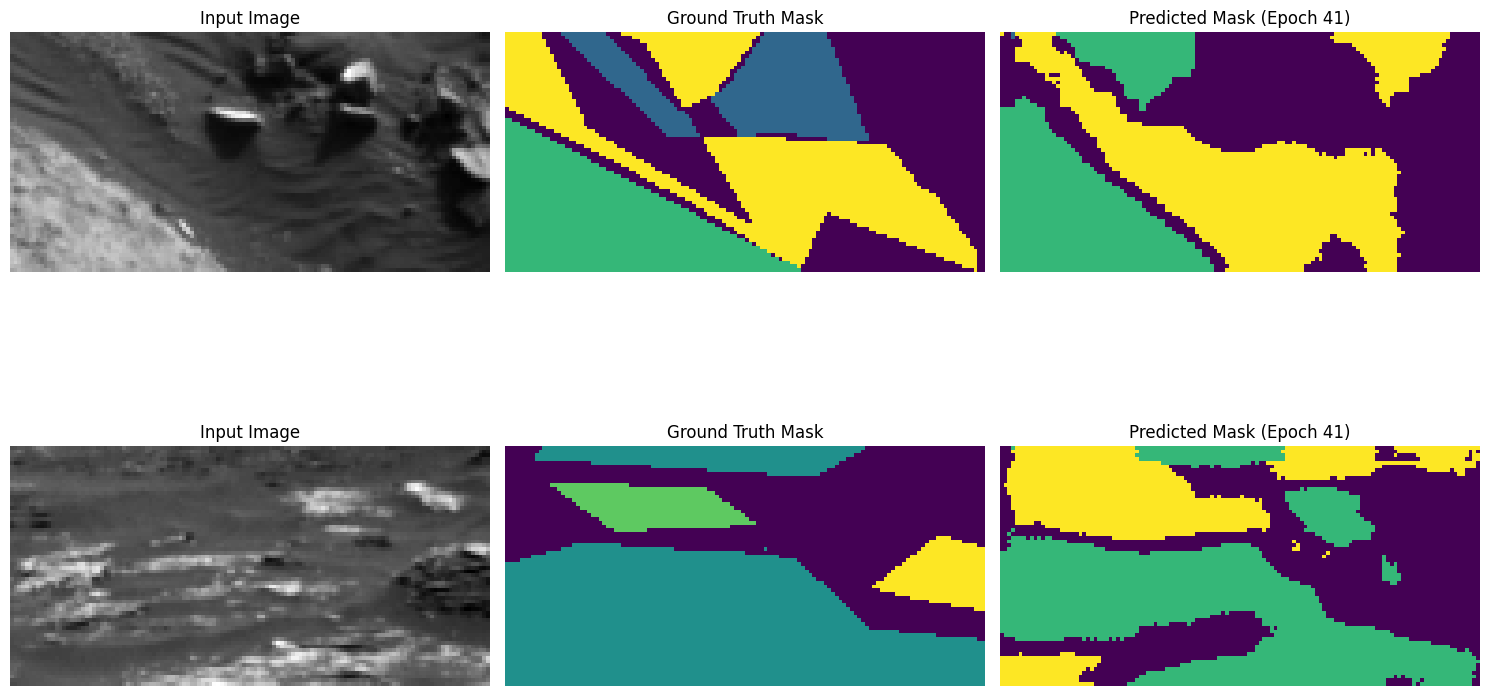

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - accuracy: 0.9069 - loss: 0.2440 - mean_io_u: 0.6073 - mean_iou: 0.6073 - val_accuracy: 0.7645 - val_loss: 0.8717 - val_mean_io_u: 0.4653 - val_mean_iou: 0.4653 - learning_rate: 1.2500e-05
Epoch 42/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9092 - loss: 0.2382 - mean_io_u: 0.6091 - mean_iou: 0.6091Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 42: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


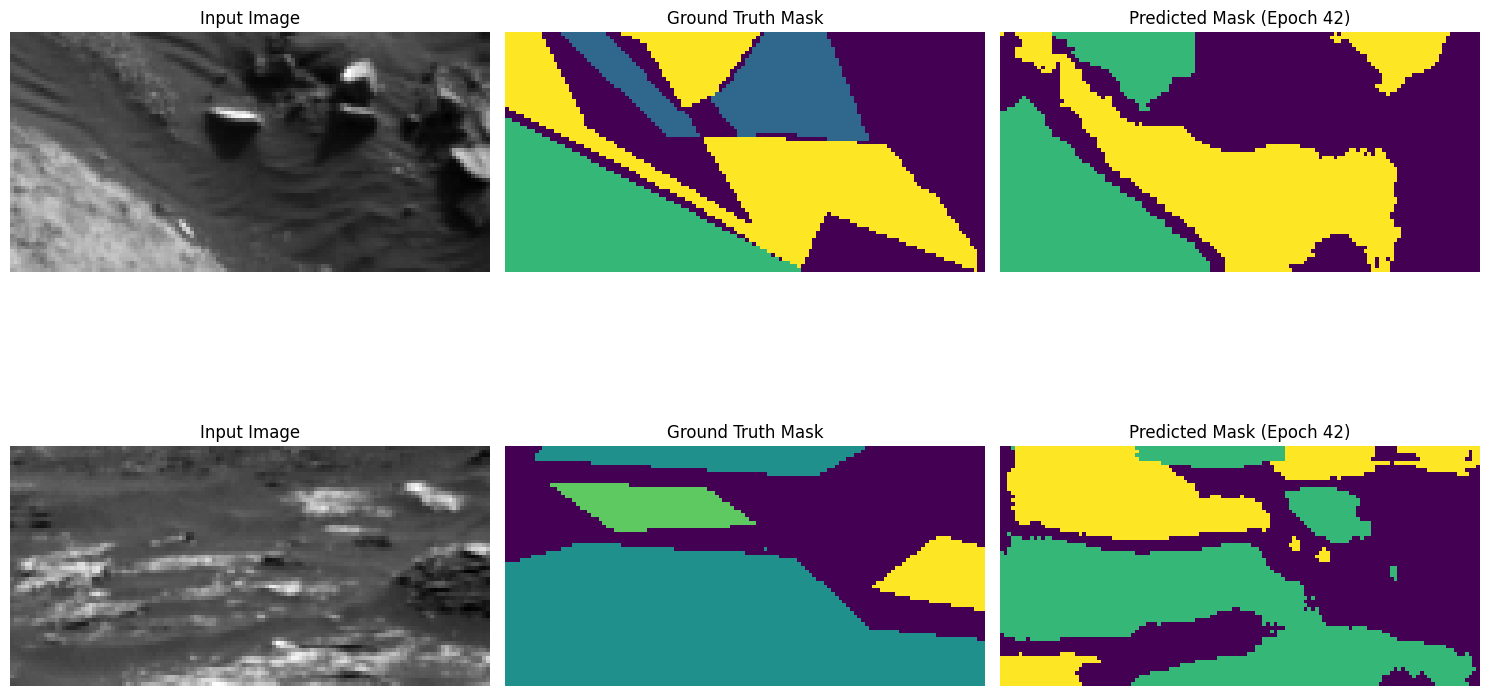

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.9092 - loss: 0.2382 - mean_io_u: 0.6091 - mean_iou: 0.6091 - val_accuracy: 0.7606 - val_loss: 0.8759 - val_mean_io_u: 0.4609 - val_mean_iou: 0.4609 - learning_rate: 6.2500e-06
Epoch 43/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9107 - loss: 0.2343 - mean_io_u: 0.6109 - mean_iou: 0.6109Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 43: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


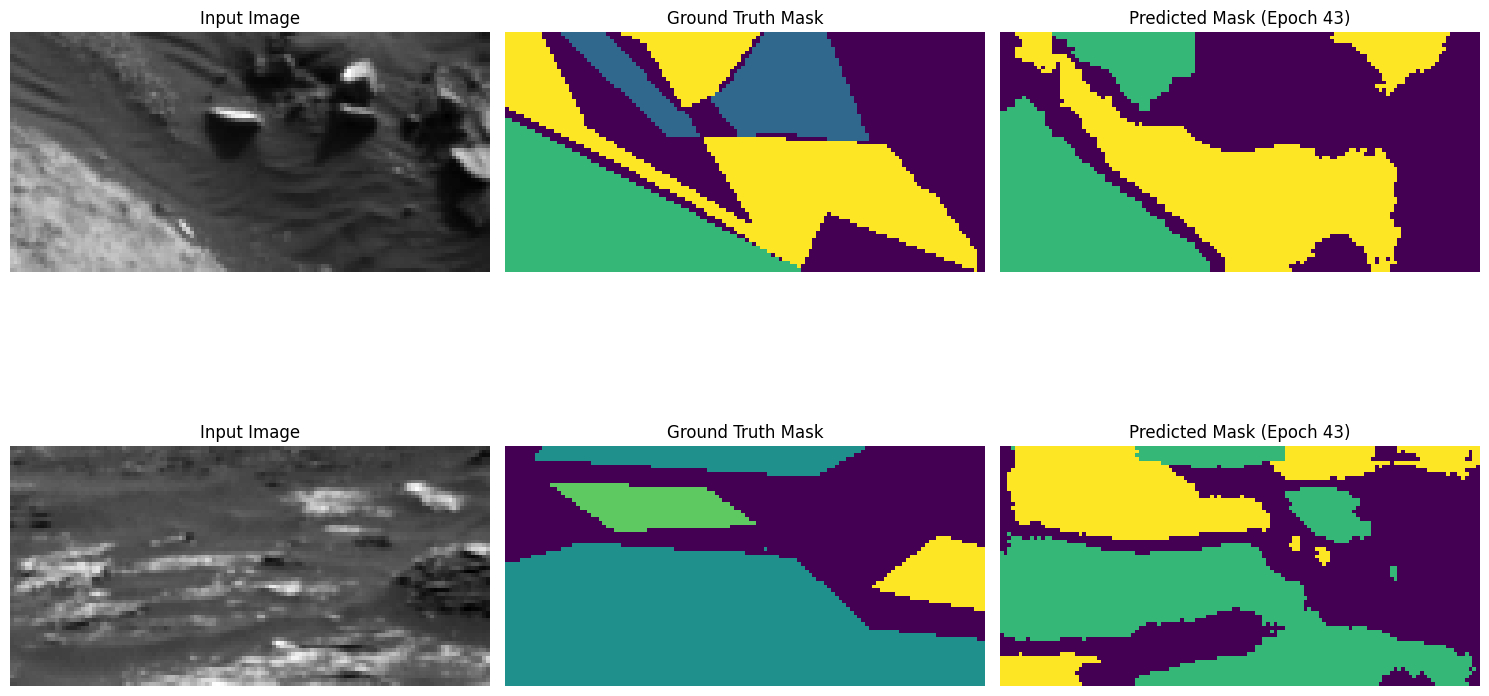

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.9107 - loss: 0.2343 - mean_io_u: 0.6109 - mean_iou: 0.6109 - val_accuracy: 0.7602 - val_loss: 0.8850 - val_mean_io_u: 0.4608 - val_mean_iou: 0.4608 - learning_rate: 6.2500e-06
Epoch 44/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9121 - loss: 0.2310 - mean_io_u: 0.6121 - mean_iou: 0.6121Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 44: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


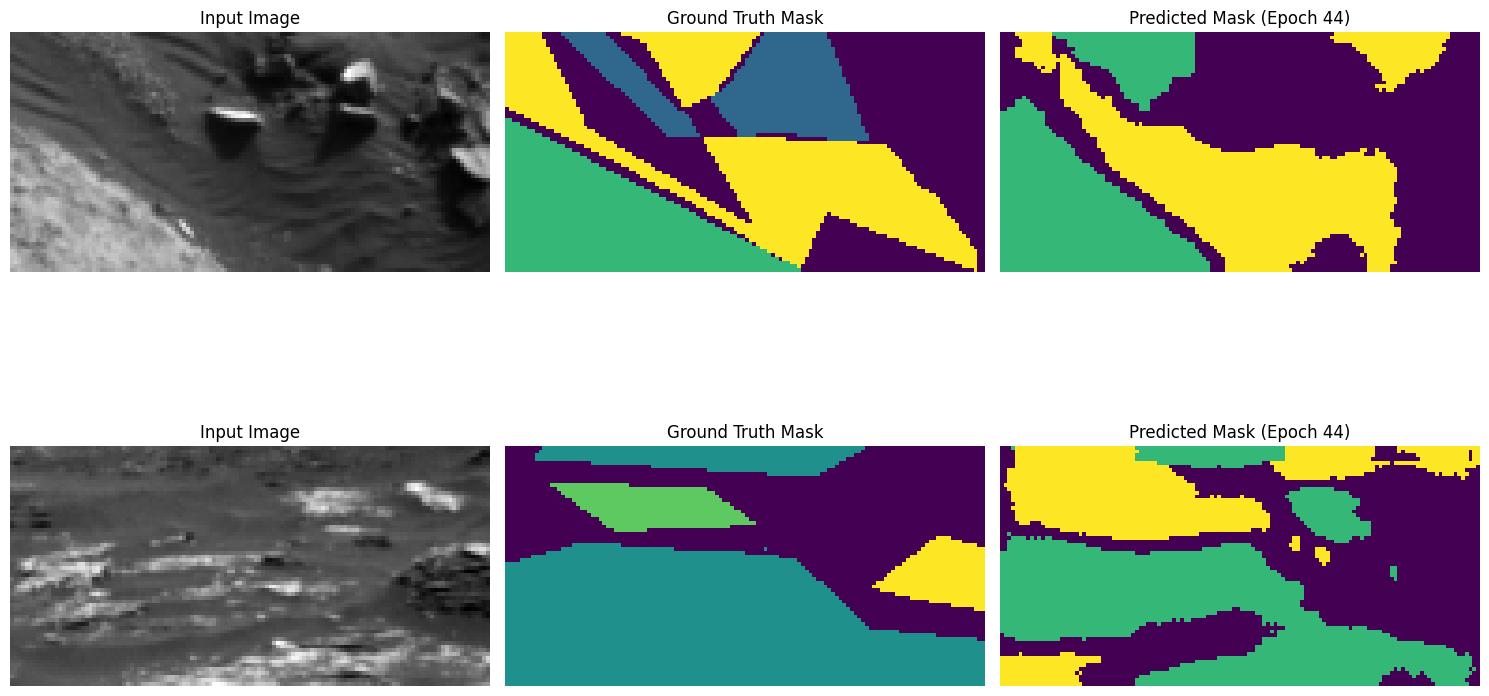

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 217ms/step - accuracy: 0.9121 - loss: 0.2310 - mean_io_u: 0.6121 - mean_iou: 0.6121 - val_accuracy: 0.7600 - val_loss: 0.8936 - val_mean_io_u: 0.4607 - val_mean_iou: 0.4607 - learning_rate: 6.2500e-06
Epoch 45/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9134 - loss: 0.2279 - mean_io_u: 0.6131 - mean_iou: 0.6131Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 45: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


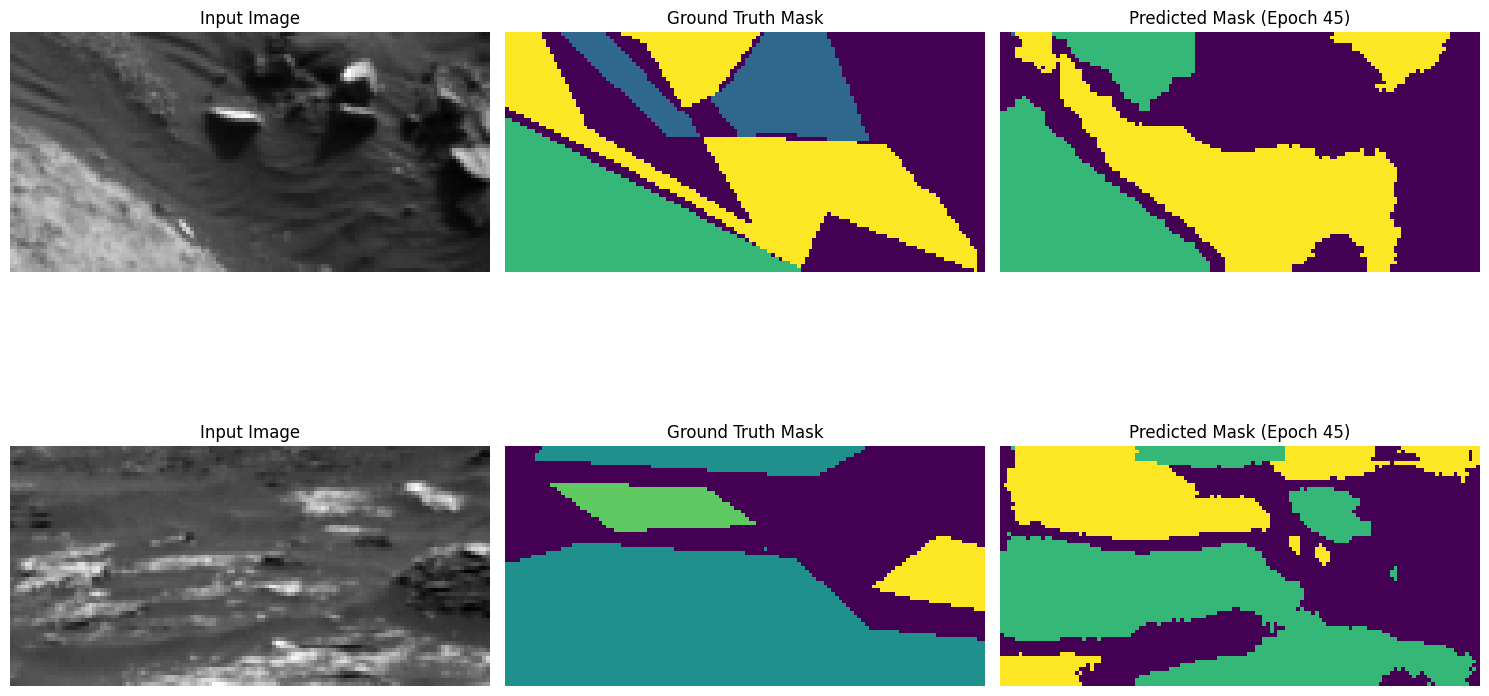

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - accuracy: 0.9134 - loss: 0.2279 - mean_io_u: 0.6131 - mean_iou: 0.6131 - val_accuracy: 0.7598 - val_loss: 0.9021 - val_mean_io_u: 0.4606 - val_mean_iou: 0.4606 - learning_rate: 6.2500e-06
Epoch 46/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9146 - loss: 0.2249 - mean_io_u: 0.6141 - mean_iou: 0.6141Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 46: val_loss did not improve from 0.64227

Epoch 46: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


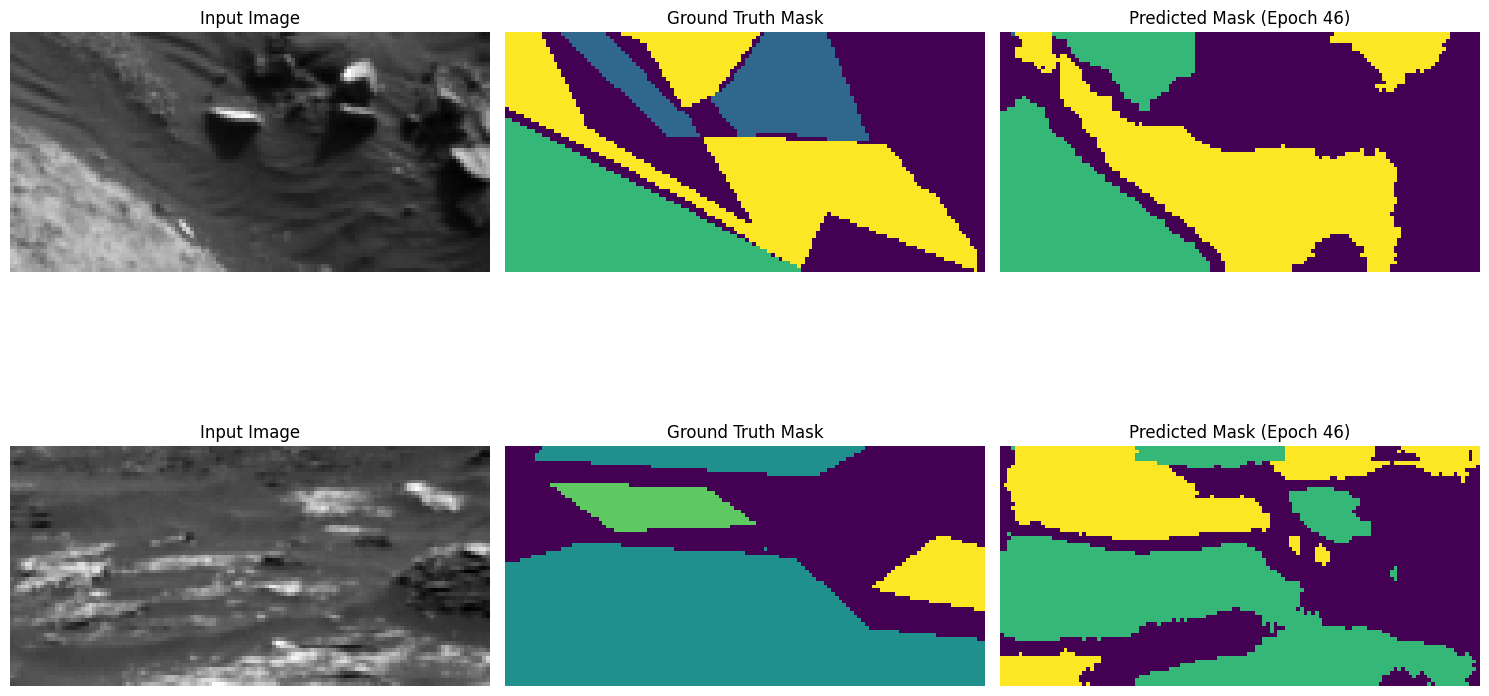

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.9146 - loss: 0.2249 - mean_io_u: 0.6141 - mean_iou: 0.6141 - val_accuracy: 0.7595 - val_loss: 0.9102 - val_mean_io_u: 0.4603 - val_mean_iou: 0.4603 - learning_rate: 6.2500e-06
Epoch 47/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9157 - loss: 0.2220 - mean_io_u: 0.6154 - mean_iou: 0.6154Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 47: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


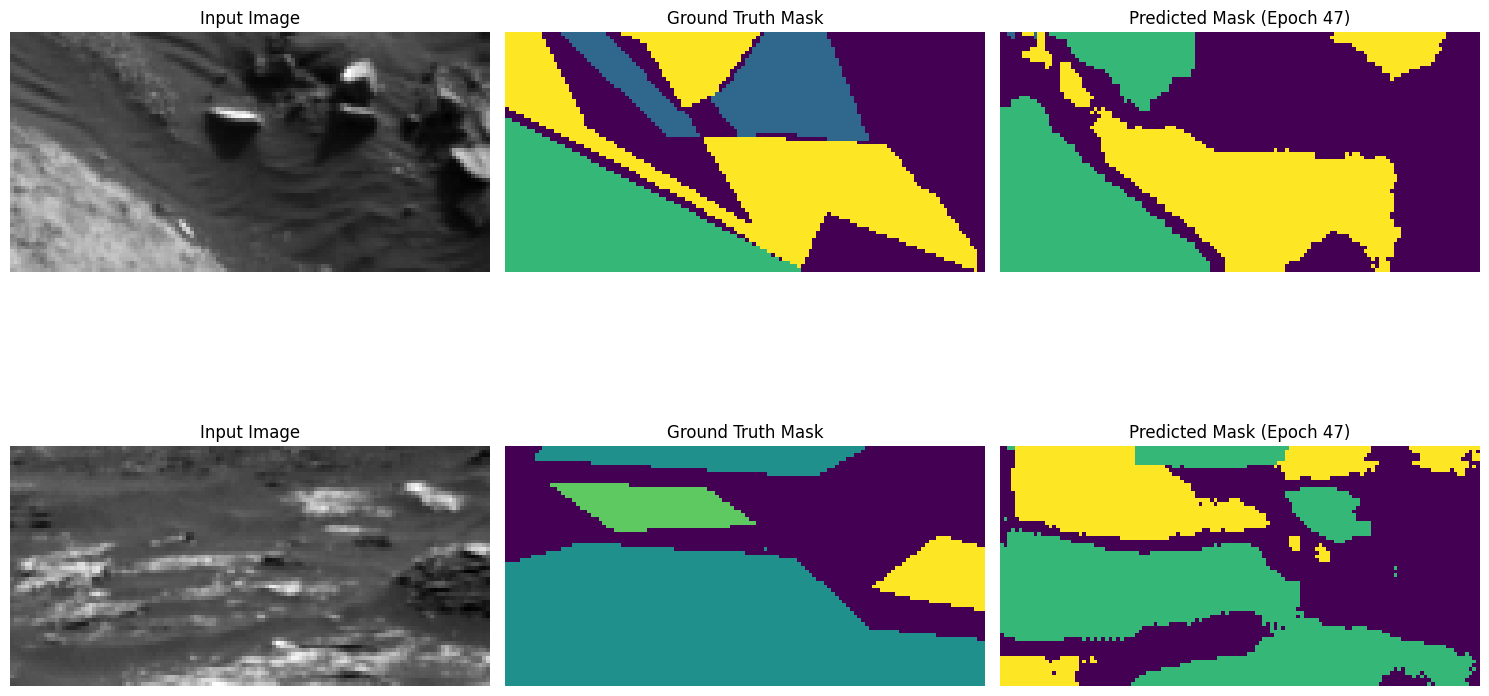

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 218ms/step - accuracy: 0.9157 - loss: 0.2220 - mean_io_u: 0.6154 - mean_iou: 0.6154 - val_accuracy: 0.7586 - val_loss: 0.9143 - val_mean_io_u: 0.4587 - val_mean_iou: 0.4587 - learning_rate: 3.1250e-06
Epoch 48/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9166 - loss: 0.2198 - mean_io_u: 0.6155 - mean_iou: 0.6155Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 48: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


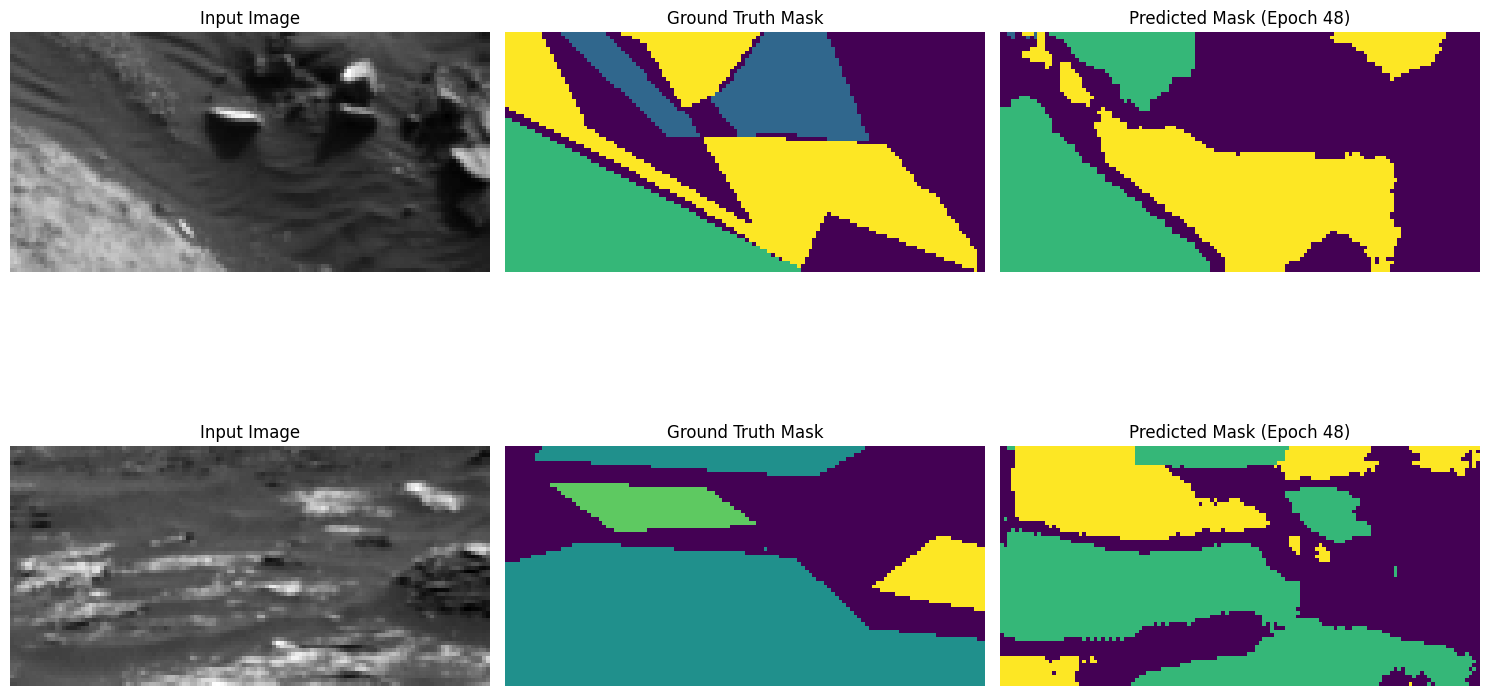

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.9166 - loss: 0.2197 - mean_io_u: 0.6155 - mean_iou: 0.6155 - val_accuracy: 0.7586 - val_loss: 0.9189 - val_mean_io_u: 0.4588 - val_mean_iou: 0.4588 - learning_rate: 3.1250e-06
Epoch 49/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9173 - loss: 0.2180 - mean_io_u: 0.6162 - mean_iou: 0.6162Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 49: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


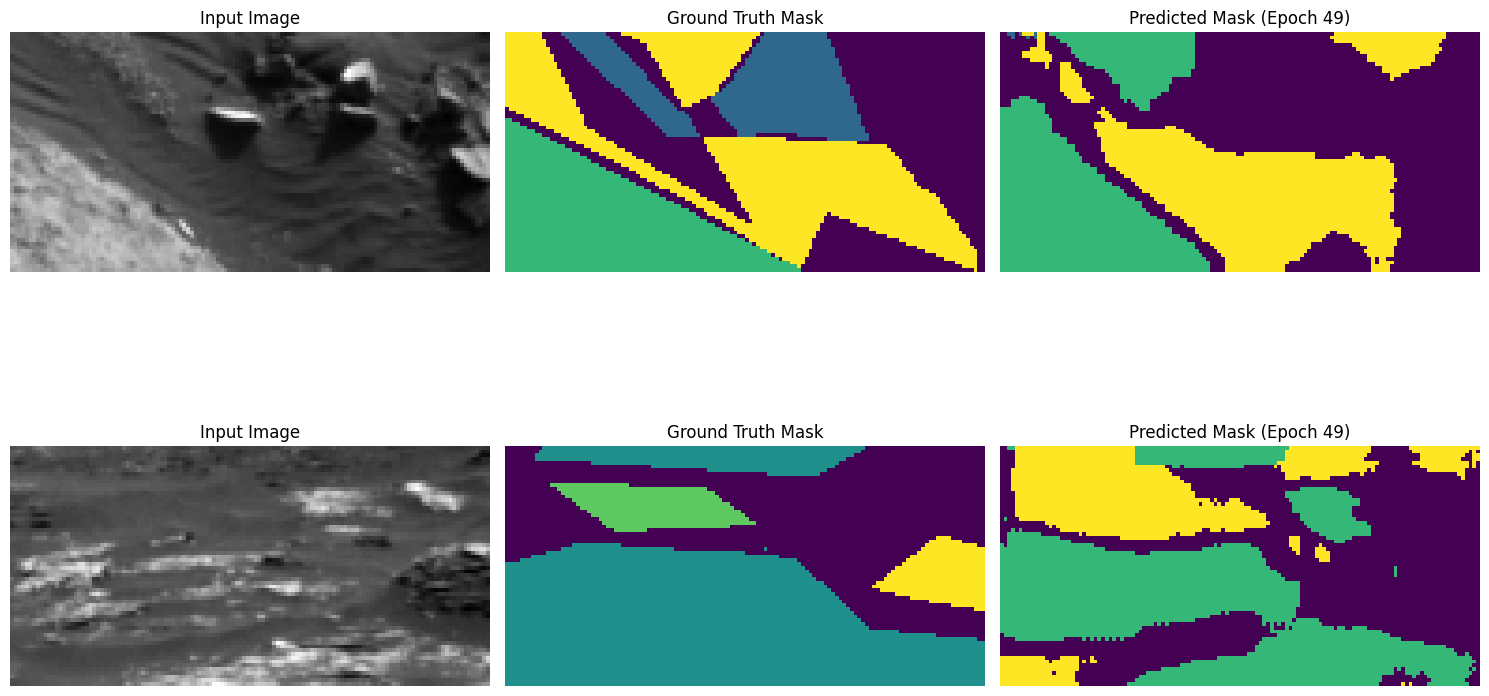

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.9173 - loss: 0.2180 - mean_io_u: 0.6162 - mean_iou: 0.6162 - val_accuracy: 0.7586 - val_loss: 0.9233 - val_mean_io_u: 0.4589 - val_mean_iou: 0.4589 - learning_rate: 3.1250e-06
Epoch 50/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9180 - loss: 0.2164 - mean_io_u: 0.6168 - mean_iou: 0.6168Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 50: val_loss did not improve from 0.64227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


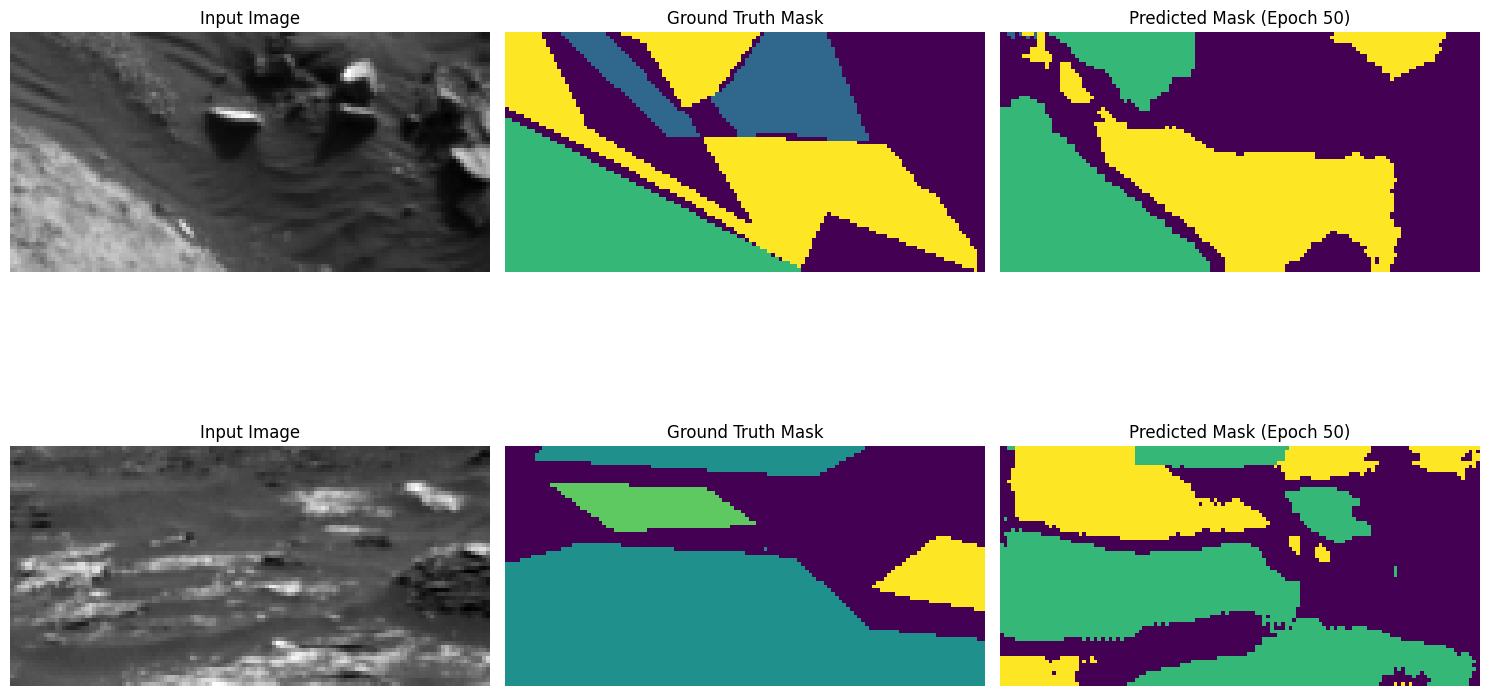

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 221ms/step - accuracy: 0.9180 - loss: 0.2164 - mean_io_u: 0.6168 - mean_iou: 0.6168 - val_accuracy: 0.7586 - val_loss: 0.9278 - val_mean_io_u: 0.4589 - val_mean_iou: 0.4589 - learning_rate: 3.1250e-06
Epoch 51/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9187 - loss: 0.2148 - mean_io_u: 0.6174 - mean_iou: 0.6174Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 51: val_loss did not improve from 0.64227

Epoch 51: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


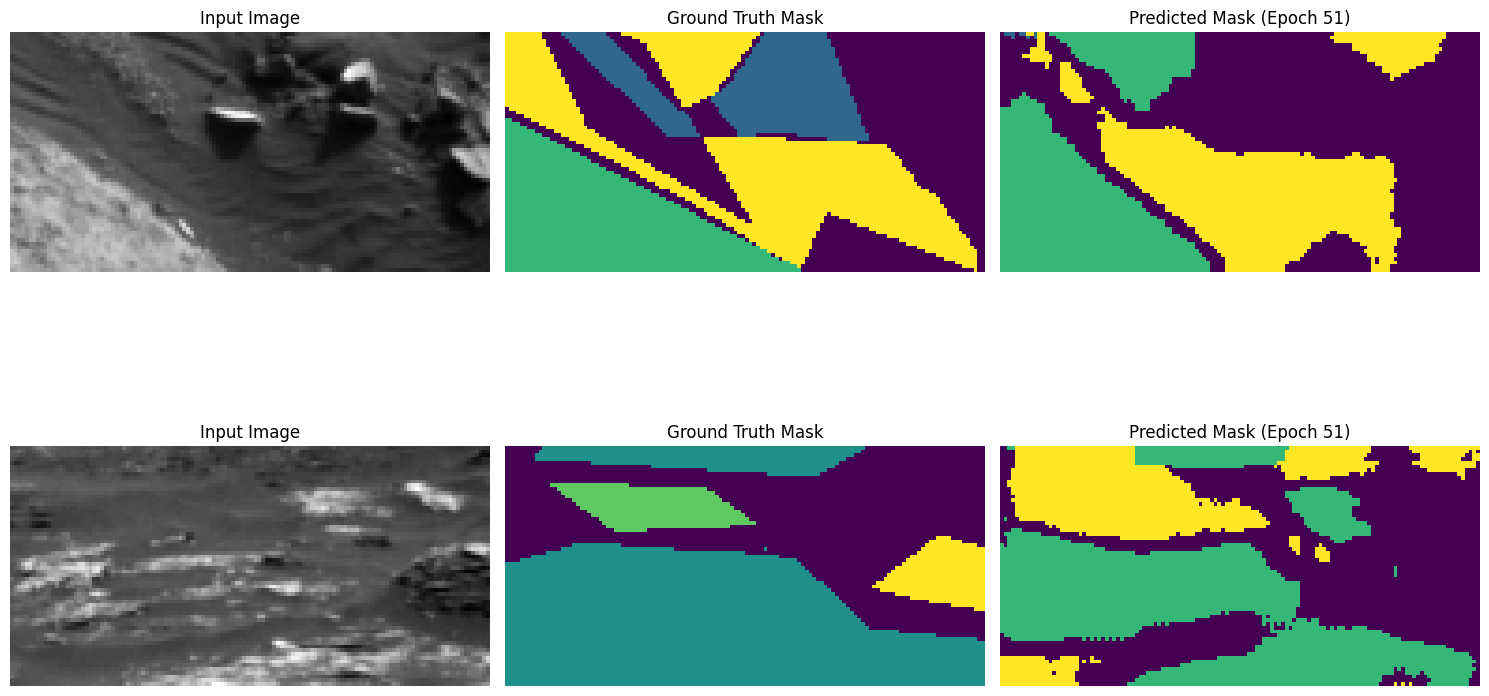

376/376 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.9187 - loss: 0.2148 - mean_io_u: 0.6174 - mean_iou: 0.6174 - val_accuracy: 0.7585 - val_loss: 0.9324 - val_mean_io_u: 0.4589 - val_mean_iou: 0.4589 - learning_rate: 3.1250e-06


In [25]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl

# Residual Block
def residual_block(x, filters):
    shortcut = x
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    shortcut = tfkl.Conv2D(filters, (1, 1), padding='same')(shortcut)
    return tfkl.add([x, shortcut])

# Dice Loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return tf.reduce_mean(1 - numerator / (denominator + tf.keras.backend.epsilon()))

# Hybrid Loss Function
def combined_loss(weights):
    ce_loss = weighted_categorical_crossentropy(weights)
    def loss(y_true, y_pred):
        return ce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# U-Net with Residual Connections
def unet_with_residual_blocks(input_shape, num_classes):
    inputs = tfkl.Input(input_shape)

    # Encoder
    c1 = residual_block(inputs, 64)
    p1 = tfkl.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = tfkl.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256)
    p3 = tfkl.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 512)

    # Decoder
    u1 = tfkl.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = tfkl.concatenate([u1, c3])
    d1 = residual_block(u1, 256)

    u2 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d1)
    u2 = tfkl.concatenate([u2, c2])
    d2 = residual_block(u2, 128)

    u3 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d2)
    u3 = tfkl.concatenate([u3, c1])
    d3 = residual_block(u3, 64)

    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(d3)

    return tf.keras.Model(inputs, outputs)

# Initialize the model
input_shape = X_train.shape[1:]
num_classes = 5  # Replace with your number of classes
ignore_class = 0  # Class to ignore

#custom_mean_iou = CustomMeanIoU(num_classes=num_classes, ignore_class=0)

model = unet_with_residual_blocks(input_shape, num_classes)
# Define the optimizer with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)
# Compile the model
model.compile(optimizer=optimizer, 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy", mean_iou, MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])])

model.summary()
# Define callbacks
save_best_miou = SaveBestMeanIoU(filepath="best_model_mean_iou.h5", monitor="val_mean_iou", mode="max", verbose=1)


# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  # Add validation data
    #batch_size=32,
    epochs=1000,
    callbacks=[save_best_miou, early_stopping, model_checkpoint, reduce_lr, visualize_callback]
)


In [26]:
# Load the saved model
best_model = tf.keras.models.load_model("best_model_mean_iou.h5", custom_objects={"MeanIoU": tf.keras.metrics.MeanIoU})



In [27]:
model=best_model

In [28]:
model_filename = f"model_augmented_hvr_best_invert_noise.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_augmented_hvr_best_invert_noise.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [29]:
import os
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [30]:
print(f"X_test shape before reshaping: {X_test.shape}")

X_test shape before reshaping: (10022, 64, 128, 1)


In [31]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 28s 86ms/step
Predictions shape: (10022, 64, 128)


Randomly selected indices for prediction (seed=42): [3543 5731 4801  416 5125 9915  293 5020 1765 4192 2288 1188  107 7583
  856 5090 9784 5192 6935  850]


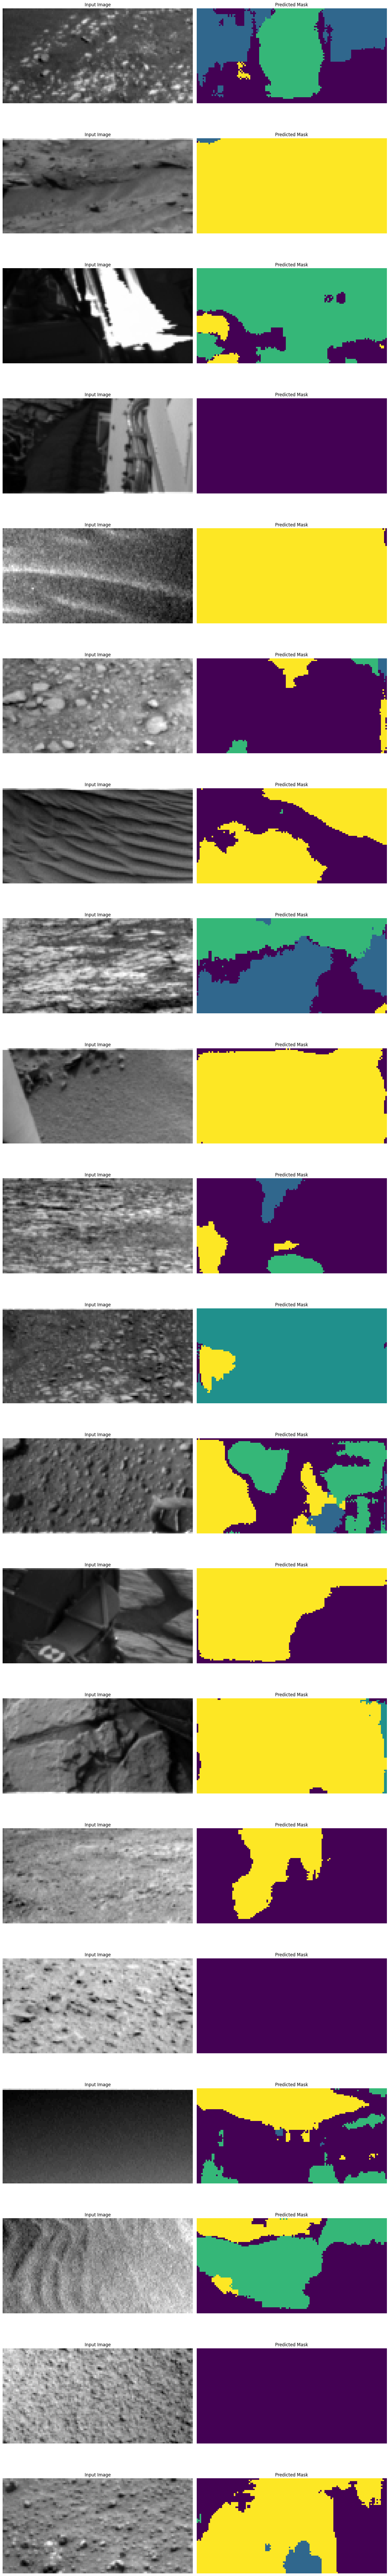

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
# Randomly select 20 indices for prediction
random_indices = np.random.choice(X_test.shape[0], size=20, replace=False)
print(f"Randomly selected indices for prediction (seed=42): {random_indices}")

# Select 20 random samples and their corresponding masks
X_sample = X_test[random_indices]



predicted_masks = preds

# Visualize the predictions
num_images = len(X_sample)  # Number of images to visualize
fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

for i in range(num_images):
    # Original Image
    ax_img = axes[i, 0]
    ax_img.imshow(X_sample[i].squeeze(), cmap="gray")
    ax_img.set_title("Input Image")
    ax_img.axis("off")

    # Predicted Mask
    ax_pred = axes[i, 1]
    ax_pred.imshow(predicted_masks[i], cmap="viridis")
    ax_pred.set_title("Predicted Mask")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()

In [33]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [34]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)



In [35]:
len(submission_df.columns)

8193

In [36]:
len(submission_df)

10022

In [37]:
"""import numpy as np
import tensorflow as tf
from skimage.util import random_noise
import matplotlib.pyplot as plt

# Define augmentation functions
def add_noise(image, amount=0.02):
    """Add salt and pepper noise."""
    return np.clip(random_noise(image, mode="s&p", amount=amount), 0, 1)

def adjust_brightness(image, delta):
    """Adjust the brightness of an image."""
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    adjusted = tf.image.adjust_brightness(image_tensor, delta=delta)
    return np.clip(adjusted.numpy(), 0, 1)

def invert_image(image):
    """Invert the grayscale image."""
    return 1.0 - image

def random_flip(image):
    """Randomly flip the image horizontally or vertically."""
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
    if np.random.rand() > 0.5:
        image = np.flipud(image)
    return image
# Randomly select 5 images for visualization
random_indices = np.random.choice(len(X_test), size=5, replace=False)
selected_images = X_test[random_indices]

# Visualize augmentations
for idx, image in enumerate(selected_images):
    plt.figure(figsize=(15, 5))

    # Original
    plt.subplot(1, 6, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Add noise
    noisy_image = add_noise(image)
    plt.subplot(1, 6, 2)
    plt.imshow(noisy_image, cmap="gray")
    plt.title("Noise")
    plt.axis("off")

    # Adjust brightness
    brighter_image = adjust_brightness(image, 0.2)
    plt.subplot(1, 6, 3)
    plt.imshow(brighter_image, cmap="gray")
    plt.title("Brighter")
    plt.axis("off")

    darker_image = adjust_brightness(image, -0.2)
    plt.subplot(1, 6, 4)
    plt.imshow(darker_image, cmap="gray")
    plt.title("Darker")
    plt.axis("off")

    # Invert
    inverted_image = invert_image(image)
    plt.subplot(1, 6, 5)
    plt.imshow(inverted_image, cmap="gray")
    plt.title("Inverted")
    plt.axis("off")

    # Random Flip
    flipped_image = random_flip(image)
    plt.subplot(1, 6, 6)
    plt.imshow(flipped_image, cmap="gray")
    plt.title("Flipped")
    plt.axis("off")

    plt.tight_layout()
    plt.show()"""


SyntaxError: invalid syntax (2361135591.py, line 8)